# Exploit Database Analysis 2020-Present

This notebook:
1. Extracts exploit code from open source between 2020 until now
2. Enriches with OSV data
3. Splits into KEV and non-KEV group
4. Analyzes both groups


## Step 1: Install Required Packages


In [1]:
%pip install requests pandas numpy matplotlib seaborn



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Downloading All Exploits (2020-Present)

We'll download all exploits from 2020-present, then filter for open source exploits using OSV data.


In [2]:
import requests
import pandas as pd
import json
from datetime import datetime
import os
import re
import time

# Download ExploitDB CSV
def download_exploitdb_csv():
    """Download ExploitDB CSV file"""
    url = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/files_exploits.csv"
    
    print("Downloading ExploitDB CSV...")
    response = requests.get(url)
    
    if response.status_code == 200:
        with open('files_exploits.csv', 'wb') as f:
            f.write(response.content)
        print("Download completed!")
        return True
    else:
        print(f"Error downloading: {response.status_code}")
        return False

# Download the CSV
download_exploitdb_csv()


Download completed!


True

In [3]:
# Load and filter ExploitDB data - ONLY filter on date, not on open source
# We will use OSV data to determine which exploits are open source
def load_and_filter_exploitdb():
    """Load ExploitDB CSV and filter ONLY on 2020-present (no open source filtering yet)"""
    
    # Read the CSV
    df = pd.read_csv('files_exploits.csv', encoding='latin-1')
    
    print(f"Total exploits loaded: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Filter on date (2020-present) ONLY
    date_col = None
    for col in ['date_published', 'date_added', 'date', 'published_date']:
        if col in df.columns:
            date_col = col
            break
    
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df_filtered = df[df[date_col] >= '2020-01-01'].copy()
        print(f"Exploits from 2020 onwards: {len(df_filtered)}")
    else:
        print("No date column found, using all data")
        df_filtered = df.copy()
    
    print(f"\nNote: We will use OSV data to identify open source exploits")
    print(f"      (exploits with CVEs that exist in OSV database)")
    
    return df_filtered

exploitdb_df = load_and_filter_exploitdb()
exploitdb_df.head()


Total exploits loaded: 46947
Columns: ['id', 'file', 'description', 'date_published', 'author', 'type', 'platform', 'port', 'date_added', 'date_updated', 'verified', 'codes', 'tags', 'aliases', 'screenshot_url', 'application_url', 'source_url']
Exploits from 2020 onwards: 4316

Note: We will use OSV data to identify open source exploits
      (exploits with CVEs that exist in OSV database)


,id,file,description,date_published,author,type,platform,port,date_added,date_updated,verified,codes,tags,aliases,screenshot_url,application_url,source_url
93,47921,exploits/android/dos/47921.txt,Android - ashmem Readonly Bypasses via remap_f...,2020-01-14,Google Security Research,dos,android,NaN,2020-01-14,2020-01-14,1,CVE-2020-0009,NaN,NaN,NaN,NaN,https://bugs.chromium.org/p/project-zero/issue...
114,51438,exploits/android/dos/51438.py,FLEX 1080 < 1085 Web 1.6.0 - Denial of Service,2023-05-13,Mr Empy,dos,android,NaN,2023-05-13,2023-05-13,0,CVE-2022-2591,NaN,NaN,NaN,NaN,NaN
166,47920,exploits/android/dos/47920.txt,WeChat - Memory Corruption in CAudioJBM::Input...,2020-01-14,Google Security Research,dos,android,NaN,2020-01-14,2020-01-14,1,NaN,NaN,NaN,NaN,NaN,https://bugs.chromium.org/p/project-zero/issue...
177,48129,exploits/android/local/48129.rb,Android Binder - Use-After-Free (Metasploit),2020-02-24,Metasploit,local,android,NaN,2020-02-24,2020-02-24,1,CVE-2019-2215,Metasploit Framework (MSF),NaN,NaN,NaN,https://raw.githubusercontent.com/rapid7/metas...
178,48129,exploits/android/local/48129.rb,Android Binder - Use-After-Free (Metasploit),2020-02-24,Metasploit,local,android,NaN,2020-02-24,2020-02-24,1,CVE-2019-2215,Local,NaN,NaN,NaN,https://raw.githubusercontent.com/rapid7/metas...


## Step 3: Identify Open Source Exploits using OSV Data

We will:
1. Extract all CVEs from ExploitDB exploits
2. Query OSV API for these CVEs
3. Filter exploits: only keep exploits where the CVE exists in OSV (these are open source)
4. Enrich the filtered exploits with OSV data


In [4]:
# OSV API endpoint
OSV_API_BASE = "https://api.osv.dev/v1"

def query_osv_by_cve(cve_id):
    """Query OSV API for a specific CVE ID"""
    url = f"{OSV_API_BASE}/vulns/{cve_id}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 404:
            return None  # CVE not found in OSV
        else:
            print(f"Error querying OSV for {cve_id}: {response.status_code}")
            return None
    except Exception as e:
        print(f"Exception querying OSV for {cve_id}: {e}")
        return None

def batch_query_osv_by_cves(cve_ids, batch_size=50):
    """Query OSV API for multiple CVE IDs using batch endpoint for better performance"""
    url = f"{OSV_API_BASE}/querybatch"
    
    all_results = {}
    successful_batches = 0
    failed_batches = 0
    
    # Process in batches using OSV's batch query endpoint
    total_batches = (len(cve_ids) - 1) // batch_size + 1
    print(f"Processing {len(cve_ids)} CVEs in {total_batches} batches of {batch_size}...")
    
    for i in range(0, len(cve_ids), batch_size):
        batch = cve_ids[i:i+batch_size]
        batch_num = i//batch_size + 1
        print(f"Batch {batch_num}/{total_batches} ({len(batch)} CVEs)...", end=' ')
        
        # Prepare batch query - OSV querybatch expects queries in format:
        # [{"id": "CVE-2020-1234"}, {"id": "CVE-2020-5678"}, ...]
        queries = [{"id": cve_id} for cve_id in batch]
        
        try:
            response = requests.post(url, json={"queries": queries}, timeout=60)
            
            if response.status_code == 200:
                batch_results = response.json()
                
                # OSV returns results in format: {"results": [{"vulns": [...]}, ...]}
                batch_matches = 0
                if 'results' in batch_results:
                    for idx, result in enumerate(batch_results['results']):
                        if 'vulns' in result and len(result['vulns']) > 0:
                            # Take the first vulnerability (most relevant)
                            cve_id = batch[idx]
                            all_results[cve_id] = result['vulns'][0]
                            batch_matches += 1
                else:
                    # Fallback: try direct structure
                    for idx, cve_id in enumerate(batch):
                        if idx < len(batch_results) and batch_results[idx]:
                            all_results[cve_id] = batch_results[idx]
                            batch_matches += 1
                
                print(f"✓ {batch_matches}/{len(batch)} matches")
                successful_batches += 1
            else:
                # Fallback to individual queries if batch fails
                print(f"✗ Batch failed ({response.status_code}), using individual queries...")
                failed_batches += 1
                for cve_id in batch:
                    vuln_data = query_osv_by_cve(cve_id)
                    if vuln_data:
                        all_results[cve_id] = vuln_data
        except Exception as e:
            print(f"✗ Error: {e}, using individual queries...")
            failed_batches += 1
            # Fallback to individual queries
            for cve_id in batch:
                vuln_data = query_osv_by_cve(cve_id)
                if vuln_data:
                    all_results[cve_id] = vuln_data
        
        # Small delay to be respectful to the API
        time.sleep(0.2)
    
    print(f"\nBatch query summary: {successful_batches} successful, {failed_batches} failed")
    return all_results

# Extract unique CVE IDs from ExploitDB data - check ALL possible columns
def extract_cves_from_exploitdb(df):
    """Extract CVE IDs from ExploitDB dataframe - checks ALL columns that might contain CVEs"""
    # Check ALL possible columns where CVEs might be stored
    possible_cve_cols = ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 
                         'description', 'tags', 'file', 'code']
    
    # Find which columns exist
    available_cols = [col for col in possible_cve_cols if col in df.columns]
    print(f"Checking {len(available_cols)} columns for CVEs: {available_cols}")
    
    if not available_cols:
        print("No potential CVE columns found in ExploitDB data")
        print(f"Available columns: {df.columns.tolist()}")
        return []
    
    # Extract CVEs from all relevant columns
    cves = []
    cve_pattern = r'CVE-\d{4}-\d{4,}'
    
    for col in available_cols:
        col_cves = []
        for idx, row in df.iterrows():
            value = row[col]
            if pd.notna(value) and value != '':
                value_str = str(value).upper()
                # Try to extract CVE patterns (CVE-YYYY-NNNNN)
                found_cves = re.findall(cve_pattern, value_str)
                col_cves.extend(found_cves)
        
        unique_col_cves = len(set(col_cves))
        if unique_col_cves > 0:
            print(f"  Column '{col}': {unique_col_cves} unique CVEs")
            cves.extend(col_cves)
    
    # Remove duplicates and normalize
    unique_cves = list(set([cve.upper().strip() for cve in cves if cve and cve.startswith('CVE-')]))
    print(f"\n✓ Total unique CVEs found across all columns: {len(unique_cves)}")
    return unique_cves

# First, let's inspect the data to see where CVEs are stored
print("=== Inspecting ExploitDB data structure ===")
print(f"Total rows: {len(exploitdb_df)}")
print(f"Columns: {exploitdb_df.columns.tolist()}\n")

# Check a few sample rows to see where CVEs might be
print("Sample data from potential CVE columns:")
for col in ['codes', 'aliases', 'cve', 'CVE']:
    if col in exploitdb_df.columns:
        sample = exploitdb_df[col].dropna().head(5)
        print(f"\n{col} column (first 5 non-null values):")
        for idx, val in sample.items():
            print(f"  Row {idx}: {val}")

print("\n" + "="*50)
print("Extracting CVE IDs from ExploitDB data...")
unique_cves = extract_cves_from_exploitdb(exploitdb_df)
print(f"\nFound {len(unique_cves)} unique CVE IDs")
if len(unique_cves) > 0:
    print(f"Sample CVEs: {unique_cves[:10]}")

# Query OSV API for these CVEs
if len(unique_cves) > 0:
    print(f"\nQuerying OSV API for {len(unique_cves)} CVEs...")
    print(f"This may take a while - OSV API will be queried for each CVE...")
    
    # Try batch first, but if it fails, use individual queries
    osv_data = batch_query_osv_by_cves(unique_cves, batch_size=50)
    
    # If batch didn't work well, use individual queries
    if len(osv_data) < len(unique_cves) * 0.1:  # If less than 10% match, batch probably failed
        print(f"\nBatch queries didn't work well ({len(osv_data)}/{len(unique_cves)} matches)")
        print(f"Using individual queries for better reliability...")
        osv_data = {}
        for i, cve_id in enumerate(unique_cves):
            if (i + 1) % 50 == 0:
                print(f"  Progress: {i+1}/{len(unique_cves)} CVEs queried ({len(osv_data)} matches so far)...")
            vuln_data = query_osv_by_cve(cve_id)
            if vuln_data:
                osv_data[cve_id] = vuln_data
            time.sleep(0.1)  # Small delay
    
    print(f"\n✓ Retrieved OSV data for {len(osv_data)} CVEs ({len(osv_data)/len(unique_cves)*100:.1f}% match rate)")
    
    # Get set of CVEs that exist in OSV (these are open source)
    osv_cve_set = set(osv_data.keys())
    print(f"\n{'='*60}")
    print(f"OPEN SOURCE IDENTIFICATION:")
    print(f"{'='*60}")
    print(f"CVEs found in OSV (open source): {len(osv_cve_set)}")
    print(f"CVEs NOT in OSV (likely not open source): {len(unique_cves) - len(osv_cve_set)}")
else:
    osv_data = {}
    osv_cve_set = set()
    print("No CVEs found to query")


=== Inspecting ExploitDB data structure ===
Total rows: 4316
Columns: ['id', 'file', 'description', 'date_published', 'author', 'type', 'platform', 'port', 'date_added', 'date_updated', 'verified', 'codes', 'tags', 'aliases', 'screenshot_url', 'application_url', 'source_url']

Sample data from potential CVE columns:

codes column (first 5 non-null values):
  Row 93: CVE-2020-0009
  Row 114: CVE-2022-2591
  Row 177: CVE-2019-2215
  Row 178: CVE-2019-2215
  Row 200: CVE-2018-20523

aliases column (first 5 non-null values):
  Row 10850: KR00K
  Row 38173: SMBGhost
  Row 41389: SMBGhost

Extracting CVE IDs from ExploitDB data...
Checking 5 columns for CVEs: ['codes', 'aliases', 'description', 'tags', 'file']
  Column 'codes': 1514 unique CVEs
  Column 'description': 4 unique CVEs

✓ Total unique CVEs found across all columns: 1518

Found 1518 unique CVE IDs
Sample CVEs: ['CVE-2020-14871', 'CVE-2021-46418', 'CVE-2020-5295', 'CVE-2020-8495', 'CVE-2015-6176', 'CVE-2020-17506', 'CVE-2024-39930

In [6]:
def filter_and_enrich_with_osv(exploit_df, osv_data_dict, osv_cve_set):
    """Filter exploits to identify open source using HYBRID approach:
    1. Exploits with CVE in OSV = open source
    2. Exploits without CVE but with open source indicators = also open source
    """
    
    print(f"\n{'='*60}")
    print(f"IDENTIFYING OPEN SOURCE EXPLOITS (HYBRID APPROACH)")
    print(f"{'='*60}")
    print(f"Total exploits before filtering: {len(exploit_df)}")
    
    # Extract CVEs from each exploit
    def extract_cve_from_value(value):
        """Extract CVE ID from a value (handles strings with multiple CVEs)"""
        if pd.isna(value) or value == '':
            return []
        value_str = str(value).upper()
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return matches
    
    # Check ALL possible CVE columns
    cve_cols_to_check = ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'description', 'tags']
    
    # Initialize column with empty lists for each row
    exploit_df['extracted_cves'] = exploit_df.apply(lambda x: [], axis=1)
    
    # Extract CVEs from ALL columns that might contain them
    print(f"Extracting CVEs from {len(cve_cols_to_check)} columns...")
    for idx, row in exploit_df.iterrows():
        all_cves = []
        for col in cve_cols_to_check:
            if col in exploit_df.columns:
                value = row[col]
                cves = extract_cve_from_value(value)
                all_cves.extend(cves)
        exploit_df.at[idx, 'extracted_cves'] = list(set(all_cves))  # Remove duplicates
    
    # Count exploits with/without CVEs
    exploits_with_cve = exploit_df[exploit_df['extracted_cves'].apply(lambda x: len(x) > 0)]
    exploits_without_cve = exploit_df[exploit_df['extracted_cves'].apply(lambda x: len(x) == 0)]
    
    print(f"\nExploits with CVE: {len(exploits_with_cve)}")
    print(f"Exploits without CVE: {len(exploits_without_cve)}")
    
    # Method 1: Exploits with CVE that's in OSV = open source
    if osv_cve_set:
        exploit_df['has_osv_cve'] = exploit_df['extracted_cves'].apply(
            lambda cves: any(cve in osv_cve_set for cve in cves) if cves else False
        )
        osv_cve_matches = exploit_df[exploit_df['has_osv_cve']]
        print(f"\nMethod 1 - Exploits with CVE in OSV: {len(osv_cve_matches)}")
    else:
        exploit_df['has_osv_cve'] = False
        osv_cve_matches = pd.DataFrame()
        print(f"\nMethod 1 - No OSV data available")
    
    # Method 2: Exploits without CVE but with open source indicators
    print(f"\nMethod 2 - Checking exploits without CVE for open source indicators...")
    
    # Open source keywords (for exploits without CVE)
    open_source_keywords = [
        'php', 'python', 'ruby', 'perl', 'java', 'javascript', 'typescript',
        'node', 'nodejs', 'go', 'golang', 'rust', 'django', 'flask', 'rails',
        'laravel', 'spring', 'express', 'react', 'angular', 'vue', 'npm',
        'pip', 'composer', 'gem', 'cargo', 'github', 'gitlab', 'bitbucket'
    ]
    pattern = '|'.join([re.escape(kw) for kw in open_source_keywords])
    
    # Check exploits without CVE
    exploits_without_cve['has_open_source_indicators'] = False
    
    for col in ['platform', 'description', 'file', 'type']:
        if col in exploits_without_cve.columns:
            exploits_without_cve['has_open_source_indicators'] = exploits_without_cve['has_open_source_indicators'] | \
                exploits_without_cve[col].str.lower().str.contains(pattern, na=False, regex=True)
    
    open_source_by_indicators = exploits_without_cve[exploits_without_cve['has_open_source_indicators']]
    print(f"  Exploits without CVE but with open source indicators: {len(open_source_by_indicators)}")
    
    # Combine both methods
    exploit_df['is_open_source'] = exploit_df['has_osv_cve'].copy()
    
    # Add exploits without CVE but with indicators
    if len(open_source_by_indicators) > 0:
        exploit_df.loc[open_source_by_indicators.index, 'is_open_source'] = True
    
    # Final open source exploits
    open_source_exploits = exploit_df[exploit_df['is_open_source']].copy()
    
    # Statistics
    total_with_cve_in_osv = len(osv_cve_matches) if osv_cve_set else 0
    total_without_cve_but_indicators = len(open_source_by_indicators)
    
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS:")
    print(f"{'='*60}")
    print(f"✓ Open source exploits (total): {len(open_source_exploits)}")
    print(f"  - Method 1: With CVE in OSV: {total_with_cve_in_osv}")
    print(f"  - Method 2: Without CVE but with open source indicators: {total_without_cve_but_indicators}")
    print(f"✗ Non-open source exploits: {len(exploit_df) - len(open_source_exploits)}")
    print(f"\nPercentage breakdown:")
    print(f"  - Open source: {len(open_source_exploits)/len(exploit_df)*100:.1f}%")
    print(f"  - Non-open source: {(len(exploit_df) - len(open_source_exploits))/len(exploit_df)*100:.1f}%")
    
    # Additional stats
    if len(exploits_with_cve) > 0:
        print(f"\nCVE statistics:")
        print(f"  - Exploits with CVE: {len(exploits_with_cve)} ({len(exploits_with_cve)/len(exploit_df)*100:.1f}%)")
        if osv_cve_set:
            cves_in_osv = len(exploits_with_cve[exploits_with_cve['extracted_cves'].apply(
                lambda cves: any(cve in osv_cve_set for cve in cves) if cves else False
            )])
            print(f"  - Exploits with CVE in OSV: {cves_in_osv} ({cves_in_osv/len(exploits_with_cve)*100:.1f}% of exploits with CVE)")
    
    # Remove temporary columns
    cols_to_drop = ['extracted_cves', 'has_osv_cve', 'is_open_source']
    if 'has_open_source_indicators' in open_source_exploits.columns:
        cols_to_drop.append('has_open_source_indicators')
    open_source_exploits = open_source_exploits.drop(columns=cols_to_drop, errors='ignore')
    
    # Now enrich with OSV data
    return enrich_with_osv(open_source_exploits, osv_data_dict)

def enrich_with_osv(exploit_df, osv_data_dict):
    """Enrich ExploitDB data with OSV API information"""
    
    if not osv_data_dict:
        print("No OSV data available for enrichment")
        return exploit_df
    
    enriched_df = exploit_df.copy()
    
    # Find CVE column in ExploitDB - check multiple possible columns
    exploit_cve_col = None
    for col in ['cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'aliases', 'codes', 'code']:
        if col in exploit_df.columns:
            # Check if this column actually contains CVEs
            sample_values = exploit_df[col].dropna().head(10)
            has_cve = any(re.search(r'CVE-\d{4}-\d{4,}', str(v).upper()) for v in sample_values if pd.notna(v))
            if has_cve:
                exploit_cve_col = col
                print(f"Using column '{col}' for CVE extraction")
                break
    
    if exploit_cve_col is None:
        print("Could not find CVE column in ExploitDB data")
        print(f"Available columns: {exploit_df.columns.tolist()}")
        # Try to find CVEs in any column
        print("Attempting to search all columns for CVEs...")
        exploit_cve_col = 'codes'  # Fallback to codes column
    
    # Extract CVE from each row and enrich with OSV data
    def extract_cve_from_value(value):
        """Extract CVE ID from a value (handles strings with multiple CVEs)"""
        if pd.isna(value) or value == '':
            return None
        value_str = str(value).upper()
        # Find CVE pattern
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return matches[0] if matches else None
    
    # Create columns for OSV data
    enriched_df['osv_id'] = None
    enriched_df['osv_summary'] = None
    enriched_df['osv_severity'] = None
    enriched_df['osv_database_specific'] = None
    enriched_df['osv_affected'] = None
    enriched_df['osv_references'] = None
    
    matches_found = 0
    
    for idx, row in enriched_df.iterrows():
        cve_value = row[exploit_cve_col]
        cve_id = extract_cve_from_value(cve_value)
        
        if cve_id and cve_id in osv_data_dict:
            osv_vuln = osv_data_dict[cve_id]
            matches_found += 1
            
            # Extract relevant OSV information
            enriched_df.at[idx, 'osv_id'] = osv_vuln.get('id', None)
            enriched_df.at[idx, 'osv_summary'] = osv_vuln.get('summary', None)
            
            # Extract severity (can be in different places in OSV schema)
            severity = None
            if 'severity' in osv_vuln and osv_vuln['severity']:
                if isinstance(osv_vuln['severity'], list) and len(osv_vuln['severity']) > 0:
                    severity = osv_vuln['severity'][0].get('score', None)
                elif isinstance(osv_vuln['severity'], dict):
                    severity = osv_vuln['severity'].get('score', None)
            enriched_df.at[idx, 'osv_severity'] = severity
            
            # Store database_specific info as JSON string
            if 'database_specific' in osv_vuln:
                enriched_df.at[idx, 'osv_database_specific'] = json.dumps(osv_vuln['database_specific'])
            
            # Store affected packages info
            if 'affected' in osv_vuln:
                enriched_df.at[idx, 'osv_affected'] = json.dumps(osv_vuln['affected'])
            
            # Store references
            if 'references' in osv_vuln:
                refs = [ref.get('url', '') for ref in osv_vuln['references']]
                enriched_df.at[idx, 'osv_references'] = json.dumps(refs)
    
    print(f"\nEnriched dataset: {len(enriched_df)} exploits")
    print(f"✓ With OSV match: {matches_found} exploits ({matches_found/len(enriched_df)*100:.1f}%)")
    
    # Additional statistics
    if matches_found > 0:
        osv_with_severity = enriched_df['osv_severity'].notna().sum()
        osv_with_summary = enriched_df['osv_summary'].notna().sum()
        print(f"  - With severity: {osv_with_severity}")
        print(f"  - With summary: {osv_with_summary}")
    
    return enriched_df

# Filter for open source exploits and enrich with OSV data
enriched_df = filter_and_enrich_with_osv(exploitdb_df, osv_data, osv_cve_set)
print(f"\n{'='*60}")
print(f"FINAL OPEN SOURCE EXPLOITS DATASET:")
print(f"{'='*60}")
print(f"Total open source exploits: {len(enriched_df)}")
print(f"Shape: {enriched_df.shape}")
if len(enriched_df) > 0:
    print(f"OSV columns: {[col for col in enriched_df.columns if col.startswith('osv_')]}")
    enriched_df.head()
else:
    print("No open source exploits found!")



IDENTIFYING OPEN SOURCE EXPLOITS (HYBRID APPROACH)
Total exploits before filtering: 4316
Extracting CVEs from 9 columns...

Exploits with CVE: 1535
Exploits without CVE: 2781

Method 1 - Exploits with CVE in OSV: 516

Method 2 - Checking exploits without CVE for open source indicators...
  Exploits without CVE but with open source indicators: 1584

FINAL RESULTS:
✓ Open source exploits (total): 2100
  - Method 1: With CVE in OSV: 516
  - Method 2: Without CVE but with open source indicators: 1584
✗ Non-open source exploits: 2216

Percentage breakdown:
  - Open source: 48.7%
  - Non-open source: 51.3%

CVE statistics:
  - Exploits with CVE: 1535 (35.6%)
  - Exploits with CVE in OSV: 516 (33.6% of exploits with CVE)
Using column 'codes' for CVE extraction

Enriched dataset: 2100 exploits
✓ With OSV match: 516 exploits (24.6%)
  - With severity: 510
  - With summary: 69

FINAL OPEN SOURCE EXPLOITS DATASET:
Total open source exploits: 2100
Shape: (2100, 23)
OSV columns: ['osv_id', 'osv_su

/var/folders/36/t6wnqflx2mz5tzgwpxn52wpc0000gn/T/ipykernel_567/2715688766.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploits_without_cve['has_open_source_indicators'] = False
/var/folders/36/t6wnqflx2mz5tzgwpxn52wpc0000gn/T/ipykernel_567/2715688766.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploits_without_cve['has_open_source_indicators'] = exploits_without_cve['has_open_source_indicators'] | \


## Step 4: Splitting into KEV and Non-KEV Group


In [12]:
def download_kev_data():
    """Download Vulncheck KEV (Known Exploited Vulnerabilities) data"""
    
    # Vulncheck API key
    VULNCHECK_API_KEY = "vulncheck_a8192e23c3ca459ecbb8799059d3bbcce69c5b67e8d408cac24206d5c3d48614"
    
    # Vulncheck uses Bearer token authentication
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {VULNCHECK_API_KEY}"
    }
    
    # Try multiple Vulncheck endpoints to find the one with actual CVE data
    # Note: The backup endpoint might return file metadata, not the actual data
    endpoints = [
        "https://api.vulncheck.com/v3/index/vulncheck-kev",
        "https://api.vulncheck.com/v3/kev",
        "https://api.vulncheck.com/v3/kev/list",
        "https://api.vulncheck.com/v3/index/kev",
        "https://api.vulncheck.com/v3/backup/vulncheck-kev",  # Backup endpoint (might need different handling)
    ]
    
    print("="*60)
    print("Downloading Vulncheck KEV Database")
    print("="*60)
    
    for url in endpoints:
        try:
            print(f"\nTrying endpoint: {url}")
            response = requests.get(url, headers=headers, timeout=60)
            
            print(f"  Status code: {response.status_code}")
            
            if response.status_code == 200:
                try:
                    kev_data = response.json()
                except json.JSONDecodeError as e:
                    print(f"  ✗ Failed to parse JSON response: {e}")
                    print(f"    Response text (first 500 chars): {response.text[:500]}")
                    continue
                
                # Inspect the structure
                print(f"  Response type: {type(kev_data)}")
                if isinstance(kev_data, dict):
                    print(f"  Top-level keys: {list(kev_data.keys())[:10]}")
                    if 'data' in kev_data:
                        data_item = kev_data['data']
                        print(f"  'data' type: {type(data_item)}")
                        if isinstance(data_item, list):
                            print(f"  'data' length: {len(data_item)}")
                            if len(data_item) > 0:
                                print(f"  First item type: {type(data_item[0])}")
                                if isinstance(data_item[0], dict):
                                    print(f"  First item keys: {list(data_item[0].keys())[:10]}")
                    elif 'vulnerabilities' in kev_data:
                        vuln_item = kev_data['vulnerabilities']
                        print(f"  'vulnerabilities' type: {type(vuln_item)}")
                        if isinstance(vuln_item, list):
                            print(f"  'vulnerabilities' length: {len(vuln_item)}")
                
                # Extract CVEs using regex (most reliable method)
                try:
                    kev_data_str = json.dumps(kev_data)
                    cve_pattern = r'CVE-\d{4}-\d{4,}'
                    all_cves_in_response = set(re.findall(cve_pattern, kev_data_str.upper()))
                    
                    print(f"  Found {len(all_cves_in_response)} CVEs using regex")
                except Exception as e:
                    print(f"  ✗ Error extracting CVEs: {e}")
                    all_cves_in_response = set()
                
                if len(all_cves_in_response) > 0:
                    print(f"\n✓ SUCCESS: Found {len(all_cves_in_response)} CVEs in Vulncheck KEV!")
                    sample_cves = sorted(list(all_cves_in_response))[:15]
                    print(f"  Sample CVEs: {sample_cves}")
                    
                    # Show year distribution
                    years = {}
                    for cve in all_cves_in_response:
                        year = cve.split('-')[1] if len(cve.split('-')) >= 2 else 'unknown'
                        years[year] = years.get(year, 0) + 1
                    print(f"\n  CVE year distribution:")
                    for year in sorted(years.keys()):
                        print(f"    {year}: {years[year]} CVEs")
                    
                    # Save raw data
                    with open('kev_data.json', 'w') as f:
                        json.dump(kev_data, f, indent=2)
                    print(f"\n  ✓ Saved to kev_data.json")
                    return kev_data
                else:
                    print(f"  ⚠️  No CVEs found in this endpoint")
                    # Save for inspection
                    debug_filename = f'kev_data_debug_{endpoints.index(url)}.json'
                    with open(debug_filename, 'w') as f:
                        json.dump(kev_data, f, indent=2)
                    print(f"  Saved debug data to {debug_filename}")
                    
                    # Try to extract from structure if it's a list of items
                    if isinstance(kev_data, dict):
                        if 'data' in kev_data:
                            if isinstance(kev_data['data'], list) and len(kev_data['data']) > 0:
                                first_item = kev_data['data'][0]
                                if isinstance(first_item, dict):
                                    print(f"  First item sample: {json.dumps(first_item, indent=2)[:500]}")
                        # Check if it's a backup endpoint response (might have file URLs)
                        elif 'url' in kev_data or 'download_url' in kev_data:
                            print(f"  ⚠️  This appears to be a backup metadata response, not actual KEV data")
                            print(f"  Keys: {list(kev_data.keys())}")
                            # If there's a download URL, we could fetch it, but that's complex
                    elif isinstance(kev_data, list) and len(kev_data) > 0:
                        print(f"  Data is a list with {len(kev_data)} items")
                        if isinstance(kev_data[0], dict):
                            print(f"  First item keys: {list(kev_data[0].keys())[:10]}")
                            print(f"  First item sample: {json.dumps(kev_data[0], indent=2)[:500]}")
            elif response.status_code == 401:
                print(f"  ✗ Authentication failed (401) - check API key")
            elif response.status_code == 403:
                print(f"  ✗ Forbidden (403) - check API permissions")
            else:
                print(f"  ✗ Unexpected status: {response.status_code}")
                print(f"    Response: {response.text[:200]}")
                
        except requests.exceptions.Timeout:
            print(f"  ✗ Request timed out")
        except requests.exceptions.ConnectionError:
            print(f"  ✗ Connection error")
        except requests.exceptions.JSONDecodeError as e:
            print(f"  ✗ JSON decode error: {e}")
            print(f"    Response text (first 500 chars): {response.text[:500] if 'response' in locals() else 'N/A'}")
        except Exception as e:
            print(f"  ✗ Error: {type(e).__name__}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # If all Vulncheck endpoints fail, try CISA KEV as fallback
    print("\n" + "="*60)
    print("All Vulncheck endpoints failed - trying CISA KEV as fallback...")
    print("="*60)
    cisa_result = download_cisa_kev()
    
    if cisa_result is None:
        print("\n⚠️  WARNING: Could not download KEV data from any source!")
        print("   The analysis will continue but no KEV matching will be possible.")
        return None
    
    return cisa_result

def download_cisa_kev():
    """Download CISA KEV catalog - this is the most reliable source with CVEs"""
    url = "https://www.cisa.gov/sites/default/files/feeds/known_exploited_vulnerabilities.json"
    
    try:
        print("Downloading CISA KEV catalog...")
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            kev_data = response.json()
            
            with open('kev_data.json', 'w') as f:
                json.dump(kev_data, f, indent=2)
            
            # Extract CVEs using regex (most reliable)
            kev_data_str = json.dumps(kev_data)
            cve_pattern = r'CVE-\d{4}-\d{4,}'
            all_cves = set(re.findall(cve_pattern, kev_data_str.upper()))
            
            vuln_count = len(kev_data.get('vulnerabilities', []))
            print(f"✓ CISA KEV data downloaded: {vuln_count} vulnerabilities")
            print(f"✓ Found {len(all_cves)} unique CVEs in CISA KEV")
            if len(all_cves) > 0:
                sample_cves = sorted(list(all_cves))[:15]
                print(f"Sample CVEs: {sample_cves}")
                
                # Show year distribution
                years = {}
                for cve in all_cves:
                    year = cve.split('-')[1] if len(cve.split('-')) >= 2 else 'unknown'
                    years[year] = years.get(year, 0) + 1
                print(f"\nCVE year distribution in CISA KEV:")
                for year in sorted(years.keys()):
                    print(f"  {year}: {years[year]} CVEs")
            
            return kev_data
    except Exception as e:
        print(f"✗ Error downloading CISA KEV: {e}")
        return None

kev_data = download_kev_data()



Trying endpoint: https://api.vulncheck.com/v3/index/vulncheck-kev
  Status code: 200
  Response type: <class 'dict'>
  Top-level keys: ['_benchmark', '_meta', 'data']
  'data' type: <class 'list'>
  'data' length: 100
  First item type: <class 'dict'>
  First item keys: ['vendorProject', 'product', 'shortDescription', 'vulnerabilityName', 'required_action', 'knownRansomwareCampaignUse', 'cve', 'cwes', 'vulncheck_xdb', 'vulncheck_reported_exploitation']
  Found 106 CVEs using regex

✓ SUCCESS: Found 106 CVEs in Vulncheck KEV!
  Sample CVEs: ['CVE-2023-50224', 'CVE-2025-49704', 'CVE-2025-49706', 'CVE-2025-52970', 'CVE-2025-53118', 'CVE-2025-53324', 'CVE-2025-53364', 'CVE-2025-5349', 'CVE-2025-53690', 'CVE-2025-53770', 'CVE-2025-53771', 'CVE-2025-53772', 'CVE-2025-53833', 'CVE-2025-5394', 'CVE-2025-5397']

  CVE year distribution:
    2023: 1 CVEs
    2025: 104 CVEs
    2026: 1 CVEs

  ✓ Saved to kev_data.json


In [15]:
def check_cve_in_kev_via_api(cve_id, api_key):
    """Check if a specific CVE is in Vulncheck KEV via API
    
    According to VulnCheck documentation:
    https://docs.vulncheck.com/indices/vulncheck-intelligence#vulncheck-kev
    The vulncheck-kev index contains exploited vulnerabilities known to VulnCheck
    """
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    # Try different endpoints based on VulnCheck API documentation
    # The vulncheck-kev index endpoint: https://api.vulncheck.com/v3/index/vulncheck-kev
    endpoints = [
        f"https://api.vulncheck.com/v3/index/vulncheck-kev?cve={cve_id}",
        f"https://api.vulncheck.com/v3/index/vulncheck-kev/{cve_id}",
        f"https://api.vulncheck.com/v3/kev/{cve_id}",
        f"https://api.vulncheck.com/v3/kev?cve={cve_id}",
    ]
    
    for url in endpoints:
        try:
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                data = response.json()
                # Check if we got meaningful data back
                if data:
                    # If it's a dict with 'data' key, check if data is not empty
                    if isinstance(data, dict):
                        if 'data' in data:
                            # If data is a list and not empty, CVE is in KEV
                            if isinstance(data['data'], list) and len(data['data']) > 0:
                                return True
                            # If data is a dict and not empty, CVE is in KEV
                            elif isinstance(data['data'], dict) and len(data['data']) > 0:
                                return True
                        # If it's a dict with CVE-related keys, it's probably in KEV
                        elif 'cve' in data or 'cveID' in data or 'vulnerabilityName' in data:
                            return True
                    # If it's a list and not empty, CVE is in KEV
                    elif isinstance(data, list) and len(data) > 0:
                        return True
            elif response.status_code == 404:
                # CVE not found in KEV
                return False
        except Exception as e:
            continue
    
    return False

def check_cves_in_kev_batch(cve_ids, api_key, batch_size=50):
    """Check multiple CVEs in KEV via API - processes in batches with progress"""
    VULNCHECK_API_KEY = api_key
    
    print(f"Checking {len(cve_ids)} CVEs against Vulncheck KEV API...")
    print(f"This will make {len(cve_ids)} API requests (in batches of {batch_size})...")
    
    cves_in_kev = set()
    cves_not_in_kev = set()
    
    # Process in batches to show progress
    total_batches = (len(cve_ids) - 1) // batch_size + 1
    
    for i in range(0, len(cve_ids), batch_size):
        batch = cve_ids[i:i+batch_size]
        batch_num = i // batch_size + 1
        
        print(f"Batch {batch_num}/{total_batches} ({len(batch)} CVEs)...", end=' ')
        
        batch_in_kev = 0
        for cve_id in batch:
            try:
                if check_cve_in_kev_via_api(cve_id, VULNCHECK_API_KEY):
                    cves_in_kev.add(cve_id)
                    batch_in_kev += 1
                else:
                    cves_not_in_kev.add(cve_id)
                # Small delay to be respectful to API
                time.sleep(0.1)
            except Exception as e:
                # If check fails, assume not in KEV
                cves_not_in_kev.add(cve_id)
        
        print(f"✓ {batch_in_kev}/{len(batch)} found in KEV")
    
    print(f"\n{'='*60}")
    print(f"KEV CHECK RESULTS:")
    print(f"{'='*60}")
    print(f"✓ CVEs found in KEV: {len(cves_in_kev)} ({len(cves_in_kev)/len(cve_ids)*100:.1f}%)")
    print(f"✗ CVEs NOT in KEV: {len(cves_not_in_kev)} ({len(cves_not_in_kev)/len(cve_ids)*100:.1f}%)")
    
    if len(cves_in_kev) > 0:
        sample = sorted(list(cves_in_kev))[:15]
        print(f"\nSample CVEs found in KEV: {sample}")
    
    return cves_in_kev, cves_not_in_kev

# Extract all unique CVEs from our enriched exploits
print("="*60)
print("EXTRACTING ALL CVEs FROM EXPLOITS")
print("="*60)

def extract_cve_from_value(value):
    """Extract CVE ID from a value"""
    if pd.isna(value) or value == '' or value == 'nan':
        return []
    value_str = str(value).upper()
    cve_pattern = r'CVE-\d{4}-\d{4,}'
    matches = re.findall(cve_pattern, value_str)
    return matches

# Extract CVEs from all exploits
all_exploit_cves_list = []
cve_source_col = None

for col in ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'description', 'tags']:
    if col in enriched_df.columns:
        sample = enriched_df[col].dropna().head(10)
        has_cve = any(extract_cve_from_value(v) for v in sample if pd.notna(v))
        if has_cve:
            cve_source_col = col
            print(f"Using column '{col}' to extract CVEs")
            break

if cve_source_col:
    for idx, row in enriched_df.iterrows():
        value = row[cve_source_col]
        cves = extract_cve_from_value(value)
        all_exploit_cves_list.extend(cves)

# Get unique CVEs
unique_cves = list(set([cve.upper().strip() for cve in all_exploit_cves_list if cve and cve.startswith('CVE-')]))

print(f"\nFound {len(unique_cves)} unique CVEs in exploits")
if len(unique_cves) > 0:
    print(f"Sample CVEs: {unique_cves[:10]}")

# Now check each CVE against KEV API
VULNCHECK_API_KEY = "vulncheck_a8192e23c3ca459ecbb8799059d3bbcce69c5b67e8d408cac24206d5c3d48614"

if len(unique_cves) > 0:
    cves_in_kev_set, cves_not_in_kev_set = check_cves_in_kev_batch(unique_cves, VULNCHECK_API_KEY, batch_size=50)
    
    # Save results
    kev_check_results = {
        'cves_in_kev': sorted(list(cves_in_kev_set)),
        'cves_not_in_kev': sorted(list(cves_not_in_kev_set))
    }
    
    with open('kev_check_results.json', 'w') as f:
        json.dump(kev_check_results, f, indent=2)
    
    print(f"\n✓ Results saved to kev_check_results.json")
else:
    print("No CVEs found to check")
    cves_in_kev_set = set()
    cves_not_in_kev_set = set()


EXTRACTING ALL CVEs FROM EXPLOITS
Using column 'codes' to extract CVEs

Found 505 unique CVEs in exploits
Sample CVEs: ['CVE-2024-11956', 'CVE-2020-5295', 'CVE-2023-32235', 'CVE-2023-31698', 'CVE-2024-42327', 'CVE-2024-39930', 'CVE-2023-30258', 'CVE-2023-29689', 'CVE-2021-31761', 'CVE-2025-0868']
Checking 505 CVEs against Vulncheck KEV API...
This will make 505 API requests (in batches of 50)...
Batch 1/11 (50 CVEs)... ✓ 10/50 found in KEV
Batch 2/11 (50 CVEs)... ✓ 9/50 found in KEV
Batch 3/11 (50 CVEs)... ✓ 10/50 found in KEV
Batch 4/11 (50 CVEs)... ✓ 13/50 found in KEV
Batch 5/11 (50 CVEs)... ✓ 9/50 found in KEV
Batch 6/11 (50 CVEs)... ✓ 16/50 found in KEV
Batch 7/11 (50 CVEs)... ✓ 7/50 found in KEV
Batch 8/11 (50 CVEs)... ✓ 12/50 found in KEV
Batch 9/11 (50 CVEs)... ✓ 12/50 found in KEV
Batch 10/11 (50 CVEs)... ✓ 13/50 found in KEV
Batch 11/11 (5 CVEs)... ✓ 0/5 found in KEV

KEV CHECK RESULTS:
✓ CVEs found in KEV: 111 (22.0%)
✗ CVEs NOT in KEV: 394 (78.0%)

Sample CVEs found in KEV:

In [16]:
def split_by_kev_using_api_results(enriched_df, cves_in_kev_set):
    """Split exploits based on API check results - much more reliable!"""
    
    print(f"\n{'='*60}")
    print(f"SPLITTING EXPLOITS BASED ON KEV API CHECK RESULTS")
    print(f"{'='*60}")
    print(f"Total exploits to split: {len(enriched_df)}")
    print(f"CVEs found in KEV (via API): {len(cves_in_kev_set)}")
    
    # Extract CVEs from each exploit
    def extract_cve_from_value(value):
        """Extract CVE ID from a value"""
        if pd.isna(value) or value == '' or value == 'nan':
            return []
        value_str = str(value).upper()
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return [cve.upper().strip() for cve in matches]
    
    # Find CVE column
    cve_source_col = None
    for col in ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID']:
        if col in enriched_df.columns:
            sample = enriched_df[col].dropna().head(10)
            has_cve = any(extract_cve_from_value(v) for v in sample if pd.notna(v))
            if has_cve:
                cve_source_col = col
                print(f"Using column '{col}' to extract CVEs from exploits")
                break
    
    if cve_source_col is None:
        print("WARNING: Could not find CVE column")
        return pd.DataFrame(), enriched_df.copy()
    
    # Extract CVEs for each exploit
    enriched_df['extracted_cves'] = enriched_df[cve_source_col].apply(extract_cve_from_value)
    
    # Check each exploit against KEV results
    enriched_df['has_kev_cve'] = enriched_df['extracted_cves'].apply(
        lambda cves: any(cve in cves_in_kev_set for cve in cves) if cves else False
    )
    
    # Split the dataset
    found_mask = enriched_df['has_kev_cve'] == True
    not_found_mask = ~found_mask
    
    found_in_kev = enriched_df[found_mask].copy()
    not_found_in_kev = enriched_df[not_found_mask].copy()
    
    # Remove temporary columns
    found_in_kev = found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    not_found_in_kev = not_found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    
    # Statistics
    total_original = len(enriched_df)
    total_split = len(found_in_kev) + len(not_found_in_kev)
    
    print(f"\n{'='*60}")
    print(f"SPLIT RESULTS:")
    print(f"{'='*60}")
    print(f"✓ Found in KEV: {len(found_in_kev)} exploits ({len(found_in_kev)/total_original*100:.1f}%)")
    print(f"✓ Not found in KEV: {len(not_found_in_kev)} exploits ({len(not_found_in_kev)/total_original*100:.1f}%)")
    print(f"Total after split: {total_split}")
    
    if total_split == total_original:
        print(f"✓ All exploits successfully split!")
    else:
        print(f"⚠️  Warning: {total_original - total_split} exploits missing!")
    
    # Save datasets
    found_in_kev.to_csv('exploits_found_in_kev.csv', index=False)
    not_found_in_kev.to_csv('exploits_not_found_in_kev.csv', index=False)
    
    print(f"\nDatasets saved:")
    print(f"- exploits_found_in_kev.csv ({len(found_in_kev)} rows)")
    print(f"- exploits_not_found_in_kev.csv ({len(not_found_in_kev)} rows)")
    
    return found_in_kev, not_found_in_kev

def split_by_kev(enriched_df, kev_data):
    """Split the dataset into 'found in KEV' and 'not found in KEV' - ALL exploits must be in one group"""
    
    if kev_data is None:
        print("KEV data not available - cannot split")
        # Return all exploits as "not found" if KEV data unavailable
        return pd.DataFrame(), enriched_df.copy()
    
    print(f"Total exploits to split: {len(enriched_df)}")
    
    # Extract ALL CVEs from KEV data using regex (most reliable method)
    print(f"\n{'='*60}")
    print(f"EXTRACTING CVEs FROM KEV DATABASE:")
    print(f"{'='*60}")
    print(f"Using regex to extract ALL CVEs from KEV data...")
    
    kev_data_str = json.dumps(kev_data) if not isinstance(kev_data, str) else kev_data
    cve_pattern = r'CVE-\d{4}-\d{4,}'
    kev_cves_regex = re.findall(cve_pattern, kev_data_str.upper())
    kev_cves_regex = [cve.upper().strip() for cve in kev_cves_regex]  # Normalize
    
    print(f"✓ Found {len(kev_cves_regex)} CVEs using regex extraction")
    
    # If no CVEs found with regex, the data structure is wrong
    if len(kev_cves_regex) == 0:
        print(f"\n⚠️  WARNING: Regex found 0 CVEs!")
        print(f"Inspecting KEV data structure in detail...")
        if isinstance(kev_data, dict):
            print(f"  Top-level keys: {list(kev_data.keys())}")
            if 'vulnerabilities' in kev_data:
                print(f"  'vulnerabilities' is a {type(kev_data['vulnerabilities'])} with {len(kev_data['vulnerabilities'])} items")
                if len(kev_data['vulnerabilities']) > 0:
                    first_vuln = kev_data['vulnerabilities'][0]
                    print(f"  First vulnerability keys: {list(first_vuln.keys())}")
                    print(f"  First vulnerability sample: {json.dumps(first_vuln, indent=2)[:800]}")
            elif 'data' in kev_data:
                print(f"  'data' is a {type(kev_data['data'])}")
                if isinstance(kev_data['data'], list) and len(kev_data['data']) > 0:
                    print(f"  First data item type: {type(kev_data['data'][0])}")
                    if isinstance(kev_data['data'][0], dict):
                        print(f"  First data item keys: {list(kev_data['data'][0].keys())}")
                        print(f"  First data item sample: {json.dumps(kev_data['data'][0], indent=2)[:800]}")
    
    # Also try structured extraction for additional CVEs
    print(f"\nAlso trying structured extraction...")
    kev_cves = []
    
    if isinstance(kev_data, dict):
        if 'vulnerabilities' in kev_data:
            # CISA format - this is the standard format
            print("Detected CISA format (vulnerabilities key)")
            print(f"  Processing {len(kev_data['vulnerabilities'])} vulnerabilities...")
            for v in kev_data['vulnerabilities']:
                # CISA uses 'cveID' field
                cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('CVE')
                if cve:
                    cve_clean = str(cve).upper().strip()
                    if cve_clean.startswith('CVE-'):
                        kev_cves.append(cve_clean)
            print(f"  Extracted {len(set(kev_cves))} unique CVEs from structured extraction")
        elif 'data' in kev_data:
            # Vulncheck format
            print("Detected Vulncheck format (data key)")
            if isinstance(kev_data['data'], list):
                print(f"  Data is a list with {len(kev_data['data'])} items")
                for v in kev_data['data']:
                    if isinstance(v, dict):
                        # Try multiple CVE field names
                        cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('cveID') or v.get('id')
                        if cve:
                            kev_cves.append(str(cve).upper().strip())
            elif isinstance(kev_data['data'], dict):
                print(f"  Data is a dict with {len(kev_data['data'])} keys")
                for v in kev_data['data'].values():
                    if isinstance(v, dict):
                        cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('id')
                        if cve:
                            kev_cves.append(str(cve).upper().strip())
        elif 'results' in kev_data:
            # Alternative format
            print("Detected results format")
            for v in kev_data['results']:
                if isinstance(v, dict):
                    cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('id')
                    if cve:
                        kev_cves.append(str(cve).upper().strip())
        else:
            # Try to extract from dict values - also check if keys are CVEs
            print("Trying to extract from dict structure...")
            for key, value in kev_data.items():
                # Check if key itself is a CVE
                if isinstance(key, str) and key.upper().startswith('CVE-'):
                    kev_cves.append(key.upper().strip())
                # Check value
                if isinstance(value, dict):
                    cve = value.get('cveID') or value.get('cve') or value.get('cve_id') or value.get('id')
                    if cve:
                        kev_cves.append(str(cve).upper().strip())
    elif isinstance(kev_data, list):
        print("KEV data is a list")
        for v in kev_data:
            if isinstance(v, dict):
                cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('id')
                if cve:
                    kev_cves.append(str(cve).upper().strip())
    
    # Combine both methods - regex is most reliable
    all_kev_cves = list(set(kev_cves + kev_cves_regex))
    
    # Normalize all CVEs: uppercase, strip whitespace, ensure CVE- format
    kev_cves_set = set()
    for cve in all_kev_cves:
        cve_clean = str(cve).upper().strip()
        # Validate CVE format: CVE-YYYY-NNNN+
        if cve_clean.startswith('CVE-') and len(cve_clean) > 8:
            # Check format: CVE-YYYY-NNNN
            parts = cve_clean.split('-')
            if len(parts) >= 3 and parts[1].isdigit() and len(parts[1]) == 4:
                kev_cves_set.add(cve_clean)
    
    print(f"\n{'='*60}")
    print(f"KEV DATABASE SUMMARY:")
    print(f"{'='*60}")
    print(f"Total unique CVEs in KEV database: {len(kev_cves_set)}")
    
    if len(kev_cves_set) > 0:
        sample_kev = sorted(list(kev_cves_set))[:15]
        print(f"Sample KEV CVEs: {sample_kev}")
        
        # Show CVE year distribution
        years = {}
        for cve in kev_cves_set:
            year = cve.split('-')[1] if len(cve.split('-')) >= 2 else 'unknown'
            years[year] = years.get(year, 0) + 1
        print(f"\nCVE distribution by year:")
        for year in sorted(years.keys()):
            print(f"  {year}: {years[year]} CVEs")
    else:
        print("⚠️  WARNING: No CVEs found in KEV data!")
        print(f"\nDebugging KEV data structure:")
        print(f"  Type: {type(kev_data)}")
        if isinstance(kev_data, dict):
            print(f"  Top-level keys: {list(kev_data.keys())[:10]}")
            if 'vulnerabilities' in kev_data:
                print(f"  Vulnerabilities count: {len(kev_data['vulnerabilities'])}")
                if len(kev_data['vulnerabilities']) > 0:
                    print(f"  First vulnerability keys: {list(kev_data['vulnerabilities'][0].keys())[:10]}")
                    print(f"  First vulnerability sample: {json.dumps(kev_data['vulnerabilities'][0], indent=2)[:500]}")
    
    # Extract CVEs from each exploit (same method as OSV enrichment)
    def extract_cve_from_value(value):
        """Extract CVE ID from a value (handles strings with multiple CVEs)"""
        if pd.isna(value) or value == '' or value == 'nan':
            return []
        value_str = str(value).upper()
        # Find CVE pattern
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return matches
    
    # Find column with CVEs in enriched_df
    cve_source_col = None
    for col in ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID']:
        if col in enriched_df.columns:
            # Check if this column contains CVEs
            sample = enriched_df[col].dropna().head(10)
            has_cve = any(extract_cve_from_value(v) for v in sample if pd.notna(v))
            if has_cve:
                cve_source_col = col
                print(f"Using column '{col}' to extract CVEs from exploits")
                break
    
    if cve_source_col is None:
        print("WARNING: Could not find CVE column in enriched_df")
        print(f"Available columns: {enriched_df.columns.tolist()}")
        # If no CVE column, all exploits go to "not found"
        print("All exploits will be placed in 'not found in KEV' group")
        return pd.DataFrame(), enriched_df.copy()
    
    # Extract CVEs for each exploit and check against KEV
    print(f"\nExtracting CVEs from exploits...")
    enriched_df['extracted_cves'] = enriched_df[cve_source_col].apply(extract_cve_from_value)
    
    # Normalize exploit CVEs: uppercase, strip whitespace
    enriched_df['extracted_cves'] = enriched_df['extracted_cves'].apply(
        lambda cves: [str(cve).upper().strip() for cve in cves] if cves else []
    )
    
    # Debug: Show some sample CVEs from exploits
    all_exploit_cves = set()
    for cves in enriched_df['extracted_cves']:
        if cves:
            all_exploit_cves.update(cves)
    
    print(f"Unique CVEs found in exploits: {len(all_exploit_cves)}")
    if len(all_exploit_cves) > 0:
        sample_exploit = sorted(list(all_exploit_cves))[:10]
        print(f"Sample exploit CVEs: {sample_exploit}")
    
    # Find matches between exploit CVEs and KEV CVEs
    print(f"\n{'='*60}")
    print(f"MATCHING ANALYSIS:")
    print(f"{'='*60}")
    print(f"Comparing {len(all_exploit_cves)} exploit CVEs with {len(kev_cves_set)} KEV CVEs...")
    
    # Direct intersection (both sets are already normalized to uppercase)
    overlap = all_exploit_cves.intersection(kev_cves_set)
    
    print(f"\nCVEs that appear in BOTH exploits and KEV: {len(overlap)}")
    
    if len(overlap) > 0:
        print(f"✓ SUCCESS: Found {len(overlap)} matching CVEs!")
        sample_matches = sorted(list(overlap))[:15]
        print(f"Sample matching CVEs: {sample_matches}")
        
        # Show match statistics
        match_percentage = (len(overlap) / len(all_exploit_cves) * 100) if len(all_exploit_cves) > 0 else 0
        print(f"\nMatch statistics:")
        print(f"  - {len(overlap)}/{len(all_exploit_cves)} exploit CVEs found in KEV ({match_percentage:.1f}%)")
        print(f"  - {len(overlap)}/{len(kev_cves_set)} KEV CVEs found in exploits ({len(overlap)/len(kev_cves_set)*100:.1f}%)")
        
        matching_cves_set = overlap
    else:
        print("⚠️  NO MATCHING CVEs found!")
        print(f"\nThis could mean:")
        print(f"  1. KEV database doesn't contain CVEs from our exploits")
        print(f"  2. CVE format mismatch (checking...)")
        
        # Show samples for comparison
        print(f"\nSample comparison:")
        if len(kev_cves_set) > 0:
            kev_sample = sorted(list(kev_cves_set))[:10]
            print(f"  KEV CVEs sample: {kev_sample}")
        if len(all_exploit_cves) > 0:
            exploit_sample = sorted(list(all_exploit_cves))[:10]
            print(f"  Exploit CVEs sample: {exploit_sample}")
        
        # Check year overlap
        kev_years = {cve.split('-')[1] for cve in kev_cves_set if len(cve.split('-')) >= 2}
        exploit_years = {cve.split('-')[1] for cve in all_exploit_cves if len(cve.split('-')) >= 2}
        year_overlap = kev_years.intersection(exploit_years)
        if year_overlap:
            print(f"  Common CVE years: {sorted(year_overlap)}")
            print(f"  (This suggests format is OK, but specific CVEs don't match)")
        
        # Use KEV set anyway - maybe there's a subtle format difference
        matching_cves_set = kev_cves_set
        print(f"\n⚠️  Will attempt matching with all {len(matching_cves_set)} KEV CVEs")
        print(f"   (May result in 0 matches if formats truly differ)")
    
    # Check each exploit against KEV - be very explicit and robust
    print(f"\n{'='*60}")
    print(f"MATCHING EXPLOITS TO KEV:")
    print(f"{'='*60}")
    print(f"Matching {len(enriched_df)} exploits against {len(matching_cves_set)} KEV CVEs...")
    
    enriched_df['has_kev_cve'] = False
    
    matches_count = 0
    exploits_with_cves = 0
    exploits_without_cves = 0
    
    for idx, row in enriched_df.iterrows():
        cves = row['extracted_cves']
        if cves:  # If exploit has CVEs
            exploits_with_cves += 1
            # Check if any CVE from exploit is in KEV
            for cve in cves:
                # Normalize CVE for comparison
                cve_normalized = str(cve).upper().strip()
                if cve_normalized in matching_cves_set:
                    enriched_df.at[idx, 'has_kev_cve'] = True
                    matches_count += 1
                    break  # Found a match, no need to check other CVEs
        else:
            exploits_without_cves += 1
    
    print(f"\nMatching results:")
    print(f"  - Exploits with CVEs: {exploits_with_cves}")
    print(f"  - Exploits without CVEs: {exploits_without_cves}")
    print(f"  - Exploits matched to KEV: {matches_count}")
    print(f"  - Exploits NOT matched to KEV: {len(enriched_df) - matches_count}")
    
    # Split the dataset - EVERY exploit must be in one of the two groups
    # Use explicit boolean indexing to ensure all rows are included
    found_mask = enriched_df['has_kev_cve'] == True
    not_found_mask = ~found_mask  # Everything that is NOT in found
    
    found_in_kev = enriched_df[found_mask].copy()
    not_found_in_kev = enriched_df[not_found_mask].copy()
    
    # Remove temporary columns
    found_in_kev = found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    not_found_in_kev = not_found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    
    # Verify all exploits are accounted for
    total_split = len(found_in_kev) + len(not_found_in_kev)
    total_original = len(enriched_df)
    
    print(f"\n{'='*60}")
    print(f"FINAL SPLIT RESULTS:")
    print(f"{'='*60}")
    print(f"Total exploits to split: {total_original}")
    print(f"✓ Found in KEV: {len(found_in_kev)} exploits ({len(found_in_kev)/total_original*100:.1f}%)")
    print(f"✓ Not found in KEV: {len(not_found_in_kev)} exploits ({len(not_found_in_kev)/total_original*100:.1f}%)")
    print(f"Total after split: {total_split}")
    
    if total_split != total_original:
        print(f"\n⚠️  WARNING: Split count mismatch! {total_original - total_split} exploits missing!")
        print(f"   This should not happen - investigating...")
        # Debug: find missing rows
        all_indices = set(enriched_df.index)
        found_indices = set(found_in_kev.index)
        not_found_indices = set(not_found_in_kev.index)
        missing = all_indices - found_indices - not_found_indices
        if missing:
            print(f"   Missing indices: {list(missing)[:10]}")
    else:
        print(f"✓ All exploits successfully split into two groups")
    
    # Ensure we always return DataFrames (even if empty)
    if len(found_in_kev) == 0:
        print(f"\n⚠️  WARNING: No exploits found in KEV group!")
        print(f"   This might mean:")
        print(f"   1. KEV data doesn't contain matching CVEs")
        print(f"   2. CVE format mismatch between exploits and KEV")
        print(f"   3. KEV data structure is different than expected")
    if len(not_found_in_kev) == 0:
        print(f"\n⚠️  WARNING: No exploits in 'not found in KEV' group!")
        print(f"   This means ALL exploits matched to KEV (unlikely but possible)")
    
    # Save both datasets
    found_in_kev.to_csv('exploits_found_in_kev.csv', index=False)
    not_found_in_kev.to_csv('exploits_not_found_in_kev.csv', index=False)
    
    print(f"\nDatasets saved:")
    print(f"- exploits_found_in_kev.csv ({len(found_in_kev)} rows)")
    print(f"- exploits_not_found_in_kev.csv ({len(not_found_in_kev)} rows)")
    
    return found_in_kev, not_found_in_kev

# Use the new API-based splitting method instead
# This checks each CVE individually via API, which is more reliable
if 'cves_in_kev_set' in locals() and len(cves_in_kev_set) > 0:
    print("\n" + "="*60)
    print("USING API-BASED KEV CHECK (MORE RELIABLE)")
    print("="*60)
    found_kev, not_found_kev = split_by_kev_using_api_results(enriched_df, cves_in_kev_set)
else:
    print("\n" + "="*60)
    print("FALLING BACK TO OLD METHOD (KEV DATA DOWNLOAD)")
    print("="*60)
    found_kev, not_found_kev = split_by_kev(enriched_df, kev_data)



USING API-BASED KEV CHECK (MORE RELIABLE)

SPLITTING EXPLOITS BASED ON KEV API CHECK RESULTS
Total exploits to split: 2100
CVEs found in KEV (via API): 111
Using column 'codes' to extract CVEs from exploits

SPLIT RESULTS:
✓ Found in KEV: 121 exploits (5.8%)
✓ Not found in KEV: 1979 exploits (94.2%)
Total after split: 2100
✓ All exploits successfully split!

Datasets saved:
- exploits_found_in_kev.csv (121 rows)
- exploits_not_found_in_kev.csv (1979 rows)


In [21]:
# Install required packages for semantic similarity
%pip install sentence-transformers scikit-learn



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def download_exploit_code(file_path):
    """Download exploit code from ExploitDB GitLab repository"""
    if pd.isna(file_path) or file_path == '':
        return None
    
    # ExploitDB GitLab raw URL
    base_url = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/"
    url = base_url + str(file_path)
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response.text
        else:
            return None
    except Exception as e:
        return None

def prepare_text_for_embedding(row, exploit_code_cache=None):
    """Extract ONLY the exploit code for embedding (not metadata)"""
    
    # Get file path
    file_path = row.get('file')
    
    if pd.isna(file_path) or file_path == '':
        return "No exploit code available"
    
    # Check cache first
    if exploit_code_cache is not None and file_path in exploit_code_cache:
        code = exploit_code_cache[file_path]
    else:
        # Download exploit code
        code = download_exploit_code(file_path)
        
        # Cache it
        if exploit_code_cache is not None:
            exploit_code_cache[file_path] = code
    
    if code is None or code.strip() == '':
        return "No exploit code available"
    
    # Return only the code (limit to first 10000 chars to avoid memory issues)
    return code[:10000] if len(code) > 10000 else code

def calculate_semantic_similarity(found_kev_df, not_found_kev_df, model_name='all-MiniLM-L6-v2'):
    """
    Calculate semantic similarity between exploits in KEV and exploits not in KEV
    
    Args:
        found_kev_df: DataFrame with exploits found in KEV
        not_found_kev_df: DataFrame with exploits not found in KEV
        model_name: Name of the sentence transformer model to use
    
    Returns:
        Dictionary with similarity results
    """
    print("="*60)
    print("SEMANTIC SIMILARITY ANALYSIS")
    print("="*60)
    print(f"Comparing {len(found_kev_df)} KEV exploits with {len(not_found_kev_df)} non-KEV exploits")
    print(f"Using model: {model_name}")
    
    if len(found_kev_df) == 0:
        print("⚠️  No exploits found in KEV - cannot perform similarity analysis")
        return None
    
    if len(not_found_kev_df) == 0:
        print("⚠️  No exploits not in KEV - cannot perform similarity analysis")
        return None
    
    # Load the sentence transformer model
    print(f"\nLoading sentence transformer model: {model_name}...")
    model = SentenceTransformer(model_name)
    
    # Create cache for exploit code (to avoid re-downloading)
    exploit_code_cache = {}
    
    # Prepare texts for KEV exploits - DOWNLOAD ACTUAL EXPLOIT CODE
    print("\nDownloading exploit code for KEV exploits...")
    print("This may take a while as we download the actual exploit code files...")
    kev_texts = []
    kev_indices = []
    kev_downloaded = 0
    kev_failed = 0
    
    for idx, row in found_kev_df.iterrows():
        text = prepare_text_for_embedding(row, exploit_code_cache)
        kev_texts.append(text)
        kev_indices.append(idx)
        
        if text != "No exploit code available" and text is not None:
            kev_downloaded += 1
        else:
            kev_failed += 1
        
        if (kev_downloaded + kev_failed) % 10 == 0:
            print(f"  Progress: {kev_downloaded + kev_failed}/{len(found_kev_df)} (downloaded: {kev_downloaded}, failed: {kev_failed})")
    
    print(f"✓ KEV exploits: {kev_downloaded} downloaded, {kev_failed} failed")
    
    # Prepare texts for non-KEV exploits - DOWNLOAD ACTUAL EXPLOIT CODE
    print("\nDownloading exploit code for non-KEV exploits...")
    print("This may take a while as we download the actual exploit code files...")
    non_kev_texts = []
    non_kev_indices = []
    non_kev_downloaded = 0
    non_kev_failed = 0
    
    for idx, row in not_found_kev_df.iterrows():
        text = prepare_text_for_embedding(row, exploit_code_cache)
        non_kev_texts.append(text)
        non_kev_indices.append(idx)
        
        if text != "No exploit code available" and text is not None:
            non_kev_downloaded += 1
        else:
            non_kev_failed += 1
        
        if (non_kev_downloaded + non_kev_failed) % 50 == 0:
            print(f"  Progress: {non_kev_downloaded + non_kev_failed}/{len(not_found_kev_df)} (downloaded: {non_kev_downloaded}, failed: {non_kev_failed})")
    
    print(f"✓ Non-KEV exploits: {non_kev_downloaded} downloaded, {non_kev_failed} failed")
    
    # Generate embeddings
    print(f"\nGenerating embeddings for {len(kev_texts)} KEV exploits...")
    kev_embeddings = model.encode(kev_texts, show_progress_bar=True, batch_size=32)
    
    print(f"Generating embeddings for {len(non_kev_texts)} non-KEV exploits...")
    non_kev_embeddings = model.encode(non_kev_texts, show_progress_bar=True, batch_size=32)
    
    # Calculate similarity matrix
    print(f"\nCalculating similarity matrix ({len(kev_embeddings)} x {len(non_kev_embeddings)})...")
    similarity_matrix = cosine_similarity(kev_embeddings, non_kev_embeddings)
    
    # Find top similar exploits for each KEV exploit
    print("\nFinding top similar exploits for each KEV exploit...")
    top_similarities = []
    
    for i, kev_idx in enumerate(kev_indices):
        # Get similarities for this KEV exploit
        similarities = similarity_matrix[i]
        
        # Get top 10 most similar non-KEV exploits
        top_indices = np.argsort(similarities)[::-1][:10]
        
        kev_row = found_kev_df.loc[kev_idx]
        kev_cve = str(kev_row.get('codes', 'N/A')) if pd.notna(kev_row.get('codes')) else 'N/A'
        kev_desc = str(kev_row.get('description', 'N/A'))[:100] if pd.notna(kev_row.get('description')) else 'N/A'
        
        top_matches = []
        for rank, non_kev_idx_pos in enumerate(top_indices, 1):
            non_kev_idx = non_kev_indices[non_kev_idx_pos]
            similarity_score = similarities[non_kev_idx_pos]
            
            non_kev_row = not_found_kev_df.loc[non_kev_idx]
            non_kev_cve = str(non_kev_row.get('codes', 'N/A')) if pd.notna(non_kev_row.get('codes')) else 'N/A'
            non_kev_desc = str(non_kev_row.get('description', 'N/A'))[:100] if pd.notna(non_kev_row.get('description')) else 'N/A'
            
            top_matches.append({
                'rank': rank,
                'similarity_score': float(similarity_score),
                'non_kev_id': int(non_kev_row.get('id', 0)) if pd.notna(non_kev_row.get('id')) else 0,
                'non_kev_cve': non_kev_cve,
                'non_kev_description': non_kev_desc[:200],
                'non_kev_platform': str(non_kev_row.get('platform', 'N/A')) if pd.notna(non_kev_row.get('platform')) else 'N/A'
            })
        
        top_similarities.append({
            'kev_id': int(kev_row.get('id', 0)) if pd.notna(kev_row.get('id')) else 0,
            'kev_cve': kev_cve,
            'kev_description': kev_desc[:200],
            'kev_platform': str(kev_row.get('platform', 'N/A')) if pd.notna(kev_row.get('platform')) else 'N/A',
            'top_similar_exploits': top_matches,
            'max_similarity': float(np.max(similarities)),
            'avg_similarity': float(np.mean(similarities))
        })
    
    # Statistics
    all_max_similarities = [item['max_similarity'] for item in top_similarities]
    all_avg_similarities = [item['avg_similarity'] for item in top_similarities]
    
    print(f"\n{'='*60}")
    print("SIMILARITY STATISTICS:")
    print(f"{'='*60}")
    print(f"Maximum similarity scores:")
    print(f"  - Mean: {np.mean(all_max_similarities):.4f}")
    print(f"  - Median: {np.median(all_max_similarities):.4f}")
    print(f"  - Min: {np.min(all_max_similarities):.4f}")
    print(f"  - Max: {np.max(all_max_similarities):.4f}")
    print(f"\nAverage similarity scores:")
    print(f"  - Mean: {np.mean(all_avg_similarities):.4f}")
    print(f"  - Median: {np.median(all_avg_similarities):.4f}")
    
    # Find exploits with high similarity (potential candidates for KEV)
    high_similarity_threshold = 0.7
    high_similarity_count = sum(1 for s in all_max_similarities if s >= high_similarity_threshold)
    print(f"\nKEV exploits with similarity >= {high_similarity_threshold}: {high_similarity_count}/{len(top_similarities)}")
    
    # Save results
    results = {
        'similarity_matrix_shape': similarity_matrix.shape,
        'statistics': {
            'max_similarity_mean': float(np.mean(all_max_similarities)),
            'max_similarity_median': float(np.median(all_max_similarities)),
            'max_similarity_min': float(np.min(all_max_similarities)),
            'max_similarity_max': float(np.max(all_max_similarities)),
            'avg_similarity_mean': float(np.mean(all_avg_similarities)),
            'avg_similarity_median': float(np.median(all_avg_similarities)),
            'high_similarity_count': high_similarity_count
        },
        'top_similarities': top_similarities
    }
    
    with open('semantic_similarity_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n✓ Results saved to semantic_similarity_results.json")
    
    return results

# Perform semantic similarity analysis
if 'found_kev' in locals() and 'not_found_kev' in locals():
    if len(found_kev) > 0 and len(not_found_kev) > 0:
        similarity_results = calculate_semantic_similarity(found_kev, not_found_kev)
    else:
        print("⚠️  Cannot perform similarity analysis - one or both groups are empty")
        print(f"  Found in KEV: {len(found_kev) if 'found_kev' in locals() else 0}")
        print(f"  Not found in KEV: {len(not_found_kev) if 'not_found_kev' in locals() else 0}")
else:
    print("⚠️  KEV split not yet performed - run the splitting cell first")


SEMANTIC SIMILARITY ANALYSIS
Comparing 121 KEV exploits with 1979 non-KEV exploits
Using model: all-MiniLM-L6-v2

Loading sentence transformer model: all-MiniLM-L6-v2...

This may take a while as we download the actual exploit code files...
  Progress: 10/121 (downloaded: 10, failed: 0)
  Progress: 20/121 (downloaded: 20, failed: 0)
  Progress: 30/121 (downloaded: 30, failed: 0)
  Progress: 40/121 (downloaded: 40, failed: 0)
  Progress: 50/121 (downloaded: 50, failed: 0)
  Progress: 60/121 (downloaded: 60, failed: 0)
  Progress: 70/121 (downloaded: 70, failed: 0)
  Progress: 80/121 (downloaded: 80, failed: 0)
  Progress: 90/121 (downloaded: 90, failed: 0)
  Progress: 100/121 (downloaded: 100, failed: 0)
  Progress: 110/121 (downloaded: 110, failed: 0)
  Progress: 120/121 (downloaded: 120, failed: 0)
✓ KEV exploits: 121 downloaded, 0 failed

This may take a while as we download the actual exploit code files...
  Progress: 50/1979 (downloaded: 50, failed: 0)
  Progress: 100/1979 (downloa

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Generating embeddings for 1979 non-KEV exploits...


Batches:   0%|          | 0/62 [00:00<?, ?it/s]


Calculating similarity matrix (121 x 1979)...

Finding top similar exploits for each KEV exploit...

SIMILARITY STATISTICS:
Maximum similarity scores:
  - Mean: 0.6790
  - Median: 0.6656
  - Min: 0.4859
  - Max: 0.9837

Average similarity scores:
  - Mean: 0.3402
  - Median: 0.3415

KEV exploits with similarity >= 0.7: 36/121

✓ Results saved to semantic_similarity_results.json


DETAILED SIMILARITY ANALYSIS

Top 20 Most Similar Exploit Pairs:
------------------------------------------------------------

1. Similarity: 0.9837
   KEV CVE: CVE-2020-8813
   KEV Desc: Cacti 1.2.8 - Authenticated Remote Code Execution...
   Non-KEV CVE: N/A
   Non-KEV Desc: Cacti 1.2.8 - Remote Code Execution...

2. Similarity: 0.9806
   KEV CVE: CVE-2020-8644
   KEV Desc: PlaySMS - index.php Unauthenticated Template Injection Code Execution (Metasploi...
   Non-KEV CVE: N/A
   Non-KEV Desc: PlaySMS 1.4.3 - Template Injection / Remote Code Execution...

3. Similarity: 0.9742
   KEV CVE: CVE-2020-8813
   KEV Desc: Cacti 1.2.8 - Unauthenticated Remote Code Execution...
   Non-KEV CVE: N/A
   Non-KEV Desc: Cacti 1.2.8 - Remote Code Execution...

4. Similarity: 0.9434
   KEV CVE: CVE-2022-31126
   KEV Desc: Roxy WI v6.1.0.0 - Unauthenticated Remote Code Execution (RCE)...
   Non-KEV CVE: CVE-2022-31125
   Non-KEV Desc: Roxy WI v6.1.0.0 - Improper Authentication Control...

5. Similarity

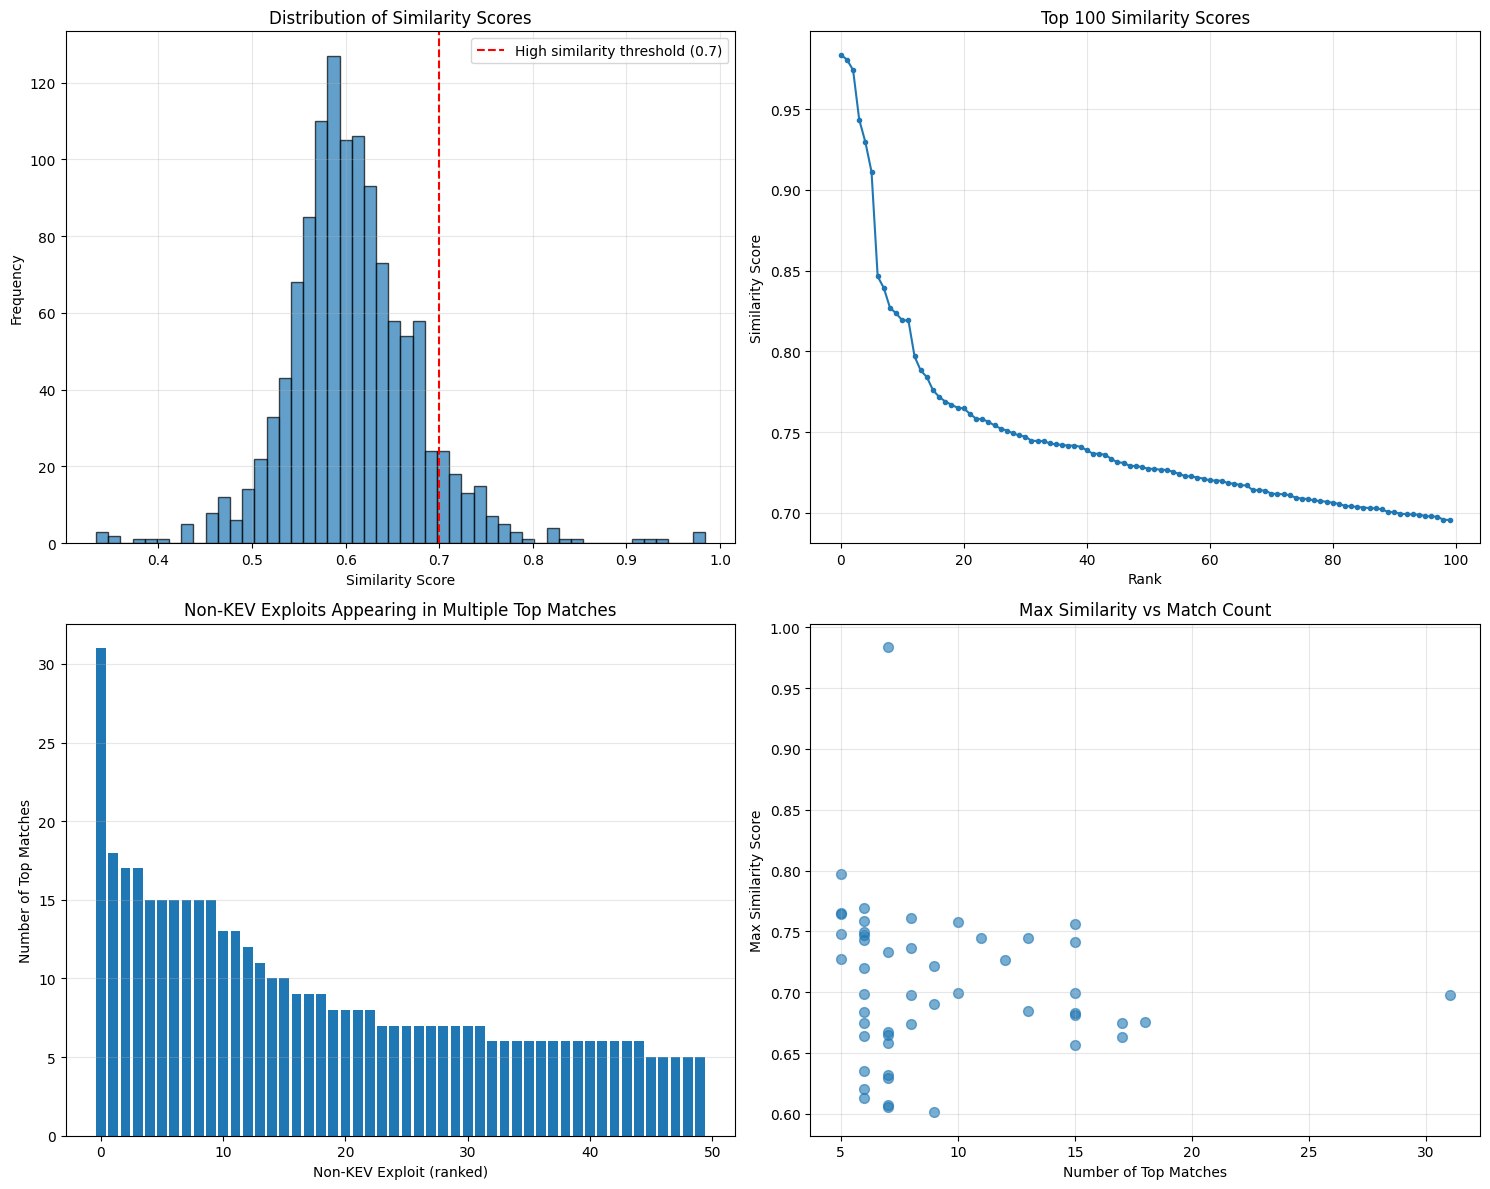


✓ Visualization saved to semantic_similarity_analysis.png
✓ Top similarity pairs saved to top_similarity_pairs.csv
✓ Non-KEV candidates saved to non_kev_candidates.csv


In [26]:
def analyze_and_visualize_similarities(similarity_results):
    """Analyze and visualize the similarity results"""
    
    if similarity_results is None:
        print("No similarity results to analyze")
        return
    
    top_similarities = similarity_results['top_similarities']
    
    print("="*60)
    print("DETAILED SIMILARITY ANALYSIS")
    print("="*60)
    
    # Find the most similar pairs
    all_pairs = []
    for kev_item in top_similarities:
        kev_cve = kev_item['kev_cve']
        for match in kev_item['top_similar_exploits']:
            all_pairs.append({
                'kev_cve': kev_cve,
                'kev_description': kev_item['kev_description'],
                'non_kev_cve': match['non_kev_cve'],
                'non_kev_description': match['non_kev_description'],
                'similarity': match['similarity_score'],
                'rank': match['rank']
            })
    
    # Sort by similarity
    all_pairs_sorted = sorted(all_pairs, key=lambda x: x['similarity'], reverse=True)
    
    # Show top 20 most similar pairs
    print("\nTop 20 Most Similar Exploit Pairs:")
    print("-" * 60)
    for i, pair in enumerate(all_pairs_sorted[:20], 1):
        print(f"\n{i}. Similarity: {pair['similarity']:.4f}")
        print(f"   KEV CVE: {pair['kev_cve']}")
        print(f"   KEV Desc: {pair['kev_description'][:80]}...")
        print(f"   Non-KEV CVE: {pair['non_kev_cve']}")
        print(f"   Non-KEV Desc: {pair['non_kev_description'][:80]}...")
    
    # Find non-KEV exploits that appear multiple times in top matches
    non_kev_appearances = {}
    for pair in all_pairs_sorted:
        non_kev_key = f"{pair['non_kev_cve']} - {pair['non_kev_description'][:50]}"
        if non_kev_key not in non_kev_appearances:
            non_kev_appearances[non_kev_key] = {
                'cve': pair['non_kev_cve'],
                'description': pair['non_kev_description'],
                'count': 0,
                'max_similarity': 0,
                'avg_similarity': 0,
                'similarities': []
            }
        non_kev_appearances[non_kev_key]['count'] += 1
        non_kev_appearances[non_kev_key]['similarities'].append(pair['similarity'])
        non_kev_appearances[non_kev_key]['max_similarity'] = max(
            non_kev_appearances[non_kev_key]['max_similarity'],
            pair['similarity']
        )
    
    # Calculate average similarities
    for key in non_kev_appearances:
        non_kev_appearances[key]['avg_similarity'] = np.mean(non_kev_appearances[key]['similarities'])
    
    # Sort by count and similarity
    top_non_kev = sorted(
        non_kev_appearances.items(),
        key=lambda x: (x[1]['count'], x[1]['max_similarity']),
        reverse=True
    )
    
    print(f"\n{'='*60}")
    print("NON-KEV EXPLOITS WITH HIGHEST SIMILARITY TO MULTIPLE KEV EXPLOITS")
    print(f"{'='*60}")
    print("(These might be candidates for KEV inclusion)")
    print("\nTop 20 non-KEV exploits that appear in multiple top matches:")
    print("-" * 60)
    
    for i, (key, data) in enumerate(top_non_kev[:20], 1):
        print(f"\n{i}. Appears in {data['count']} top matches")
        print(f"   Max similarity: {data['max_similarity']:.4f}")
        print(f"   Avg similarity: {data['avg_similarity']:.4f}")
        print(f"   CVE: {data['cve']}")
        print(f"   Description: {data['description'][:100]}...")
    
    # Create visualization
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Extract similarity scores for visualization
    similarity_scores = [pair['similarity'] for pair in all_pairs_sorted]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of similarity scores
    axes[0, 0].hist(similarity_scores, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Similarity Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Similarity Scores')
    axes[0, 0].axvline(x=0.7, color='r', linestyle='--', label='High similarity threshold (0.7)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Top similarity scores
    top_100_scores = similarity_scores[:100]
    axes[0, 1].plot(range(len(top_100_scores)), top_100_scores, marker='o', markersize=3)
    axes[0, 1].set_xlabel('Rank')
    axes[0, 1].set_ylabel('Similarity Score')
    axes[0, 1].set_title('Top 100 Similarity Scores')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Count of appearances for non-KEV exploits
    appearance_counts = [data['count'] for _, data in top_non_kev[:50]]
    axes[1, 0].bar(range(len(appearance_counts)), appearance_counts)
    axes[1, 0].set_xlabel('Non-KEV Exploit (ranked)')
    axes[1, 0].set_ylabel('Number of Top Matches')
    axes[1, 0].set_title('Non-KEV Exploits Appearing in Multiple Top Matches')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Max similarity vs count
    max_sims = [data['max_similarity'] for _, data in top_non_kev[:50]]
    counts = [data['count'] for _, data in top_non_kev[:50]]
    axes[1, 1].scatter(counts, max_sims, alpha=0.6, s=50)
    axes[1, 1].set_xlabel('Number of Top Matches')
    axes[1, 1].set_ylabel('Max Similarity Score')
    axes[1, 1].set_title('Max Similarity vs Match Count')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('semantic_similarity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved to semantic_similarity_analysis.png")
    
    # Save detailed results to CSV
    similarity_df = pd.DataFrame(all_pairs_sorted)
    similarity_df.to_csv('top_similarity_pairs.csv', index=False)
    print(f"✓ Top similarity pairs saved to top_similarity_pairs.csv")
    
    # Save non-KEV candidates
    candidates_df = pd.DataFrame([
        {
            'cve': data['cve'],
            'description': data['description'],
            'appearance_count': data['count'],
            'max_similarity': data['max_similarity'],
            'avg_similarity': data['avg_similarity']
        }
        for _, data in top_non_kev
    ])
    candidates_df.to_csv('non_kev_candidates.csv', index=False)
    print(f"✓ Non-KEV candidates saved to non_kev_candidates.csv")

# Analyze and visualize if results are available
if 'similarity_results' in locals() and similarity_results is not None:
    analyze_and_visualize_similarities(similarity_results)
else:
    print("⚠️  Run the similarity analysis cell first")


SEMANTIC SIMILARITY VISUALIZATION

Loaded 121 KEV exploits with similarity data
Statistics:
  - Max similarity mean: 0.6790
  - Max similarity median: 0.6656
  - High similarity count (>=0.7): 36


/var/folders/36/t6wnqflx2mz5tzgwpxn52wpc0000gn/T/ipykernel_567/1856817967.py:169: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax8.boxplot(box_data, labels=['All Scores', 'Max per KEV', 'Avg per KEV'],


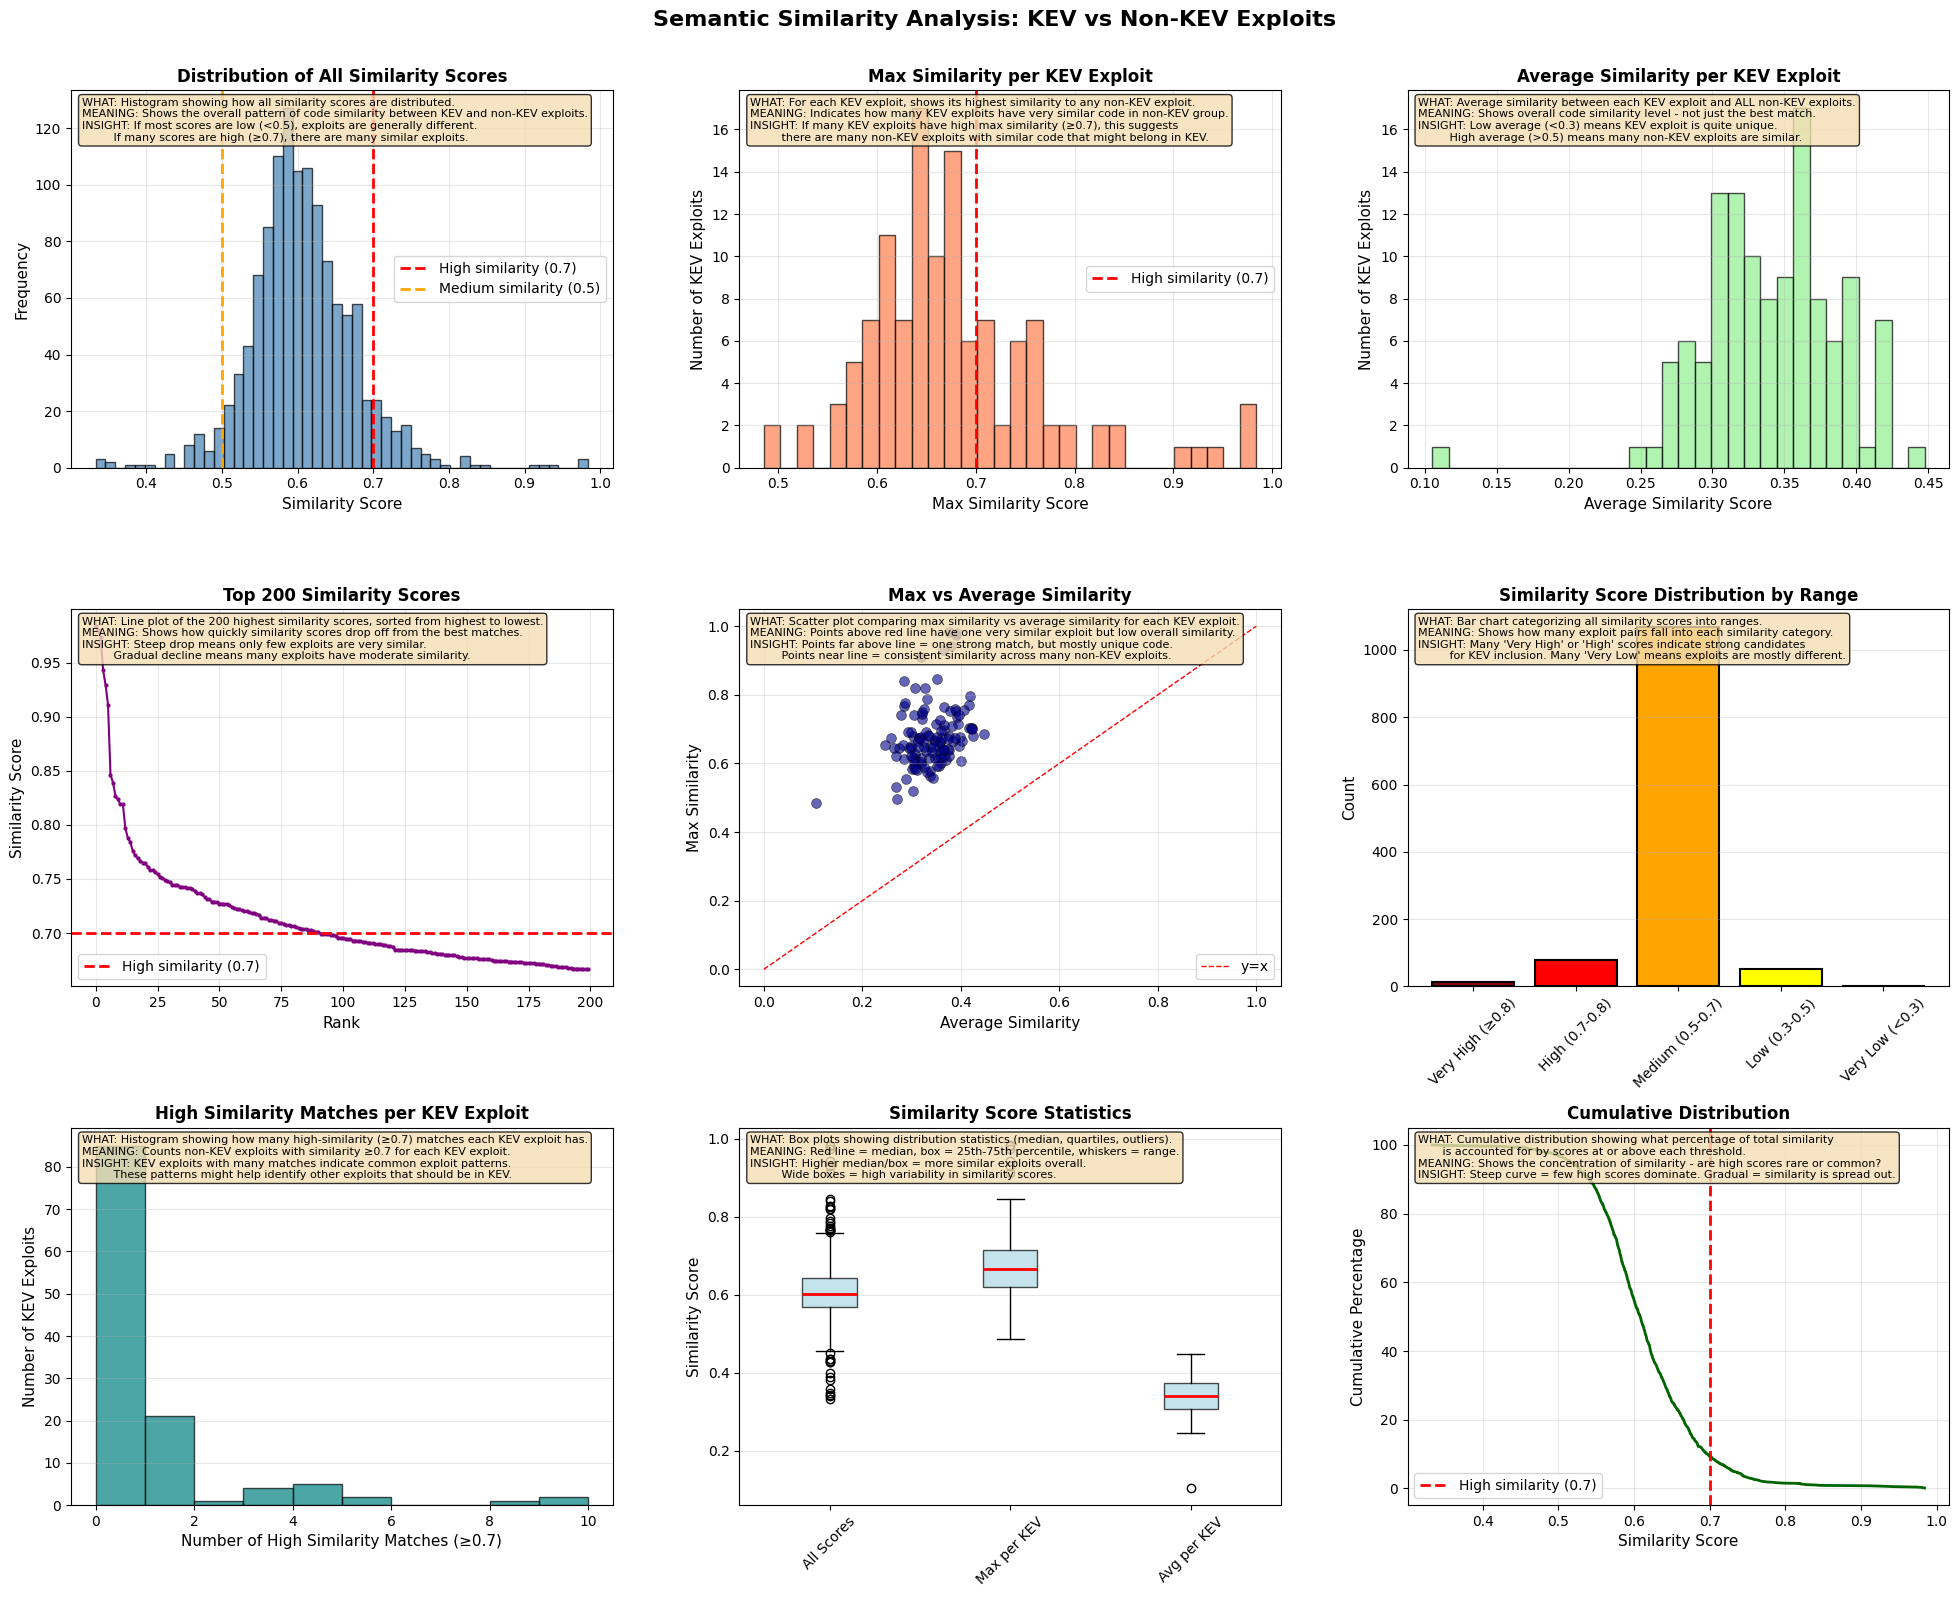


✓ Comprehensive visualization saved to semantic_similarity_comprehensive.png

SUMMARY STATISTICS
Total similarity pairs analyzed: 1210
KEV exploits analyzed: 121

Similarity Score Ranges:
  Very High (≥0.8): 12 (1.0%)
  High (0.7-0.8): 79 (6.5%)
  Medium (0.5-0.7): 1068 (88.3%)
  Low (0.3-0.5): 51 (4.2%)
  Very Low (<0.3): 0 (0.0%)


In [27]:
# Load and visualize semantic similarity results
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load results if available
try:
    with open('semantic_similarity_results.json', 'r') as f:
        similarity_data = json.load(f)
    
    print("="*60)
    print("SEMANTIC SIMILARITY VISUALIZATION")
    print("="*60)
    
    # Extract data
    top_similarities = similarity_data.get('top_similarities', [])
    stats = similarity_data.get('statistics', {})
    
    print(f"\nLoaded {len(top_similarities)} KEV exploits with similarity data")
    print(f"Statistics:")
    print(f"  - Max similarity mean: {stats.get('max_similarity_mean', 0):.4f}")
    print(f"  - Max similarity median: {stats.get('max_similarity_median', 0):.4f}")
    print(f"  - High similarity count (>=0.7): {stats.get('high_similarity_count', 0)}")
    
    # Extract all similarity scores
    all_similarity_scores = []
    for kev_item in top_similarities:
        for match in kev_item.get('top_similar_exploits', []):
            all_similarity_scores.append(match.get('similarity_score', 0))
    
    # Extract max similarities per KEV exploit
    max_similarities = [item.get('max_similarity', 0) for item in top_similarities]
    avg_similarities = [item.get('avg_similarity', 0) for item in top_similarities]
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Distribution of all similarity scores
    ax1 = plt.subplot(3, 3, 1)
    ax1.hist(all_similarity_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(x=0.7, color='r', linestyle='--', linewidth=2, label='High similarity (0.7)')
    ax1.axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Medium similarity (0.5)')
    ax1.set_xlabel('Similarity Score', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Distribution of All Similarity Scores', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    # Explanation
    explanation1 = ("WHAT: Histogram showing how all similarity scores are distributed.\n"
                   "MEANING: Shows the overall pattern of code similarity between KEV and non-KEV exploits.\n"
                   "INSIGHT: If most scores are low (<0.5), exploits are generally different.\n"
                   "         If many scores are high (≥0.7), there are many similar exploits.")
    ax1.text(0.02, 0.98, explanation1, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2. Distribution of max similarities per KEV exploit
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(max_similarities, bins=30, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(x=0.7, color='r', linestyle='--', linewidth=2, label='High similarity (0.7)')
    ax2.set_xlabel('Max Similarity Score', fontsize=11)
    ax2.set_ylabel('Number of KEV Exploits', fontsize=11)
    ax2.set_title('Max Similarity per KEV Exploit', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    # Explanation
    explanation2 = ("WHAT: For each KEV exploit, shows its highest similarity to any non-KEV exploit.\n"
                   "MEANING: Indicates how many KEV exploits have very similar code in non-KEV group.\n"
                   "INSIGHT: If many KEV exploits have high max similarity (≥0.7), this suggests\n"
                   "         there are many non-KEV exploits with similar code that might belong in KEV.")
    ax2.text(0.02, 0.98, explanation2, transform=ax2.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. Distribution of average similarities
    ax3 = plt.subplot(3, 3, 3)
    ax3.hist(avg_similarities, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    ax3.set_xlabel('Average Similarity Score', fontsize=11)
    ax3.set_ylabel('Number of KEV Exploits', fontsize=11)
    ax3.set_title('Average Similarity per KEV Exploit', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    # Explanation
    explanation3 = ("WHAT: Average similarity between each KEV exploit and ALL non-KEV exploits.\n"
                   "MEANING: Shows overall code similarity level - not just the best match.\n"
                   "INSIGHT: Low average (<0.3) means KEV exploit is quite unique.\n"
                   "         High average (>0.5) means many non-KEV exploits are similar.")
    ax3.text(0.02, 0.98, explanation3, transform=ax3.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 4. Top similarity scores (sorted)
    ax4 = plt.subplot(3, 3, 4)
    sorted_scores = sorted(all_similarity_scores, reverse=True)[:200]
    ax4.plot(range(len(sorted_scores)), sorted_scores, marker='o', markersize=2, linewidth=1.5, color='purple')
    ax4.axhline(y=0.7, color='r', linestyle='--', linewidth=2, label='High similarity (0.7)')
    ax4.set_xlabel('Rank', fontsize=11)
    ax4.set_ylabel('Similarity Score', fontsize=11)
    ax4.set_title('Top 200 Similarity Scores', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    # Explanation
    explanation4 = ("WHAT: Line plot of the 200 highest similarity scores, sorted from highest to lowest.\n"
                   "MEANING: Shows how quickly similarity scores drop off from the best matches.\n"
                   "INSIGHT: Steep drop means only few exploits are very similar.\n"
                   "         Gradual decline means many exploits have moderate similarity.")
    ax4.text(0.02, 0.98, explanation4, transform=ax4.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 5. Max vs Average similarity scatter
    ax5 = plt.subplot(3, 3, 5)
    ax5.scatter(avg_similarities, max_similarities, alpha=0.6, s=50, c='darkblue', edgecolors='black', linewidth=0.5)
    ax5.plot([0, 1], [0, 1], 'r--', linewidth=1, label='y=x')
    ax5.set_xlabel('Average Similarity', fontsize=11)
    ax5.set_ylabel('Max Similarity', fontsize=11)
    ax5.set_title('Max vs Average Similarity', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    # Explanation
    explanation5 = ("WHAT: Scatter plot comparing max similarity vs average similarity for each KEV exploit.\n"
                   "MEANING: Points above red line have one very similar exploit but low overall similarity.\n"
                   "INSIGHT: Points far above line = one strong match, but mostly unique code.\n"
                   "         Points near line = consistent similarity across many non-KEV exploits.")
    ax5.text(0.02, 0.98, explanation5, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 6. Similarity score ranges
    ax6 = plt.subplot(3, 3, 6)
    ranges = {
        'Very High (≥0.8)': sum(1 for s in all_similarity_scores if s >= 0.8),
        'High (0.7-0.8)': sum(1 for s in all_similarity_scores if 0.7 <= s < 0.8),
        'Medium (0.5-0.7)': sum(1 for s in all_similarity_scores if 0.5 <= s < 0.7),
        'Low (0.3-0.5)': sum(1 for s in all_similarity_scores if 0.3 <= s < 0.5),
        'Very Low (<0.3)': sum(1 for s in all_similarity_scores if s < 0.3)
    }
    colors = ['darkred', 'red', 'orange', 'yellow', 'lightblue']
    ax6.bar(ranges.keys(), ranges.values(), color=colors, edgecolor='black', linewidth=1.5)
    ax6.set_ylabel('Count', fontsize=11)
    ax6.set_title('Similarity Score Distribution by Range', fontsize=12, fontweight='bold')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True, alpha=0.3, axis='y')
    # Explanation
    explanation6 = ("WHAT: Bar chart categorizing all similarity scores into ranges.\n"
                   "MEANING: Shows how many exploit pairs fall into each similarity category.\n"
                   "INSIGHT: Many 'Very High' or 'High' scores indicate strong candidates\n"
                   "         for KEV inclusion. Many 'Very Low' means exploits are mostly different.")
    ax6.text(0.02, 0.98, explanation6, transform=ax6.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 7. Number of high similarity matches per KEV exploit
    ax7 = plt.subplot(3, 3, 7)
    high_sim_counts = []
    for kev_item in top_similarities:
        count = sum(1 for m in kev_item.get('top_similar_exploits', []) if m.get('similarity_score', 0) >= 0.7)
        high_sim_counts.append(count)
    ax7.hist(high_sim_counts, bins=range(0, max(high_sim_counts)+2), edgecolor='black', alpha=0.7, color='teal')
    ax7.set_xlabel('Number of High Similarity Matches (≥0.7)', fontsize=11)
    ax7.set_ylabel('Number of KEV Exploits', fontsize=11)
    ax7.set_title('High Similarity Matches per KEV Exploit', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    # Explanation
    explanation7 = ("WHAT: Histogram showing how many high-similarity (≥0.7) matches each KEV exploit has.\n"
                   "MEANING: Counts non-KEV exploits with similarity ≥0.7 for each KEV exploit.\n"
                   "INSIGHT: KEV exploits with many matches indicate common exploit patterns.\n"
                   "         These patterns might help identify other exploits that should be in KEV.")
    ax7.text(0.02, 0.98, explanation7, transform=ax7.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 8. Box plot of similarity scores
    ax8 = plt.subplot(3, 3, 8)
    box_data = [all_similarity_scores, max_similarities, avg_similarities]
    ax8.boxplot(box_data, labels=['All Scores', 'Max per KEV', 'Avg per KEV'], 
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    ax8.set_ylabel('Similarity Score', fontsize=11)
    ax8.set_title('Similarity Score Statistics', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    ax8.tick_params(axis='x', rotation=45)
    # Explanation
    explanation8 = ("WHAT: Box plots showing distribution statistics (median, quartiles, outliers).\n"
                   "MEANING: Red line = median, box = 25th-75th percentile, whiskers = range.\n"
                   "INSIGHT: Higher median/box = more similar exploits overall.\n"
                   "         Wide boxes = high variability in similarity scores.")
    ax8.text(0.02, 0.98, explanation8, transform=ax8.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 9. Cumulative distribution
    ax9 = plt.subplot(3, 3, 9)
    sorted_all = sorted(all_similarity_scores, reverse=True)
    cumulative = np.cumsum(sorted_all) / np.sum(sorted_all) * 100
    ax9.plot(sorted_all, cumulative, linewidth=2, color='darkgreen')
    ax9.axvline(x=0.7, color='r', linestyle='--', linewidth=2, label='High similarity (0.7)')
    ax9.set_xlabel('Similarity Score', fontsize=11)
    ax9.set_ylabel('Cumulative Percentage', fontsize=11)
    ax9.set_title('Cumulative Distribution', fontsize=12, fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    # Explanation
    explanation9 = ("WHAT: Cumulative distribution showing what percentage of total similarity\n"
                   "       is accounted for by scores at or above each threshold.\n"
                   "MEANING: Shows the concentration of similarity - are high scores rare or common?\n"
                   "INSIGHT: Steep curve = few high scores dominate. Gradual = similarity is spread out.")
    ax9.text(0.02, 0.98, explanation9, transform=ax9.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('Semantic Similarity Analysis: KEV vs Non-KEV Exploits', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig('semantic_similarity_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Comprehensive visualization saved to semantic_similarity_comprehensive.png")
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total similarity pairs analyzed: {len(all_similarity_scores)}")
    print(f"KEV exploits analyzed: {len(top_similarities)}")
    print(f"\nSimilarity Score Ranges:")
    for range_name, count in ranges.items():
        percentage = (count / len(all_similarity_scores) * 100) if len(all_similarity_scores) > 0 else 0
        print(f"  {range_name}: {count} ({percentage:.1f}%)")
    
except FileNotFoundError:
    print("⚠️  semantic_similarity_results.json not found")
    print("   Please run the similarity analysis first (cell 14)")
except Exception as e:
    print(f"⚠️  Error loading/visualizing results: {e}")
    import traceback
    traceback.print_exc()


NON-KEV EXPLOITS WITH HIGH SIMILARITY TO KEV EXPLOITS

Found 60 non-KEV exploits with similarity >= 0.7

Top 20 Candidates (sorted by max similarity):
--------------------------------------------------------------------------------

1. Non-KEV Exploit ID: 48128
   CVE: N/A
   Platform: php
   Description: Cacti 1.2.8 - Remote Code Execution
   Max Similarity: 0.9837
   Avg Similarity: 0.9257
   Matches with 3 KEV exploit(s):
      - CVE-2020-8813 (similarity: 0.9837)
      - CVE-2020-8813 (similarity: 0.9742)
      - CVE-2022-46169 (similarity: 0.8192)

2. Non-KEV Exploit ID: 48199
   CVE: N/A
   Platform: php
   Description: PlaySMS 1.4.3 - Template Injection / Remote Code Execution
   Max Similarity: 0.9806
   Avg Similarity: 0.9806
   Matches with 1 KEV exploit(s):
      - CVE-2020-8644 (similarity: 0.9806)

3. Non-KEV Exploit ID: 51226
   CVE: CVE-2022-31125
   Platform: python
   Description: Roxy WI v6.1.0.0 - Improper Authentication Control
   Max Similarity: 0.9434
   Avg Simil

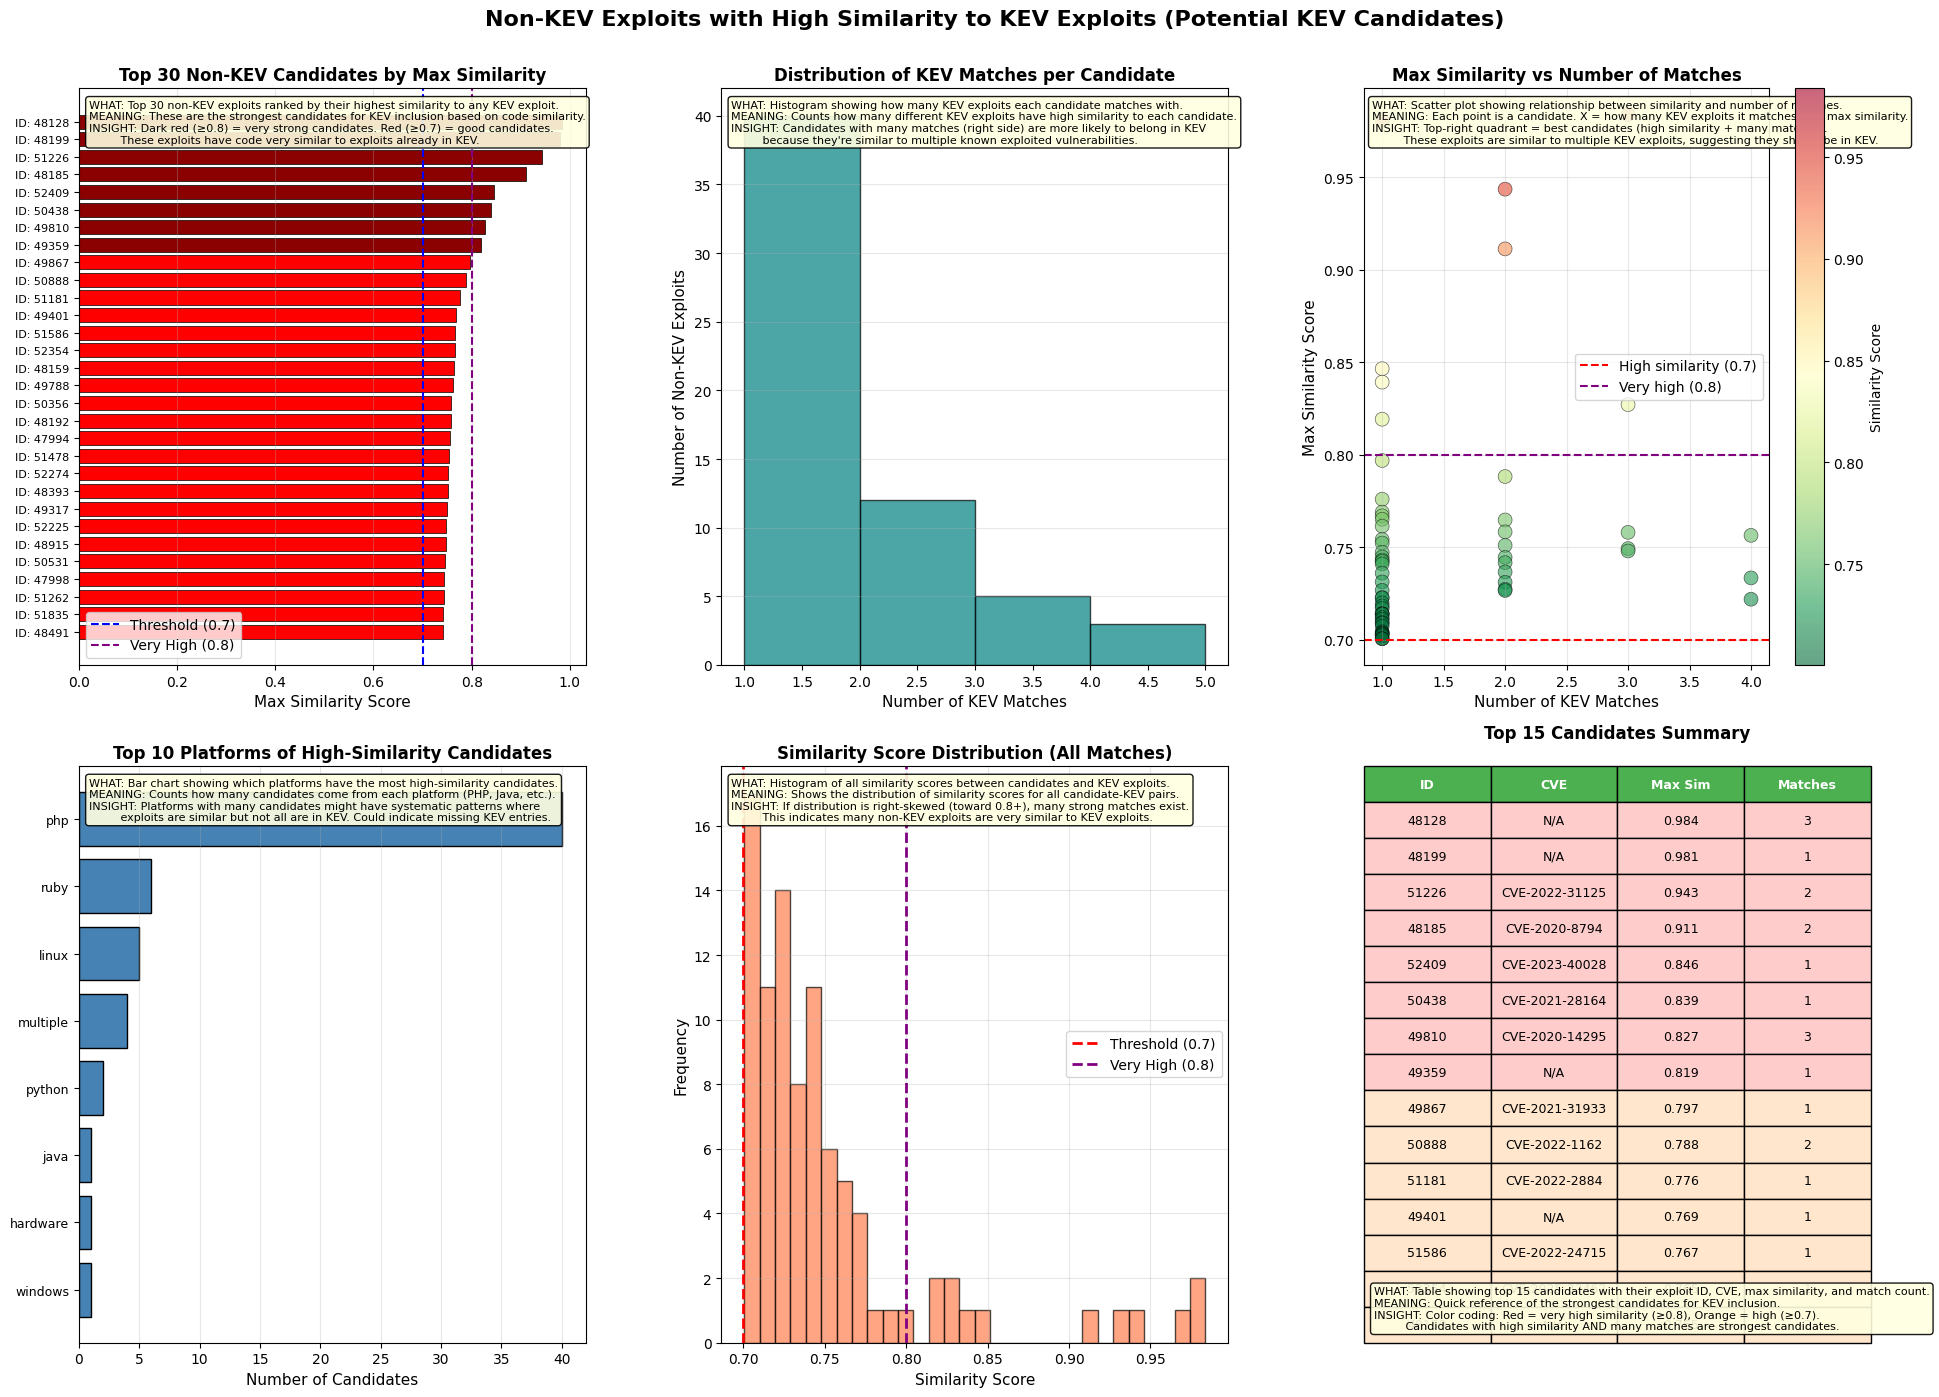


✓ Visualization saved to non_kev_high_similarity_candidates.png
✓ Detailed candidates saved to non_kev_high_similarity_candidates.csv

SUMMARY
Total non-KEV exploits with high similarity (≥0.7): 60
  - With similarity ≥ 0.8: 8
  - With similarity ≥ 0.7: 60
  - Average max similarity: 0.7558
  - Average number of matches: 1.52
  - Max number of matches: 4


In [28]:
# Identify and visualize non-KEV exploits with high similarity to KEV exploits
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

try:
    with open('semantic_similarity_results.json', 'r') as f:
        similarity_data = json.load(f)
    
    print("="*60)
    print("NON-KEV EXPLOITS WITH HIGH SIMILARITY TO KEV EXPLOITS")
    print("="*60)
    
    top_similarities = similarity_data.get('top_similarities', [])
    
    # Collect all non-KEV exploits with high similarity
    high_similarity_threshold = 0.7
    non_kev_candidates = defaultdict(lambda: {
        'cve': 'N/A',
        'description': '',
        'id': 0,
        'platform': 'N/A',
        'matches': [],
        'max_similarity': 0,
        'avg_similarity': 0,
        'match_count': 0
    })
    
    for kev_item in top_similarities:
        kev_cve = kev_item.get('kev_cve', 'N/A')
        kev_id = kev_item.get('kev_id', 0)
        kev_desc = kev_item.get('kev_description', '')
        kev_platform = kev_item.get('kev_platform', 'N/A')
        
        for match in kev_item.get('top_similar_exploits', []):
            similarity = match.get('similarity_score', 0)
            
            if similarity >= high_similarity_threshold:
                non_kev_id = match.get('non_kev_id', 0)
                non_kev_cve = match.get('non_kev_cve', 'N/A')
                non_kev_desc = match.get('non_kev_description', '')
                non_kev_platform = match.get('non_kev_platform', 'N/A')
                
                # Create unique key
                key = f"{non_kev_id}_{non_kev_cve}"
                
                # Update candidate info
                if non_kev_candidates[key]['match_count'] == 0:
                    non_kev_candidates[key]['cve'] = non_kev_cve
                    non_kev_candidates[key]['description'] = non_kev_desc
                    non_kev_candidates[key]['id'] = non_kev_id
                    non_kev_candidates[key]['platform'] = non_kev_platform
                
                # Add match
                non_kev_candidates[key]['matches'].append({
                    'kev_cve': kev_cve,
                    'kev_id': kev_id,
                    'kev_description': kev_desc,
                    'kev_platform': kev_platform,
                    'similarity': similarity
                })
                non_kev_candidates[key]['match_count'] += 1
                non_kev_candidates[key]['max_similarity'] = max(
                    non_kev_candidates[key]['max_similarity'],
                    similarity
                )
    
    # Calculate average similarities
    for key in non_kev_candidates:
        similarities = [m['similarity'] for m in non_kev_candidates[key]['matches']]
        non_kev_candidates[key]['avg_similarity'] = np.mean(similarities)
    
    # Convert to list and sort by max similarity and match count
    candidates_list = []
    for key, data in non_kev_candidates.items():
        candidates_list.append({
            'non_kev_id': data['id'],
            'non_kev_cve': data['cve'],
            'non_kev_description': data['description'][:150],
            'non_kev_platform': data['platform'],
            'max_similarity': data['max_similarity'],
            'avg_similarity': data['avg_similarity'],
            'match_count': data['match_count'],
            'matches': data['matches']
        })
    
    # Sort by max similarity (descending), then by match count
    candidates_list.sort(key=lambda x: (x['max_similarity'], x['match_count']), reverse=True)
    
    print(f"\nFound {len(candidates_list)} non-KEV exploits with similarity >= {high_similarity_threshold}")
    print(f"\nTop 20 Candidates (sorted by max similarity):")
    print("-" * 80)
    
    for i, candidate in enumerate(candidates_list[:20], 1):
        print(f"\n{i}. Non-KEV Exploit ID: {candidate['non_kev_id']}")
        print(f"   CVE: {candidate['non_kev_cve']}")
        print(f"   Platform: {candidate['non_kev_platform']}")
        print(f"   Description: {candidate['non_kev_description']}")
        print(f"   Max Similarity: {candidate['max_similarity']:.4f}")
        print(f"   Avg Similarity: {candidate['avg_similarity']:.4f}")
        print(f"   Matches with {candidate['match_count']} KEV exploit(s):")
        for match in candidate['matches'][:3]:  # Show top 3 matches
            print(f"      - {match['kev_cve']} (similarity: {match['similarity']:.4f})")
        if candidate['match_count'] > 3:
            print(f"      ... and {candidate['match_count'] - 3} more")
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 14))
    
    # 1. Top candidates by max similarity
    ax1 = plt.subplot(2, 3, 1)
    top_30 = candidates_list[:30]
    y_pos = np.arange(len(top_30))
    max_sims = [c['max_similarity'] for c in top_30]
    colors = ['darkred' if s >= 0.8 else 'red' if s >= 0.7 else 'orange' for s in max_sims]
    ax1.barh(y_pos, max_sims, color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f"ID: {c['non_kev_id']}" for c in top_30], fontsize=8)
    ax1.set_xlabel('Max Similarity Score', fontsize=11)
    ax1.set_title('Top 30 Non-KEV Candidates by Max Similarity', fontsize=12, fontweight='bold')
    ax1.axvline(x=0.7, color='blue', linestyle='--', linewidth=1.5, label='Threshold (0.7)')
    ax1.axvline(x=0.8, color='purple', linestyle='--', linewidth=1.5, label='Very High (0.8)')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    # Explanation
    explanation1 = ("WHAT: Top 30 non-KEV exploits ranked by their highest similarity to any KEV exploit.\n"
                   "MEANING: These are the strongest candidates for KEV inclusion based on code similarity.\n"
                   "INSIGHT: Dark red (≥0.8) = very strong candidates. Red (≥0.7) = good candidates.\n"
                   "         These exploits have code very similar to exploits already in KEV.")
    ax1.text(0.02, 0.98, explanation1, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 2. Match count distribution
    ax2 = plt.subplot(2, 3, 2)
    match_counts = [c['match_count'] for c in candidates_list]
    ax2.hist(match_counts, bins=range(1, max(match_counts)+2), edgecolor='black', alpha=0.7, color='teal')
    ax2.set_xlabel('Number of KEV Matches', fontsize=11)
    ax2.set_ylabel('Number of Non-KEV Exploits', fontsize=11)
    ax2.set_title('Distribution of KEV Matches per Candidate', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    # Explanation
    explanation2 = ("WHAT: Histogram showing how many KEV exploits each candidate matches with.\n"
                   "MEANING: Counts how many different KEV exploits have high similarity to each candidate.\n"
                   "INSIGHT: Candidates with many matches (right side) are more likely to belong in KEV\n"
                   "         because they're similar to multiple known exploited vulnerabilities.")
    ax2.text(0.02, 0.98, explanation2, transform=ax2.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 3. Max similarity vs match count
    ax3 = plt.subplot(2, 3, 3)
    max_sims_all = [c['max_similarity'] for c in candidates_list]
    match_counts_all = [c['match_count'] for c in candidates_list]
    scatter = ax3.scatter(match_counts_all, max_sims_all, 
                         c=max_sims_all, cmap='RdYlGn_r', 
                         s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('Number of KEV Matches', fontsize=11)
    ax3.set_ylabel('Max Similarity Score', fontsize=11)
    ax3.set_title('Max Similarity vs Number of Matches', fontsize=12, fontweight='bold')
    ax3.axhline(y=0.7, color='r', linestyle='--', linewidth=1.5, label='High similarity (0.7)')
    ax3.axhline(y=0.8, color='purple', linestyle='--', linewidth=1.5, label='Very high (0.8)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Similarity Score')
    # Explanation
    explanation3 = ("WHAT: Scatter plot showing relationship between similarity and number of matches.\n"
                   "MEANING: Each point is a candidate. X = how many KEV exploits it matches, Y = max similarity.\n"
                   "INSIGHT: Top-right quadrant = best candidates (high similarity + many matches).\n"
                   "         These exploits are similar to multiple KEV exploits, suggesting they should be in KEV.")
    ax3.text(0.02, 0.98, explanation3, transform=ax3.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 4. Platform distribution of candidates
    ax4 = plt.subplot(2, 3, 4)
    platforms = [c['non_kev_platform'] for c in candidates_list]
    platform_counts = pd.Series(platforms).value_counts().head(10)
    ax4.barh(range(len(platform_counts)), platform_counts.values, color='steelblue', edgecolor='black')
    ax4.set_yticks(range(len(platform_counts)))
    ax4.set_yticklabels(platform_counts.index, fontsize=9)
    ax4.set_xlabel('Number of Candidates', fontsize=11)
    ax4.set_title('Top 10 Platforms of High-Similarity Candidates', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3, axis='x')
    # Explanation
    explanation4 = ("WHAT: Bar chart showing which platforms have the most high-similarity candidates.\n"
                   "MEANING: Counts how many candidates come from each platform (PHP, Java, etc.).\n"
                   "INSIGHT: Platforms with many candidates might have systematic patterns where\n"
                   "         exploits are similar but not all are in KEV. Could indicate missing KEV entries.")
    ax4.text(0.02, 0.98, explanation4, transform=ax4.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 5. Similarity score distribution for candidates
    ax5 = plt.subplot(2, 3, 5)
    all_candidate_similarities = []
    for c in candidates_list:
        all_candidate_similarities.extend([m['similarity'] for m in c['matches']])
    ax5.hist(all_candidate_similarities, bins=30, edgecolor='black', alpha=0.7, color='coral')
    ax5.axvline(x=0.7, color='r', linestyle='--', linewidth=2, label='Threshold (0.7)')
    ax5.axvline(x=0.8, color='purple', linestyle='--', linewidth=2, label='Very High (0.8)')
    ax5.set_xlabel('Similarity Score', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.set_title('Similarity Score Distribution (All Matches)', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    # Explanation
    explanation5 = ("WHAT: Histogram of all similarity scores between candidates and KEV exploits.\n"
                   "MEANING: Shows the distribution of similarity scores for all candidate-KEV pairs.\n"
                   "INSIGHT: If distribution is right-skewed (toward 0.8+), many strong matches exist.\n"
                   "         This indicates many non-KEV exploits are very similar to KEV exploits.")
    ax5.text(0.02, 0.98, explanation5, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 6. Top candidates table visualization
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create table data
    table_data = []
    for i, candidate in enumerate(candidates_list[:15], 1):
        table_data.append([
            candidate['non_kev_id'],
            candidate['non_kev_cve'][:20] if candidate['non_kev_cve'] != 'N/A' else 'N/A',
            f"{candidate['max_similarity']:.3f}",
            candidate['match_count']
        ])
    
    table = ax6.table(cellText=table_data,
                     colLabels=['ID', 'CVE', 'Max Sim', 'Matches'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code by similarity
    for i in range(1, len(table_data) + 1):
        max_sim = float(table_data[i-1][2])
        if max_sim >= 0.8:
            color = '#ffcccc'
        elif max_sim >= 0.7:
            color = '#ffe6cc'
        else:
            color = '#ffffff'
        for j in range(4):
            table[(i, j)].set_facecolor(color)
    
    ax6.set_title('Top 15 Candidates Summary', fontsize=12, fontweight='bold', pad=20)
    # Explanation
    explanation6 = ("WHAT: Table showing top 15 candidates with their exploit ID, CVE, max similarity, and match count.\n"
                   "MEANING: Quick reference of the strongest candidates for KEV inclusion.\n"
                   "INSIGHT: Color coding: Red = very high similarity (≥0.8), Orange = high (≥0.7).\n"
                   "         Candidates with high similarity AND many matches are strongest candidates.")
    ax6.text(0.02, 0.02, explanation6, transform=ax6.transAxes, fontsize=8,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    plt.suptitle('Non-KEV Exploits with High Similarity to KEV Exploits (Potential KEV Candidates)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig('non_kev_high_similarity_candidates.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save detailed results to CSV
    candidates_df = pd.DataFrame([
        {
            'non_kev_id': c['non_kev_id'],
            'non_kev_cve': c['non_kev_cve'],
            'non_kev_description': c['non_kev_description'],
            'non_kev_platform': c['non_kev_platform'],
            'max_similarity': c['max_similarity'],
            'avg_similarity': c['avg_similarity'],
            'match_count': c['match_count'],
            'matched_kev_cves': '; '.join([m['kev_cve'] for m in c['matches']])
        }
        for c in candidates_list
    ])
    candidates_df.to_csv('non_kev_high_similarity_candidates.csv', index=False)
    
    print(f"\n✓ Visualization saved to non_kev_high_similarity_candidates.png")
    print(f"✓ Detailed candidates saved to non_kev_high_similarity_candidates.csv")
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY")
    print(f"{'='*60}")
    print(f"Total non-KEV exploits with high similarity (≥{high_similarity_threshold}): {len(candidates_list)}")
    print(f"  - With similarity ≥ 0.8: {sum(1 for c in candidates_list if c['max_similarity'] >= 0.8)}")
    print(f"  - With similarity ≥ 0.7: {sum(1 for c in candidates_list if c['max_similarity'] >= 0.7)}")
    print(f"  - Average max similarity: {np.mean([c['max_similarity'] for c in candidates_list]):.4f}")
    print(f"  - Average number of matches: {np.mean([c['match_count'] for c in candidates_list]):.2f}")
    print(f"  - Max number of matches: {max([c['match_count'] for c in candidates_list])}")
    
except FileNotFoundError:
    print("⚠️  semantic_similarity_results.json not found")
    print("   Please run the similarity analysis first (cell 14)")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()


Loaded CWE information for 100 CVEs from KEV data
ANALYZING HIGH SIMILARITY PAIRS (≥0.7) FOR PATTERNS

Found 91 high similarity pairs (≥0.7)

EXTRACTING CWE AND VULNERABILITY PATTERNS

CWE Analysis:
  Total CWE mentions: 0
  Unique CWEs found: 0

Vulnerability Type Analysis:
  Total vulnerability type mentions: 152
  Unique types found: 7

  Top 10 Vulnerability Types:
    RCE: 119 mentions
    XSS: 9 mentions
    SQL Injection: 8 mentions
    Privilege Escalation: 6 mentions
    Authentication Bypass: 4 mentions
    Path Traversal: 4 mentions
    Command Injection: 2 mentions

Platform Analysis:
  Same platform: 31/91 (34.1%)
  Different platform: 60/91 (65.9%)

Exploit Type Analysis:
  Same type: 74/91 (81.3%)


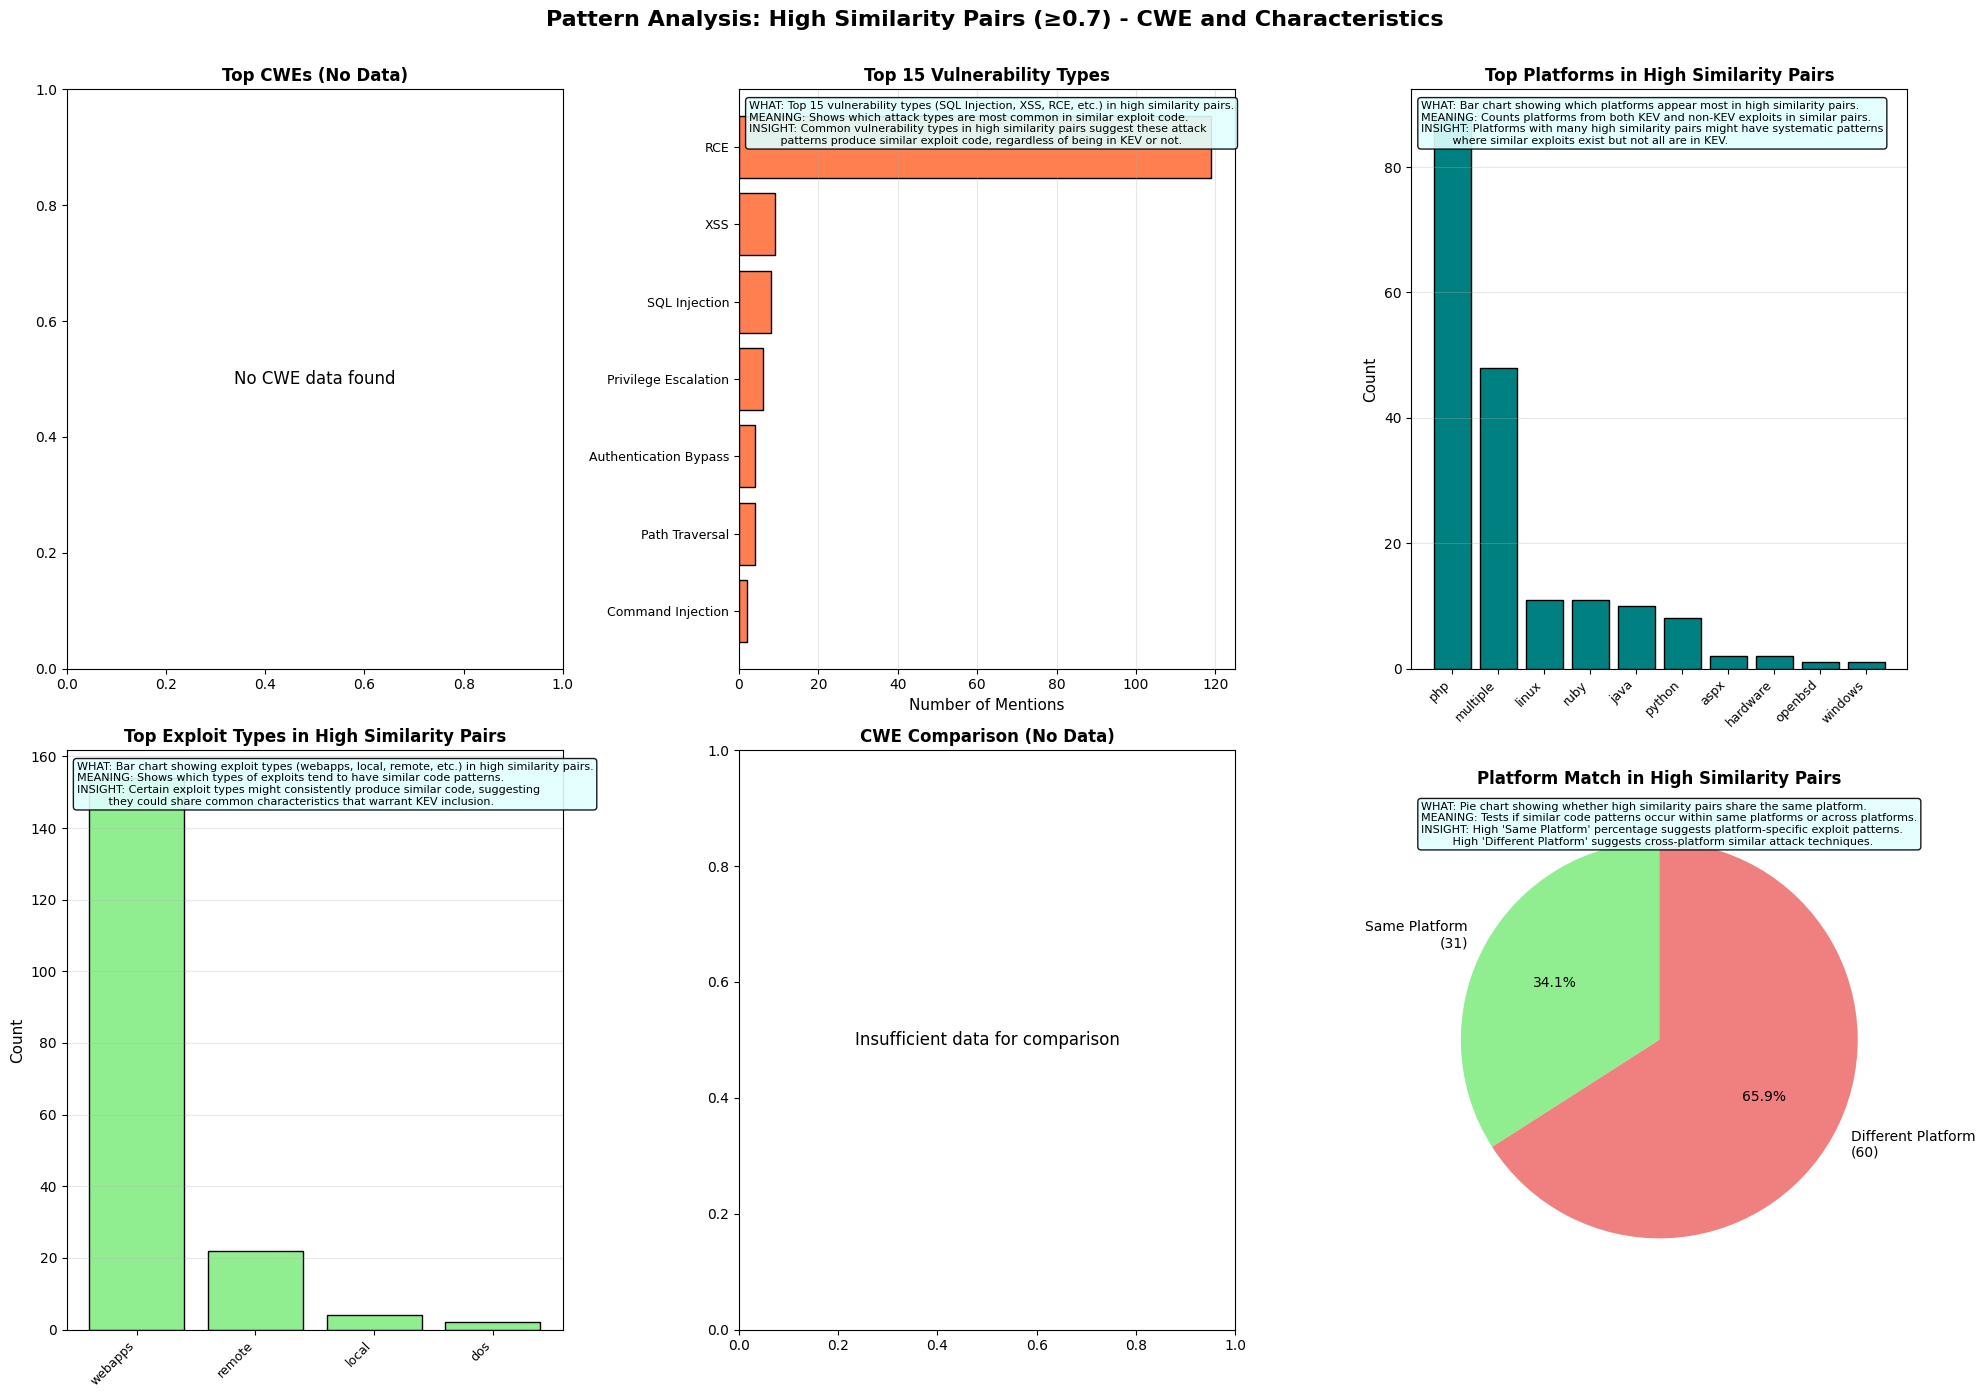


✓ Visualization saved to high_similarity_patterns_analysis.png
✓ Detailed pairs analysis saved to high_similarity_pairs_analysis.csv

SUMMARY
Total high similarity pairs analyzed: 91
Pairs with CWE information: 0 (0.0%)
Pairs with same platform: 31 (34.1%)
Pairs with same exploit type: 74 (81.3%)


In [29]:
# Analyze high similarity pairs (≥0.7) for CWE patterns and other characteristics
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
import re

try:
    with open('semantic_similarity_results.json', 'r') as f:
        similarity_data = json.load(f)
    
    # Load KEV data to get CWE information
    kev_cwe_map = {}
    try:
        with open('kev_data.json', 'r') as f:
            kev_json_data = json.load(f)
            # Extract CWE information from KEV data
            if isinstance(kev_json_data, dict) and 'data' in kev_json_data:
                for item in kev_json_data.get('data', []):
                    if 'cve' in item and 'cwes' in item:
                        cves = item.get('cve', [])
                        cwes = item.get('cwes', [])
                        for cve in cves:
                            if cve not in kev_cwe_map:
                                kev_cwe_map[cve] = []
                            kev_cwe_map[cve].extend(cwes)
        print(f"Loaded CWE information for {len(kev_cwe_map)} CVEs from KEV data")
    except Exception as e:
        print(f"Could not load CWE from KEV JSON: {e}")
    
    # Load the exploit dataframes to get additional metadata
    found_kev_df = pd.read_csv('exploits_found_in_kev.csv')
    not_found_kev_df = pd.read_csv('exploits_not_found_in_kev.csv')
    
    print("="*60)
    print("ANALYZING HIGH SIMILARITY PAIRS (≥0.7) FOR PATTERNS")
    print("="*60)
    
    top_similarities = similarity_data.get('top_similarities', [])
    high_similarity_threshold = 0.7
    
    # Extract all high similarity pairs
    high_similarity_pairs = []
    
    for kev_item in top_similarities:
        kev_id = kev_item.get('kev_id', 0)
        kev_cve = kev_item.get('kev_cve', 'N/A')
        kev_platform = kev_item.get('kev_platform', 'N/A')
        kev_desc = kev_item.get('kev_description', '')
        
        # Get additional metadata from dataframe
        kev_row = found_kev_df[found_kev_df['id'] == kev_id] if kev_id > 0 else pd.DataFrame()
        kev_type = kev_row['type'].iloc[0] if len(kev_row) > 0 and 'type' in kev_row.columns else 'N/A'
        kev_tags = kev_row['tags'].iloc[0] if len(kev_row) > 0 and 'tags' in kev_row.columns else 'N/A'
        kev_osv_summary = kev_row['osv_summary'].iloc[0] if len(kev_row) > 0 and 'osv_summary' in kev_row.columns else 'N/A'
        
        for match in kev_item.get('top_similar_exploits', []):
            similarity = match.get('similarity_score', 0)
            
            if similarity >= high_similarity_threshold:
                non_kev_id = match.get('non_kev_id', 0)
                non_kev_cve = match.get('non_kev_cve', 'N/A')
                non_kev_platform = match.get('non_kev_platform', 'N/A')
                non_kev_desc = match.get('non_kev_description', '')
                
                # Get additional metadata from dataframe
                non_kev_row = not_found_kev_df[not_found_kev_df['id'] == non_kev_id] if non_kev_id > 0 else pd.DataFrame()
                non_kev_type = non_kev_row['type'].iloc[0] if len(non_kev_row) > 0 and 'type' in non_kev_row.columns else 'N/A'
                non_kev_tags = non_kev_row['tags'].iloc[0] if len(non_kev_row) > 0 and 'tags' in non_kev_row.columns else 'N/A'
                non_kev_osv_summary = non_kev_row['osv_summary'].iloc[0] if len(non_kev_row) > 0 and 'osv_summary' in non_kev_row.columns else 'N/A'
                
                # Get CWE from KEV data if available
                kev_cwes_from_data = kev_cwe_map.get(kev_cve, [])
                
                high_similarity_pairs.append({
                    'similarity': similarity,
                    'kev_id': kev_id,
                    'kev_cve': kev_cve,
                    'kev_platform': kev_platform,
                    'kev_type': kev_type,
                    'kev_tags': kev_tags,
                    'kev_description': kev_desc,
                    'kev_osv_summary': kev_osv_summary,
                    'kev_cwes_from_kev_data': '; '.join(kev_cwes_from_data) if kev_cwes_from_data else 'N/A',
                    'non_kev_id': non_kev_id,
                    'non_kev_cve': non_kev_cve,
                    'non_kev_platform': non_kev_platform,
                    'non_kev_type': non_kev_type,
                    'non_kev_tags': non_kev_tags,
                    'non_kev_description': non_kev_desc,
                    'non_kev_osv_summary': non_kev_osv_summary
                })
    
    print(f"\nFound {len(high_similarity_pairs)} high similarity pairs (≥{high_similarity_threshold})")
    
    # Extract CWE patterns from various sources
    def extract_cwe(text):
        """Extract CWE IDs from text (CWE-XXX format)"""
        if pd.isna(text) or text == '' or text == 'N/A':
            return []
        text_str = str(text).upper()
        # Pattern for CWE-XXX or CWE-XXXX
        cwe_pattern = r'CWE-(\d{1,4})'
        matches = re.findall(cwe_pattern, text_str)
        return [f"CWE-{cwe}" for cwe in matches]
    
    def extract_vulnerability_types(text):
        """Extract common vulnerability type keywords"""
        if pd.isna(text) or text == '' or text == 'N/A':
            return []
        text_lower = str(text).lower()
        vuln_types = []
        
        # Common vulnerability patterns
        patterns = {
            'SQL Injection': ['sql injection', 'sqli', 'sql-injection'],
            'XSS': ['xss', 'cross-site scripting', 'cross site scripting'],
            'RCE': ['remote code execution', 'rce', 'code execution'],
            'LFI/RFI': ['local file inclusion', 'lfi', 'remote file inclusion', 'rfi', 'file inclusion'],
            'Command Injection': ['command injection', 'os command', 'shell injection'],
            'Authentication Bypass': ['auth bypass', 'authentication bypass', 'login bypass'],
            'Privilege Escalation': ['privilege escalation', 'privesc', 'privilege'],
            'Buffer Overflow': ['buffer overflow', 'stack overflow', 'heap overflow'],
            'XXE': ['xxe', 'xml external entity', 'xml injection'],
            'SSRF': ['ssrf', 'server-side request forgery', 'server side request'],
            'Deserialization': ['deserialization', 'unserialize', 'pickle'],
            'Path Traversal': ['path traversal', 'directory traversal', '../']
        }
        
        for vuln_type, keywords in patterns.items():
            if any(keyword in text_lower for keyword in keywords):
                vuln_types.append(vuln_type)
        
        return vuln_types
    
    # Analyze CWE patterns
    print("\n" + "="*60)
    print("EXTRACTING CWE AND VULNERABILITY PATTERNS")
    print("="*60)
    
    all_cwes = []
    all_vuln_types = []
    platform_pairs = []
    type_pairs = []
    
    for pair in high_similarity_pairs:
        # Extract CWE from various fields
        cwes = []
        # First, try to get CWE from KEV data (most reliable)
        if pair.get('kev_cwes_from_kev_data', 'N/A') != 'N/A':
            kev_cwes_str = pair['kev_cwes_from_kev_data']
            cwes.extend(extract_cwe(kev_cwes_str))
        # Also extract from text fields
        cwes.extend(extract_cwe(pair['kev_description']))
        cwes.extend(extract_cwe(pair['kev_tags']))
        cwes.extend(extract_cwe(pair['kev_osv_summary']))
        cwes.extend(extract_cwe(pair['non_kev_description']))
        cwes.extend(extract_cwe(pair['non_kev_tags']))
        cwes.extend(extract_cwe(pair['non_kev_osv_summary']))
        all_cwes.extend(cwes)
        
        # Extract vulnerability types
        vuln_types = []
        vuln_types.extend(extract_vulnerability_types(pair['kev_description']))
        vuln_types.extend(extract_vulnerability_types(pair['kev_tags']))
        vuln_types.extend(extract_vulnerability_types(pair['non_kev_description']))
        vuln_types.extend(extract_vulnerability_types(pair['non_kev_tags']))
        all_vuln_types.extend(vuln_types)
        
        # Platform and type pairs
        platform_pairs.append((pair['kev_platform'], pair['non_kev_platform']))
        type_pairs.append((pair['kev_type'], pair['non_kev_type']))
    
    # Count CWE occurrences
    cwe_counts = Counter(all_cwes)
    vuln_type_counts = Counter(all_vuln_types)
    
    print(f"\nCWE Analysis:")
    print(f"  Total CWE mentions: {len(all_cwes)}")
    print(f"  Unique CWEs found: {len(cwe_counts)}")
    if len(cwe_counts) > 0:
        print(f"\n  Top 10 CWEs:")
        for cwe, count in cwe_counts.most_common(10):
            print(f"    {cwe}: {count} mentions")
    
    print(f"\nVulnerability Type Analysis:")
    print(f"  Total vulnerability type mentions: {len(all_vuln_types)}")
    print(f"  Unique types found: {len(vuln_type_counts)}")
    if len(vuln_type_counts) > 0:
        print(f"\n  Top 10 Vulnerability Types:")
        for vtype, count in vuln_type_counts.most_common(10):
            print(f"    {vtype}: {count} mentions")
    
    # Platform analysis
    print(f"\nPlatform Analysis:")
    kev_platforms = [p[0] for p in platform_pairs]
    non_kev_platforms = [p[1] for p in platform_pairs]
    same_platform = sum(1 for p in platform_pairs if p[0] == p[1])
    print(f"  Same platform: {same_platform}/{len(platform_pairs)} ({same_platform/len(platform_pairs)*100:.1f}%)")
    print(f"  Different platform: {len(platform_pairs) - same_platform}/{len(platform_pairs)} ({(len(platform_pairs) - same_platform)/len(platform_pairs)*100:.1f}%)")
    
    # Type analysis
    print(f"\nExploit Type Analysis:")
    kev_types = [t[0] for t in type_pairs]
    non_kev_types = [t[1] for t in type_pairs]
    same_type = sum(1 for t in type_pairs if t[0] == t[1] and t[0] != 'N/A')
    print(f"  Same type: {same_type}/{len(type_pairs)} ({same_type/len(type_pairs)*100:.1f}%)")
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 14))
    
    # 1. Top CWEs
    ax1 = plt.subplot(2, 3, 1)
    if len(cwe_counts) > 0:
        top_cwes = cwe_counts.most_common(15)
        cwe_names = [c[0] for c in top_cwes]
        cwe_values = [c[1] for c in top_cwes]
        ax1.barh(range(len(cwe_names)), cwe_values, color='steelblue', edgecolor='black')
        ax1.set_yticks(range(len(cwe_names)))
        ax1.set_yticklabels(cwe_names, fontsize=9)
        ax1.set_xlabel('Number of Mentions', fontsize=11)
        ax1.set_title('Top 15 CWEs in High Similarity Pairs', fontsize=12, fontweight='bold')
        ax1.invert_yaxis()
        ax1.grid(True, alpha=0.3, axis='x')
        # Explanation
        explanation1 = ("WHAT: Top 15 CWE (Common Weakness Enumeration) IDs found in high similarity pairs.\n"
                       "MEANING: Shows which vulnerability types are most common in similar exploits.\n"
                       "INSIGHT: High frequency CWEs indicate common patterns in exploits that share\n"
                       "         similar code. These CWEs might be indicators for KEV inclusion.")
        ax1.text(0.02, 0.98, explanation1, transform=ax1.transAxes, fontsize=8,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    else:
        ax1.text(0.5, 0.5, 'No CWE data found', ha='center', va='center', fontsize=12)
        ax1.set_title('Top CWEs (No Data)', fontsize=12, fontweight='bold')
    
    # 2. Vulnerability Types
    ax2 = plt.subplot(2, 3, 2)
    if len(vuln_type_counts) > 0:
        top_vulns = vuln_type_counts.most_common(15)
        vuln_names = [v[0] for v in top_vulns]
        vuln_values = [v[1] for v in top_vulns]
        ax2.barh(range(len(vuln_names)), vuln_values, color='coral', edgecolor='black')
        ax2.set_yticks(range(len(vuln_names)))
        ax2.set_yticklabels(vuln_names, fontsize=9)
        ax2.set_xlabel('Number of Mentions', fontsize=11)
        ax2.set_title('Top 15 Vulnerability Types', fontsize=12, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(True, alpha=0.3, axis='x')
        # Explanation
        explanation2 = ("WHAT: Top 15 vulnerability types (SQL Injection, XSS, RCE, etc.) in high similarity pairs.\n"
                       "MEANING: Shows which attack types are most common in similar exploit code.\n"
                       "INSIGHT: Common vulnerability types in high similarity pairs suggest these attack\n"
                       "         patterns produce similar exploit code, regardless of being in KEV or not.")
        ax2.text(0.02, 0.98, explanation2, transform=ax2.transAxes, fontsize=8,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    else:
        ax2.text(0.5, 0.5, 'No vulnerability type data found', ha='center', va='center', fontsize=12)
        ax2.set_title('Vulnerability Types (No Data)', fontsize=12, fontweight='bold')
    
    # 3. Platform comparison
    ax3 = plt.subplot(2, 3, 3)
    platform_counts = Counter(kev_platforms + non_kev_platforms)
    top_platforms = platform_counts.most_common(10)
    platform_names = [p[0] for p in top_platforms]
    platform_values = [p[1] for p in top_platforms]
    ax3.bar(range(len(platform_names)), platform_values, color='teal', edgecolor='black')
    ax3.set_xticks(range(len(platform_names)))
    ax3.set_xticklabels(platform_names, rotation=45, ha='right', fontsize=9)
    ax3.set_ylabel('Count', fontsize=11)
    ax3.set_title('Top Platforms in High Similarity Pairs', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    # Explanation
    explanation3 = ("WHAT: Bar chart showing which platforms appear most in high similarity pairs.\n"
                   "MEANING: Counts platforms from both KEV and non-KEV exploits in similar pairs.\n"
                   "INSIGHT: Platforms with many high similarity pairs might have systematic patterns\n"
                   "         where similar exploits exist but not all are in KEV.")
    ax3.text(0.02, 0.98, explanation3, transform=ax3.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 4. Exploit type comparison
    ax4 = plt.subplot(2, 3, 4)
    type_counts = Counter([t for t in kev_types + non_kev_types if t != 'N/A'])
    top_types = type_counts.most_common(10)
    if len(top_types) > 0:
        type_names = [t[0] for t in top_types]
        type_values = [t[1] for t in top_types]
        ax4.bar(range(len(type_names)), type_values, color='lightgreen', edgecolor='black')
        ax4.set_xticks(range(len(type_names)))
        ax4.set_xticklabels(type_names, rotation=45, ha='right', fontsize=9)
        ax4.set_ylabel('Count', fontsize=11)
        ax4.set_title('Top Exploit Types in High Similarity Pairs', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        # Explanation
        explanation4 = ("WHAT: Bar chart showing exploit types (webapps, local, remote, etc.) in high similarity pairs.\n"
                       "MEANING: Shows which types of exploits tend to have similar code patterns.\n"
                       "INSIGHT: Certain exploit types might consistently produce similar code, suggesting\n"
                       "         they could share common characteristics that warrant KEV inclusion.")
        ax4.text(0.02, 0.98, explanation4, transform=ax4.transAxes, fontsize=8,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    else:
        ax4.text(0.5, 0.5, 'No type data available', ha='center', va='center', fontsize=12)
        ax4.set_title('Exploit Types (No Data)', fontsize=12, fontweight='bold')
    
    # 5. Similarity distribution for pairs with/without CWE
    ax5 = plt.subplot(2, 3, 5)
    # Check for CWE in multiple sources
    pairs_with_cwe = []
    pairs_without_cwe = []
    for p in high_similarity_pairs:
        has_cwe = False
        # Check KEV data CWE
        if p.get('kev_cwes_from_kev_data', 'N/A') != 'N/A' and len(extract_cwe(p['kev_cwes_from_kev_data'])) > 0:
            has_cwe = True
        # Check extracted CWE from text
        if len(extract_cwe(p['kev_description']) + extract_cwe(p['non_kev_description']) + 
               extract_cwe(p['kev_tags']) + extract_cwe(p['non_kev_tags'])) > 0:
            has_cwe = True
        
        if has_cwe:
            pairs_with_cwe.append(p)
        else:
            pairs_without_cwe.append(p)
    
    if len(pairs_with_cwe) > 0 and len(pairs_without_cwe) > 0:
        sims_with_cwe = [p['similarity'] for p in pairs_with_cwe]
        sims_without_cwe = [p['similarity'] for p in pairs_without_cwe]
        ax5.hist([sims_with_cwe, sims_without_cwe], bins=20, label=['With CWE', 'Without CWE'], 
                alpha=0.7, edgecolor='black', color=['darkblue', 'lightblue'])
        ax5.set_xlabel('Similarity Score', fontsize=11)
        ax5.set_ylabel('Frequency', fontsize=11)
        ax5.set_title('Similarity Distribution: With vs Without CWE', fontsize=12, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        # Explanation
        explanation5 = ("WHAT: Comparison of similarity scores for pairs with vs without CWE information.\n"
                       "MEANING: Tests if pairs with CWE data have different similarity patterns.\n"
                       "INSIGHT: If pairs with CWE have higher similarity, CWE might be a good indicator\n"
                       "         for identifying exploits that should be in KEV.")
        ax5.text(0.02, 0.98, explanation5, transform=ax5.transAxes, fontsize=8,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    else:
        ax5.text(0.5, 0.5, 'Insufficient data for comparison', ha='center', va='center', fontsize=12)
        ax5.set_title('CWE Comparison (No Data)', fontsize=12, fontweight='bold')
    
    # 6. Platform match analysis
    ax6 = plt.subplot(2, 3, 6)
    same_platform_count = same_platform
    diff_platform_count = len(platform_pairs) - same_platform
    ax6.pie([same_platform_count, diff_platform_count], 
           labels=[f'Same Platform\n({same_platform_count})', f'Different Platform\n({diff_platform_count})'],
           autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'],
           textprops={'fontsize': 10})
    ax6.set_title('Platform Match in High Similarity Pairs', fontsize=12, fontweight='bold')
    # Explanation
    explanation6 = ("WHAT: Pie chart showing whether high similarity pairs share the same platform.\n"
                   "MEANING: Tests if similar code patterns occur within same platforms or across platforms.\n"
                   "INSIGHT: High 'Same Platform' percentage suggests platform-specific exploit patterns.\n"
                   "         High 'Different Platform' suggests cross-platform similar attack techniques.")
    ax6.text(0.02, 0.98, explanation6, transform=ax6.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    plt.suptitle('Pattern Analysis: High Similarity Pairs (≥0.7) - CWE and Characteristics', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig('high_similarity_patterns_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save detailed results
    pairs_df = pd.DataFrame(high_similarity_pairs)
    # Extract CWE and vulnerability types for both KEV and non-KEV
    pairs_df['cwe_kev'] = pairs_df.apply(lambda row: '; '.join(set(extract_cwe(str(row.get('kev_cwes_from_kev_data', '')) + ' ' + 
                                                                                str(row.get('kev_description', '')) + ' ' + 
                                                                                str(row.get('kev_tags', ''))))), axis=1)
    pairs_df['cwe_non_kev'] = pairs_df.apply(lambda row: '; '.join(extract_cwe(str(row.get('non_kev_description', '')) + ' ' + 
                                                                               str(row.get('non_kev_tags', '')))), axis=1)
    pairs_df['vuln_type_kev'] = pairs_df.apply(lambda row: '; '.join(set(extract_vulnerability_types(str(row.get('kev_description', '')) + ' ' + 
                                                                                                      str(row.get('kev_tags', ''))))), axis=1)
    pairs_df['vuln_type_non_kev'] = pairs_df.apply(lambda row: '; '.join(set(extract_vulnerability_types(str(row.get('non_kev_description', '')) + ' ' + 
                                                                                                          str(row.get('non_kev_tags', ''))))), axis=1)
    
    pairs_df.to_csv('high_similarity_pairs_analysis.csv', index=False)
    
    print(f"\n✓ Visualization saved to high_similarity_patterns_analysis.png")
    print(f"✓ Detailed pairs analysis saved to high_similarity_pairs_analysis.csv")
    
    # Summary
    print(f"\n{'='*60}")
    print("SUMMARY")
    print(f"{'='*60}")
    print(f"Total high similarity pairs analyzed: {len(high_similarity_pairs)}")
    print(f"Pairs with CWE information: {len(pairs_with_cwe)} ({len(pairs_with_cwe)/len(high_similarity_pairs)*100:.1f}%)")
    print(f"Pairs with same platform: {same_platform} ({same_platform/len(platform_pairs)*100:.1f}%)")
    print(f"Pairs with same exploit type: {same_type} ({same_type/len(type_pairs)*100:.1f}%)")
    
except FileNotFoundError as e:
    print(f"⚠️  File not found: {e}")
    print("   Please ensure semantic_similarity_results.json and CSV files exist")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()


SIMILARITY MATRIX AND ADDITIONAL INSIGHTS

Building similarity matrix...
Matrix size: 120 KEV exploits x 459 non-KEV exploits

Finding top similarity pairs...
Total pairs with similarity > 0: 1193

Top 10 Highest Similarity Pairs:
----------------------------------------------------------------------------------------------------

1. Similarity: 0.9837
   KEV: ID 48144 | CVE: CVE-2020-8813 | Platform: multiple
        Description: Cacti 1.2.8 - Authenticated Remote Code Execution...
   Non-KEV: ID 48128 | CVE: N/A | Platform: php
            Description: Cacti 1.2.8 - Remote Code Execution...

2. Similarity: 0.9806
   KEV: ID 48335 | CVE: CVE-2020-8644 | Platform: php
        Description: PlaySMS - index.php Unauthenticated Template Injec...
   Non-KEV: ID 48199 | CVE: N/A | Platform: php
            Description: PlaySMS 1.4.3 - Template Injection / Remote Code E...

3. Similarity: 0.9742
   KEV: ID 48145 | CVE: CVE-2020-8813 | Platform: multiple
        Description: Cacti 1.2.8 - Unau

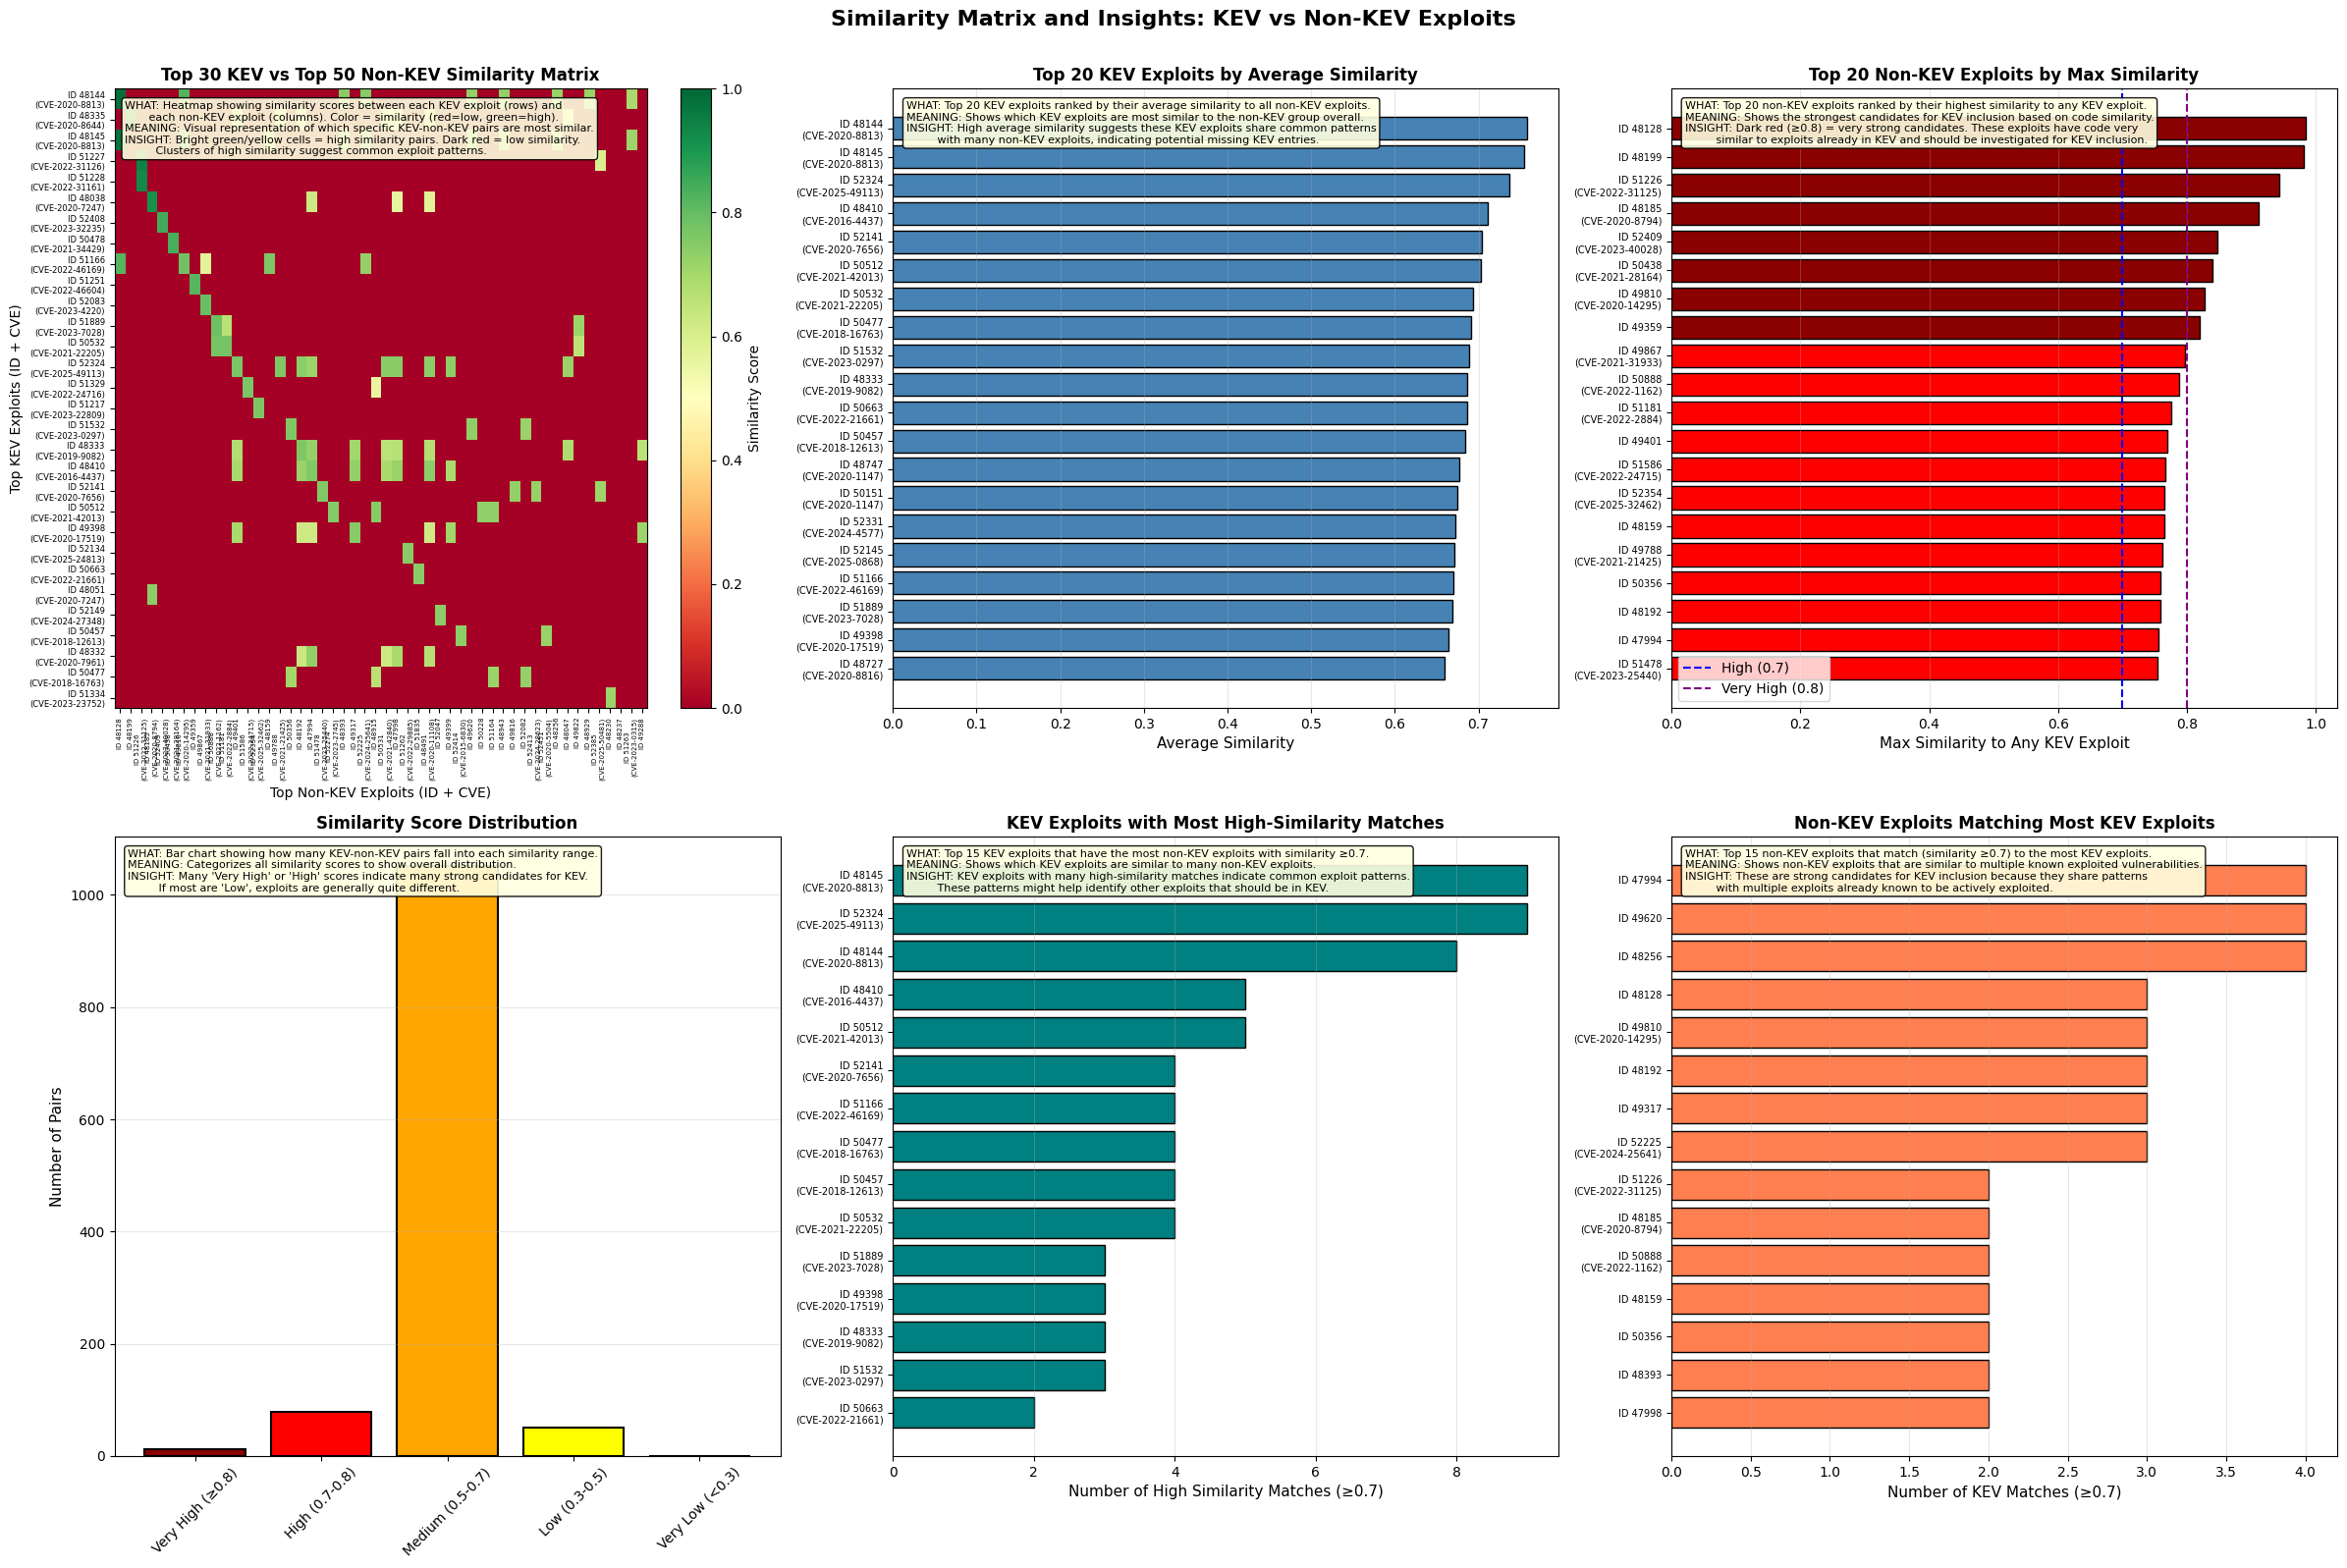


✓ Visualization saved to similarity_matrix_and_insights.png
✓ Full similarity matrix saved to similarity_matrix.csv
✓ Top 100 pairs saved to top_similarity_pairs_matrix.csv

ADDITIONAL INSIGHTS

1. KEV Exploits with Highest Max Similarity:
   1. KEV ID 48144 | CVE: CVE-2020-8813 | Max similarity: 0.9837
   2. KEV ID 48335 | CVE: CVE-2020-8644 | Max similarity: 0.9806
   3. KEV ID 48145 | CVE: CVE-2020-8813 | Max similarity: 0.9742
   4. KEV ID 51227 | CVE: CVE-2022-31126 | Max similarity: 0.9434
   5. KEV ID 51228 | CVE: CVE-2022-31161 | Max similarity: 0.9296

2. Non-KEV Exploits with Highest Max Similarity (Top Candidates):
   1. Non-KEV ID 48128 | CVE: No CVE | Max similarity: 0.9837
   2. Non-KEV ID 48199 | CVE: No CVE | Max similarity: 0.9806
   3. Non-KEV ID 51226 | CVE: CVE-2022-31125 | Max similarity: 0.9434
   4. Non-KEV ID 48185 | CVE: CVE-2020-8794 | Max similarity: 0.9112
   5. Non-KEV ID 52409 | CVE: CVE-2023-40028 | Max similarity: 0.8464

3. Most Connected Non-KEV Explo

In [32]:
# Create similarity matrix/heatmap and find additional insights
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

try:
    with open('semantic_similarity_results.json', 'r') as f:
        similarity_data = json.load(f)
    
    # Load exploit dataframes
    found_kev_df = pd.read_csv('exploits_found_in_kev.csv')
    not_found_kev_df = pd.read_csv('exploits_not_found_in_kev.csv')
    
    print("="*60)
    print("SIMILARITY MATRIX AND ADDITIONAL INSIGHTS")
    print("="*60)
    
    top_similarities = similarity_data.get('top_similarities', [])
    
    # Build similarity matrix: KEV exploits (rows) vs Non-KEV exploits (columns)
    print("\nBuilding similarity matrix...")
    
    # Create mappings
    kev_id_to_index = {}
    non_kev_id_to_index = {}
    kev_index_to_info = {}
    non_kev_index_to_info = {}
    
    # Map KEV exploits - use sequential index starting from 0
    kev_idx_counter = 0
    for kev_item in top_similarities:
        kev_id = kev_item.get('kev_id', 0)
        if kev_id > 0 and kev_id not in kev_id_to_index:  # Only add if not already added
            kev_id_to_index[kev_id] = kev_idx_counter
            kev_index_to_info[kev_idx_counter] = {
                'id': kev_id,
                'cve': kev_item.get('kev_cve', 'N/A'),
                'description': kev_item.get('kev_description', '')[:50],
                'platform': kev_item.get('kev_platform', 'N/A')
            }
            kev_idx_counter += 1
    
    # Map non-KEV exploits from all matches
    non_kev_ids = set()
    for kev_item in top_similarities:
        for match in kev_item.get('top_similar_exploits', []):
            non_kev_id = match.get('non_kev_id', 0)
            if non_kev_id > 0:
                non_kev_ids.add(non_kev_id)
    
    non_kev_ids = sorted(list(non_kev_ids))
    for idx, non_kev_id in enumerate(non_kev_ids):
        non_kev_id_to_index[non_kev_id] = idx
        # Get info from dataframe
        non_kev_row = not_found_kev_df[not_found_kev_df['id'] == non_kev_id] if non_kev_id > 0 else pd.DataFrame()
        if len(non_kev_row) > 0:
            # Try to get CVE from multiple sources
            cve_value = 'N/A'
            if 'extracted_cves' in non_kev_row.columns and pd.notna(non_kev_row['extracted_cves'].iloc[0]):
                cves_list = non_kev_row['extracted_cves'].iloc[0]
                if isinstance(cves_list, list) and len(cves_list) > 0:
                    cve_value = ', '.join(cves_list[:3])  # Take first 3 CVEs
                elif isinstance(cves_list, str) and cves_list.strip():
                    cve_value = cves_list
            elif 'codes' in non_kev_row.columns and pd.notna(non_kev_row['codes'].iloc[0]):
                cve_value = str(non_kev_row['codes'].iloc[0])
            
            non_kev_index_to_info[idx] = {
                'id': non_kev_id,
                'cve': cve_value,
                'description': str(non_kev_row['description'].iloc[0])[:50] if 'description' in non_kev_row.columns and pd.notna(non_kev_row['description'].iloc[0]) else 'N/A',
                'platform': str(non_kev_row['platform'].iloc[0]) if 'platform' in non_kev_row.columns and pd.notna(non_kev_row['platform'].iloc[0]) else 'N/A'
            }
        else:
            non_kev_index_to_info[idx] = {
                'id': non_kev_id,
                'cve': 'N/A',
                'description': 'N/A',
                'platform': 'N/A'
            }
    
    # Build similarity matrix
    n_kev = len(kev_id_to_index)
    n_non_kev = len(non_kev_id_to_index)
    similarity_matrix = np.zeros((n_kev, n_non_kev))
    
    print(f"Matrix size: {n_kev} KEV exploits x {n_non_kev} non-KEV exploits")
    
    for kev_item in top_similarities:
        kev_id = kev_item.get('kev_id', 0)
        if kev_id in kev_id_to_index:
            kev_idx = kev_id_to_index[kev_id]
            # Safety check: ensure index is within bounds
            if kev_idx < n_kev:
                for match in kev_item.get('top_similar_exploits', []):
                    non_kev_id = match.get('non_kev_id', 0)
                    similarity = match.get('similarity_score', 0)
                    if non_kev_id in non_kev_id_to_index:
                        non_kev_idx = non_kev_id_to_index[non_kev_id]
                        # Safety check: ensure indices are within bounds
                        if non_kev_idx < n_non_kev:
                            similarity_matrix[kev_idx, non_kev_idx] = similarity
    
    # Find top pairs for detailed analysis
    print("\nFinding top similarity pairs...")
    top_pairs = []
    for i in range(n_kev):
        for j in range(n_non_kev):
            sim = similarity_matrix[i, j]
            if sim > 0:
                top_pairs.append({
                    'similarity': sim,
                    'kev_idx': i,
                    'non_kev_idx': j,
                    'kev_info': kev_index_to_info[i],
                    'non_kev_info': non_kev_index_to_info[j]
                })
    
    top_pairs.sort(key=lambda x: x['similarity'], reverse=True)
    
    print(f"Total pairs with similarity > 0: {len(top_pairs)}")
    print(f"\nTop 10 Highest Similarity Pairs:")
    print("-" * 100)
    for i, pair in enumerate(top_pairs[:10], 1):
        kev = pair['kev_info']
        non_kev = pair['non_kev_info']
        print(f"\n{i}. Similarity: {pair['similarity']:.4f}")
        print(f"   KEV: ID {kev['id']} | CVE: {kev['cve']} | Platform: {kev['platform']}")
        print(f"        Description: {kev['description']}...")
        print(f"   Non-KEV: ID {non_kev['id']} | CVE: {non_kev['cve']} | Platform: {non_kev['platform']}")
        print(f"            Description: {non_kev['description']}...")
    
    # Helper function to format labels with ID and CVE
    def format_label(info_dict):
        """Format label as 'ID {id} ({cve})' or just 'ID {id}' if CVE is N/A"""
        cve = info_dict.get('cve', 'N/A')
        if cve and cve != 'N/A' and str(cve).strip():
            # Extract first CVE if multiple
            cve_str = str(cve).split(',')[0].split(';')[0].strip()
            return f"ID {info_dict['id']}\n({cve_str})"
        else:
            return f"ID {info_dict['id']}"
    
    # Create visualizations
    fig = plt.figure(figsize=(24, 16))
    
    # 1. Full similarity heatmap (if not too large)
    ax1 = plt.subplot(2, 3, 1)
    if n_kev <= 50 and n_non_kev <= 100:
        # Show full matrix
        im1 = ax1.imshow(similarity_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        ax1.set_xlabel('Non-KEV Exploits (ID + CVE)', fontsize=10)
        ax1.set_ylabel('KEV Exploits (ID + CVE)', fontsize=10)
        ax1.set_title('Full Similarity Matrix (KEV vs Non-KEV)', fontsize=12, fontweight='bold')
        
        # Set labels with CVE
        kev_labels = [format_label(kev_index_to_info[i]) for i in range(n_kev)]
        non_kev_labels = [format_label(non_kev_index_to_info[j]) for j in range(min(50, n_non_kev))]
        
        ax1.set_yticks(range(n_kev))
        ax1.set_yticklabels(kev_labels, fontsize=6)
        ax1.set_xticks(range(min(50, n_non_kev)))
        ax1.set_xticklabels(non_kev_labels, fontsize=5, rotation=90)
        plt.colorbar(im1, ax=ax1, label='Similarity Score')
    else:
        # Show top KEV and top non-KEV only
        top_n_kev = min(30, n_kev)
        top_n_non_kev = min(50, n_non_kev)
        
        # Get top KEV exploits (by max similarity)
        kev_max_sims = [(i, np.max(similarity_matrix[i, :])) for i in range(n_kev)]
        kev_max_sims.sort(key=lambda x: x[1], reverse=True)
        top_kev_indices = [x[0] for x in kev_max_sims[:top_n_kev]]
        
        # Get top non-KEV exploits (by max similarity)
        non_kev_max_sims = [(j, np.max(similarity_matrix[:, j])) for j in range(n_non_kev)]
        non_kev_max_sims.sort(key=lambda x: x[1], reverse=True)
        top_non_kev_indices = [x[0] for x in non_kev_max_sims[:top_n_non_kev]]
        
        sub_matrix = similarity_matrix[np.ix_(top_kev_indices, top_non_kev_indices)]
        
        im1 = ax1.imshow(sub_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        ax1.set_xlabel('Top Non-KEV Exploits (ID + CVE)', fontsize=10)
        ax1.set_ylabel('Top KEV Exploits (ID + CVE)', fontsize=10)
        ax1.set_title(f'Top {top_n_kev} KEV vs Top {top_n_non_kev} Non-KEV Similarity Matrix', 
                      fontsize=12, fontweight='bold')
        
        kev_labels = [format_label(kev_index_to_info[i]) for i in top_kev_indices]
        non_kev_labels = [format_label(non_kev_index_to_info[j]) for j in top_non_kev_indices]
        
        ax1.set_yticks(range(len(top_kev_indices)))
        ax1.set_yticklabels(kev_labels, fontsize=6)
        ax1.set_xticks(range(len(top_non_kev_indices)))
        ax1.set_xticklabels(non_kev_labels, fontsize=5, rotation=90)
        plt.colorbar(im1, ax=ax1, label='Similarity Score')
    
    # Explanation
    explanation1 = ("WHAT: Heatmap showing similarity scores between each KEV exploit (rows) and\n"
                   "       each non-KEV exploit (columns). Color = similarity (red=low, green=high).\n"
                   "MEANING: Visual representation of which specific KEV-non-KEV pairs are most similar.\n"
                   "INSIGHT: Bright green/yellow cells = high similarity pairs. Dark red = low similarity.\n"
                   "         Clusters of high similarity suggest common exploit patterns.")
    ax1.text(0.02, 0.98, explanation1, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 2. Top KEV exploits by average similarity
    ax2 = plt.subplot(2, 3, 2)
    kev_avg_sims = [(i, np.mean(similarity_matrix[i, :][similarity_matrix[i, :] > 0])) 
                    for i in range(n_kev) if np.any(similarity_matrix[i, :] > 0)]
    kev_avg_sims.sort(key=lambda x: x[1], reverse=True)
    top_20_kev = kev_avg_sims[:20]
    
    kev_infos_avg = [kev_index_to_info[x[0]] for x in top_20_kev]
    avg_sims = [x[1] for x in top_20_kev]
    
    ax2.barh(range(len(kev_infos_avg)), avg_sims, color='steelblue', edgecolor='black')
    ax2.set_yticks(range(len(kev_infos_avg)))
    ax2.set_yticklabels([format_label(info) for info in kev_infos_avg], fontsize=7)
    ax2.set_xlabel('Average Similarity', fontsize=11)
    ax2.set_title('Top 20 KEV Exploits by Average Similarity', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    # Explanation
    explanation2 = ("WHAT: Top 20 KEV exploits ranked by their average similarity to all non-KEV exploits.\n"
                   "MEANING: Shows which KEV exploits are most similar to the non-KEV group overall.\n"
                   "INSIGHT: High average similarity suggests these KEV exploits share common patterns\n"
                   "         with many non-KEV exploits, indicating potential missing KEV entries.")
    ax2.text(0.02, 0.98, explanation2, transform=ax2.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 3. Top non-KEV exploits by max similarity
    ax3 = plt.subplot(2, 3, 3)
    non_kev_max_sims = [(j, np.max(similarity_matrix[:, j])) for j in range(n_non_kev) 
                        if np.any(similarity_matrix[:, j] > 0)]
    non_kev_max_sims.sort(key=lambda x: x[1], reverse=True)
    top_20_non_kev = non_kev_max_sims[:20]
    
    non_kev_infos_max = [non_kev_index_to_info[x[0]] for x in top_20_non_kev]
    max_sims = [x[1] for x in top_20_non_kev]
    
    colors_max = ['darkred' if s >= 0.8 else 'red' if s >= 0.7 else 'orange' for s in max_sims]
    ax3.barh(range(len(non_kev_infos_max)), max_sims, color=colors_max, edgecolor='black')
    ax3.set_yticks(range(len(non_kev_infos_max)))
    ax3.set_yticklabels([format_label(info) for info in non_kev_infos_max], fontsize=7)
    ax3.set_xlabel('Max Similarity to Any KEV Exploit', fontsize=11)
    ax3.set_title('Top 20 Non-KEV Exploits by Max Similarity', fontsize=12, fontweight='bold')
    ax3.axvline(x=0.7, color='blue', linestyle='--', linewidth=1.5, label='High (0.7)')
    ax3.axvline(x=0.8, color='purple', linestyle='--', linewidth=1.5, label='Very High (0.8)')
    ax3.legend()
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3, axis='x')
    # Explanation
    explanation3 = ("WHAT: Top 20 non-KEV exploits ranked by their highest similarity to any KEV exploit.\n"
                   "MEANING: Shows the strongest candidates for KEV inclusion based on code similarity.\n"
                   "INSIGHT: Dark red (≥0.8) = very strong candidates. These exploits have code very\n"
                   "         similar to exploits already in KEV and should be investigated for KEV inclusion.")
    ax3.text(0.02, 0.98, explanation3, transform=ax3.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 4. Similarity distribution by similarity ranges
    ax4 = plt.subplot(2, 3, 4)
    all_sims = similarity_matrix[similarity_matrix > 0].flatten()
    ranges = {
        'Very High (≥0.8)': np.sum(all_sims >= 0.8),
        'High (0.7-0.8)': np.sum((all_sims >= 0.7) & (all_sims < 0.8)),
        'Medium (0.5-0.7)': np.sum((all_sims >= 0.5) & (all_sims < 0.7)),
        'Low (0.3-0.5)': np.sum((all_sims >= 0.3) & (all_sims < 0.5)),
        'Very Low (<0.3)': np.sum(all_sims < 0.3)
    }
    colors_range = ['darkred', 'red', 'orange', 'yellow', 'lightblue']
    ax4.bar(ranges.keys(), ranges.values(), color=colors_range, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Number of Pairs', fontsize=11)
    ax4.set_title('Similarity Score Distribution', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    # Explanation
    explanation4 = ("WHAT: Bar chart showing how many KEV-non-KEV pairs fall into each similarity range.\n"
                   "MEANING: Categorizes all similarity scores to show overall distribution.\n"
                   "INSIGHT: Many 'Very High' or 'High' scores indicate many strong candidates for KEV.\n"
                   "         If most are 'Low', exploits are generally quite different.")
    ax4.text(0.02, 0.98, explanation4, transform=ax4.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 5. KEV exploits with most high-similarity matches
    ax5 = plt.subplot(2, 3, 5)
    kev_high_sim_counts = []
    for i in range(n_kev):
        count = np.sum(similarity_matrix[i, :] >= 0.7)
        if count > 0:
            kev_high_sim_counts.append({
                'info': kev_index_to_info[i],
                'count': count
            })
    kev_high_sim_counts.sort(key=lambda x: x['count'], reverse=True)
    top_15_kev = kev_high_sim_counts[:15]
    
    kev_infos_count = [x['info'] for x in top_15_kev]
    counts = [x['count'] for x in top_15_kev]
    
    ax5.barh(range(len(kev_infos_count)), counts, color='teal', edgecolor='black')
    ax5.set_yticks(range(len(kev_infos_count)))
    ax5.set_yticklabels([format_label(info) for info in kev_infos_count], fontsize=7)
    ax5.set_xlabel('Number of High Similarity Matches (≥0.7)', fontsize=11)
    ax5.set_title('KEV Exploits with Most High-Similarity Matches', fontsize=12, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')
    # Explanation
    explanation5 = ("WHAT: Top 15 KEV exploits that have the most non-KEV exploits with similarity ≥0.7.\n"
                   "MEANING: Shows which KEV exploits are similar to many non-KEV exploits.\n"
                   "INSIGHT: KEV exploits with many high-similarity matches indicate common exploit patterns.\n"
                   "         These patterns might help identify other exploits that should be in KEV.")
    ax5.text(0.02, 0.98, explanation5, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    # 6. Non-KEV exploits matched to most KEV exploits
    ax6 = plt.subplot(2, 3, 6)
    non_kev_match_counts = []
    for j in range(n_non_kev):
        count = np.sum(similarity_matrix[:, j] >= 0.7)
        if count > 0:
            non_kev_match_counts.append({
                'info': non_kev_index_to_info[j],
                'count': count,
                'max_sim': np.max(similarity_matrix[:, j])
            })
    non_kev_match_counts.sort(key=lambda x: (x['count'], x['max_sim']), reverse=True)
    top_15_non_kev = non_kev_match_counts[:15]
    
    non_kev_infos_count = [x['info'] for x in top_15_non_kev]
    match_counts = [x['count'] for x in top_15_non_kev]
    
    ax6.barh(range(len(non_kev_infos_count)), match_counts, color='coral', edgecolor='black')
    ax6.set_yticks(range(len(non_kev_infos_count)))
    ax6.set_yticklabels([format_label(info) for info in non_kev_infos_count], fontsize=7)
    ax6.set_xlabel('Number of KEV Matches (≥0.7)', fontsize=11)
    ax6.set_title('Non-KEV Exploits Matching Most KEV Exploits', fontsize=12, fontweight='bold')
    ax6.invert_yaxis()
    ax6.grid(True, alpha=0.3, axis='x')
    # Explanation
    explanation6 = ("WHAT: Top 15 non-KEV exploits that match (similarity ≥0.7) to the most KEV exploits.\n"
                   "MEANING: Shows non-KEV exploits that are similar to multiple known exploited vulnerabilities.\n"
                   "INSIGHT: These are strong candidates for KEV inclusion because they share patterns\n"
                   "         with multiple exploits already known to be actively exploited.")
    ax6.text(0.02, 0.98, explanation6, transform=ax6.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    plt.suptitle('Similarity Matrix and Insights: KEV vs Non-KEV Exploits', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig('similarity_matrix_and_insights.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save detailed matrix data
    matrix_df = pd.DataFrame(similarity_matrix, 
                            index=[f"KEV_{kev_index_to_info[i]['id']}" for i in range(n_kev)],
                            columns=[f"NonKEV_{non_kev_index_to_info[j]['id']}" for j in range(n_non_kev)])
    matrix_df.to_csv('similarity_matrix.csv')
    
    # Save top pairs
    top_pairs_df = pd.DataFrame([
        {
            'similarity': p['similarity'],
            'kev_id': p['kev_info']['id'],
            'kev_cve': p['kev_info']['cve'],
            'kev_platform': p['kev_info']['platform'],
            'kev_description': p['kev_info']['description'],
            'non_kev_id': p['non_kev_info']['id'],
            'non_kev_cve': p['non_kev_info']['cve'],
            'non_kev_platform': p['non_kev_info']['platform'],
            'non_kev_description': p['non_kev_info']['description']
        }
        for p in top_pairs[:100]  # Top 100 pairs
    ])
    top_pairs_df.to_csv('top_similarity_pairs_matrix.csv', index=False)
    
    print(f"\n✓ Visualization saved to similarity_matrix_and_insights.png")
    print(f"✓ Full similarity matrix saved to similarity_matrix.csv")
    print(f"✓ Top 100 pairs saved to top_similarity_pairs_matrix.csv")
    
    # Additional insights
    print(f"\n{'='*60}")
    print("ADDITIONAL INSIGHTS")
    print(f"{'='*60}")
    
    # Insight 1: KEV exploits with highest max similarity
    kev_max_sims = [(i, np.max(similarity_matrix[i, :])) for i in range(n_kev)]
    kev_max_sims_sorted = sorted(kev_max_sims, key=lambda x: x[1], reverse=True)
    print(f"\n1. KEV Exploits with Highest Max Similarity:")
    for i, (idx, max_sim) in enumerate(kev_max_sims_sorted[:5], 1):
        info = kev_index_to_info[idx]
        cve_str = info['cve'] if info['cve'] != 'N/A' else 'No CVE'
        print(f"   {i}. KEV ID {info['id']} | CVE: {cve_str} | Max similarity: {max_sim:.4f}")
    
    # Insight 2: Non-KEV exploits with highest max similarity
    non_kev_max_sims = [(j, np.max(similarity_matrix[:, j])) for j in range(n_non_kev) 
                        if np.any(similarity_matrix[:, j] > 0)]
    non_kev_max_sims_sorted = sorted(non_kev_max_sims, key=lambda x: x[1], reverse=True)
    print(f"\n2. Non-KEV Exploits with Highest Max Similarity (Top Candidates):")
    for i, (idx, max_sim) in enumerate(non_kev_max_sims_sorted[:5], 1):
        info = non_kev_index_to_info[idx]
        cve_str = info['cve'] if info['cve'] != 'N/A' else 'No CVE'
        print(f"   {i}. Non-KEV ID {info['id']} | CVE: {cve_str} | Max similarity: {max_sim:.4f}")
    
    # Insight 3: Most connected pairs
    print(f"\n3. Most Connected Non-KEV Exploits (match multiple KEV exploits):")
    for i, item in enumerate(non_kev_match_counts[:5], 1):
        info = item['info']
        cve_str = info['cve'] if info['cve'] != 'N/A' else 'No CVE'
        print(f"   {i}. Non-KEV ID {info['id']} | CVE: {cve_str} | Matches {item['count']} KEV exploits (max sim: {item['max_sim']:.4f})")
    
    # Insight 4: Similarity statistics
    print(f"\n4. Similarity Statistics:")
    print(f"   - Total pairs with similarity > 0: {len(all_sims)}")
    print(f"   - Mean similarity: {np.mean(all_sims):.4f}")
    print(f"   - Median similarity: {np.median(all_sims):.4f}")
    print(f"   - Max similarity: {np.max(all_sims):.4f}")
    print(f"   - Pairs with similarity ≥ 0.8: {np.sum(all_sims >= 0.8)} ({np.sum(all_sims >= 0.8)/len(all_sims)*100:.1f}%)")
    print(f"   - Pairs with similarity ≥ 0.7: {np.sum(all_sims >= 0.7)} ({np.sum(all_sims >= 0.7)/len(all_sims)*100:.1f}%)")
    
except FileNotFoundError as e:
    print(f"⚠️  File not found: {e}")
    print("   Please ensure semantic_similarity_results.json and CSV files exist")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()


METADATA FEATURE ANALYSIS FOR SIMILARITY PREDICTION

Found similarity scores for 459 non-KEV exploits

Extracting metadata features...

Extracted 27 features for 459 exploits
Features: ['platform', 'type', 'port', 'description_length', 'has_cve_in_desc', 'has_sql_injection', 'has_xss', 'has_rce', 'has_lfi_rfi', 'has_command_injection', 'has_auth_bypass', 'has_privesc', 'has_buffer_overflow', 'has_xxe', 'has_ssrf', 'has_deserialization', 'has_path_traversal', 'has_tags', 'tags_length', 'num_cves', 'has_cve', 'has_osv_summary', 'osv_summary_length', 'year', 'years_since_2020', 'exploit_id', 'avg_similarity']

FEATURE CORRELATION ANALYSIS

Top 15 Features Correlated with Average Similarity:
------------------------------------------------------------
  has_tags                      :  0.1091
  tags_length                   :  0.1060
  has_osv_summary               :  0.0845
  has_auth_bypass               :  0.0759
  has_sql_injection             :  0.0641
  description_length            

/var/folders/36/t6wnqflx2mz5tzgwpxn52wpc0000gn/T/ipykernel_567/3814293979.py:369: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_bin_stats = features_df.groupby('desc_length_bin')['avg_similarity'].agg(['mean', 'count'])


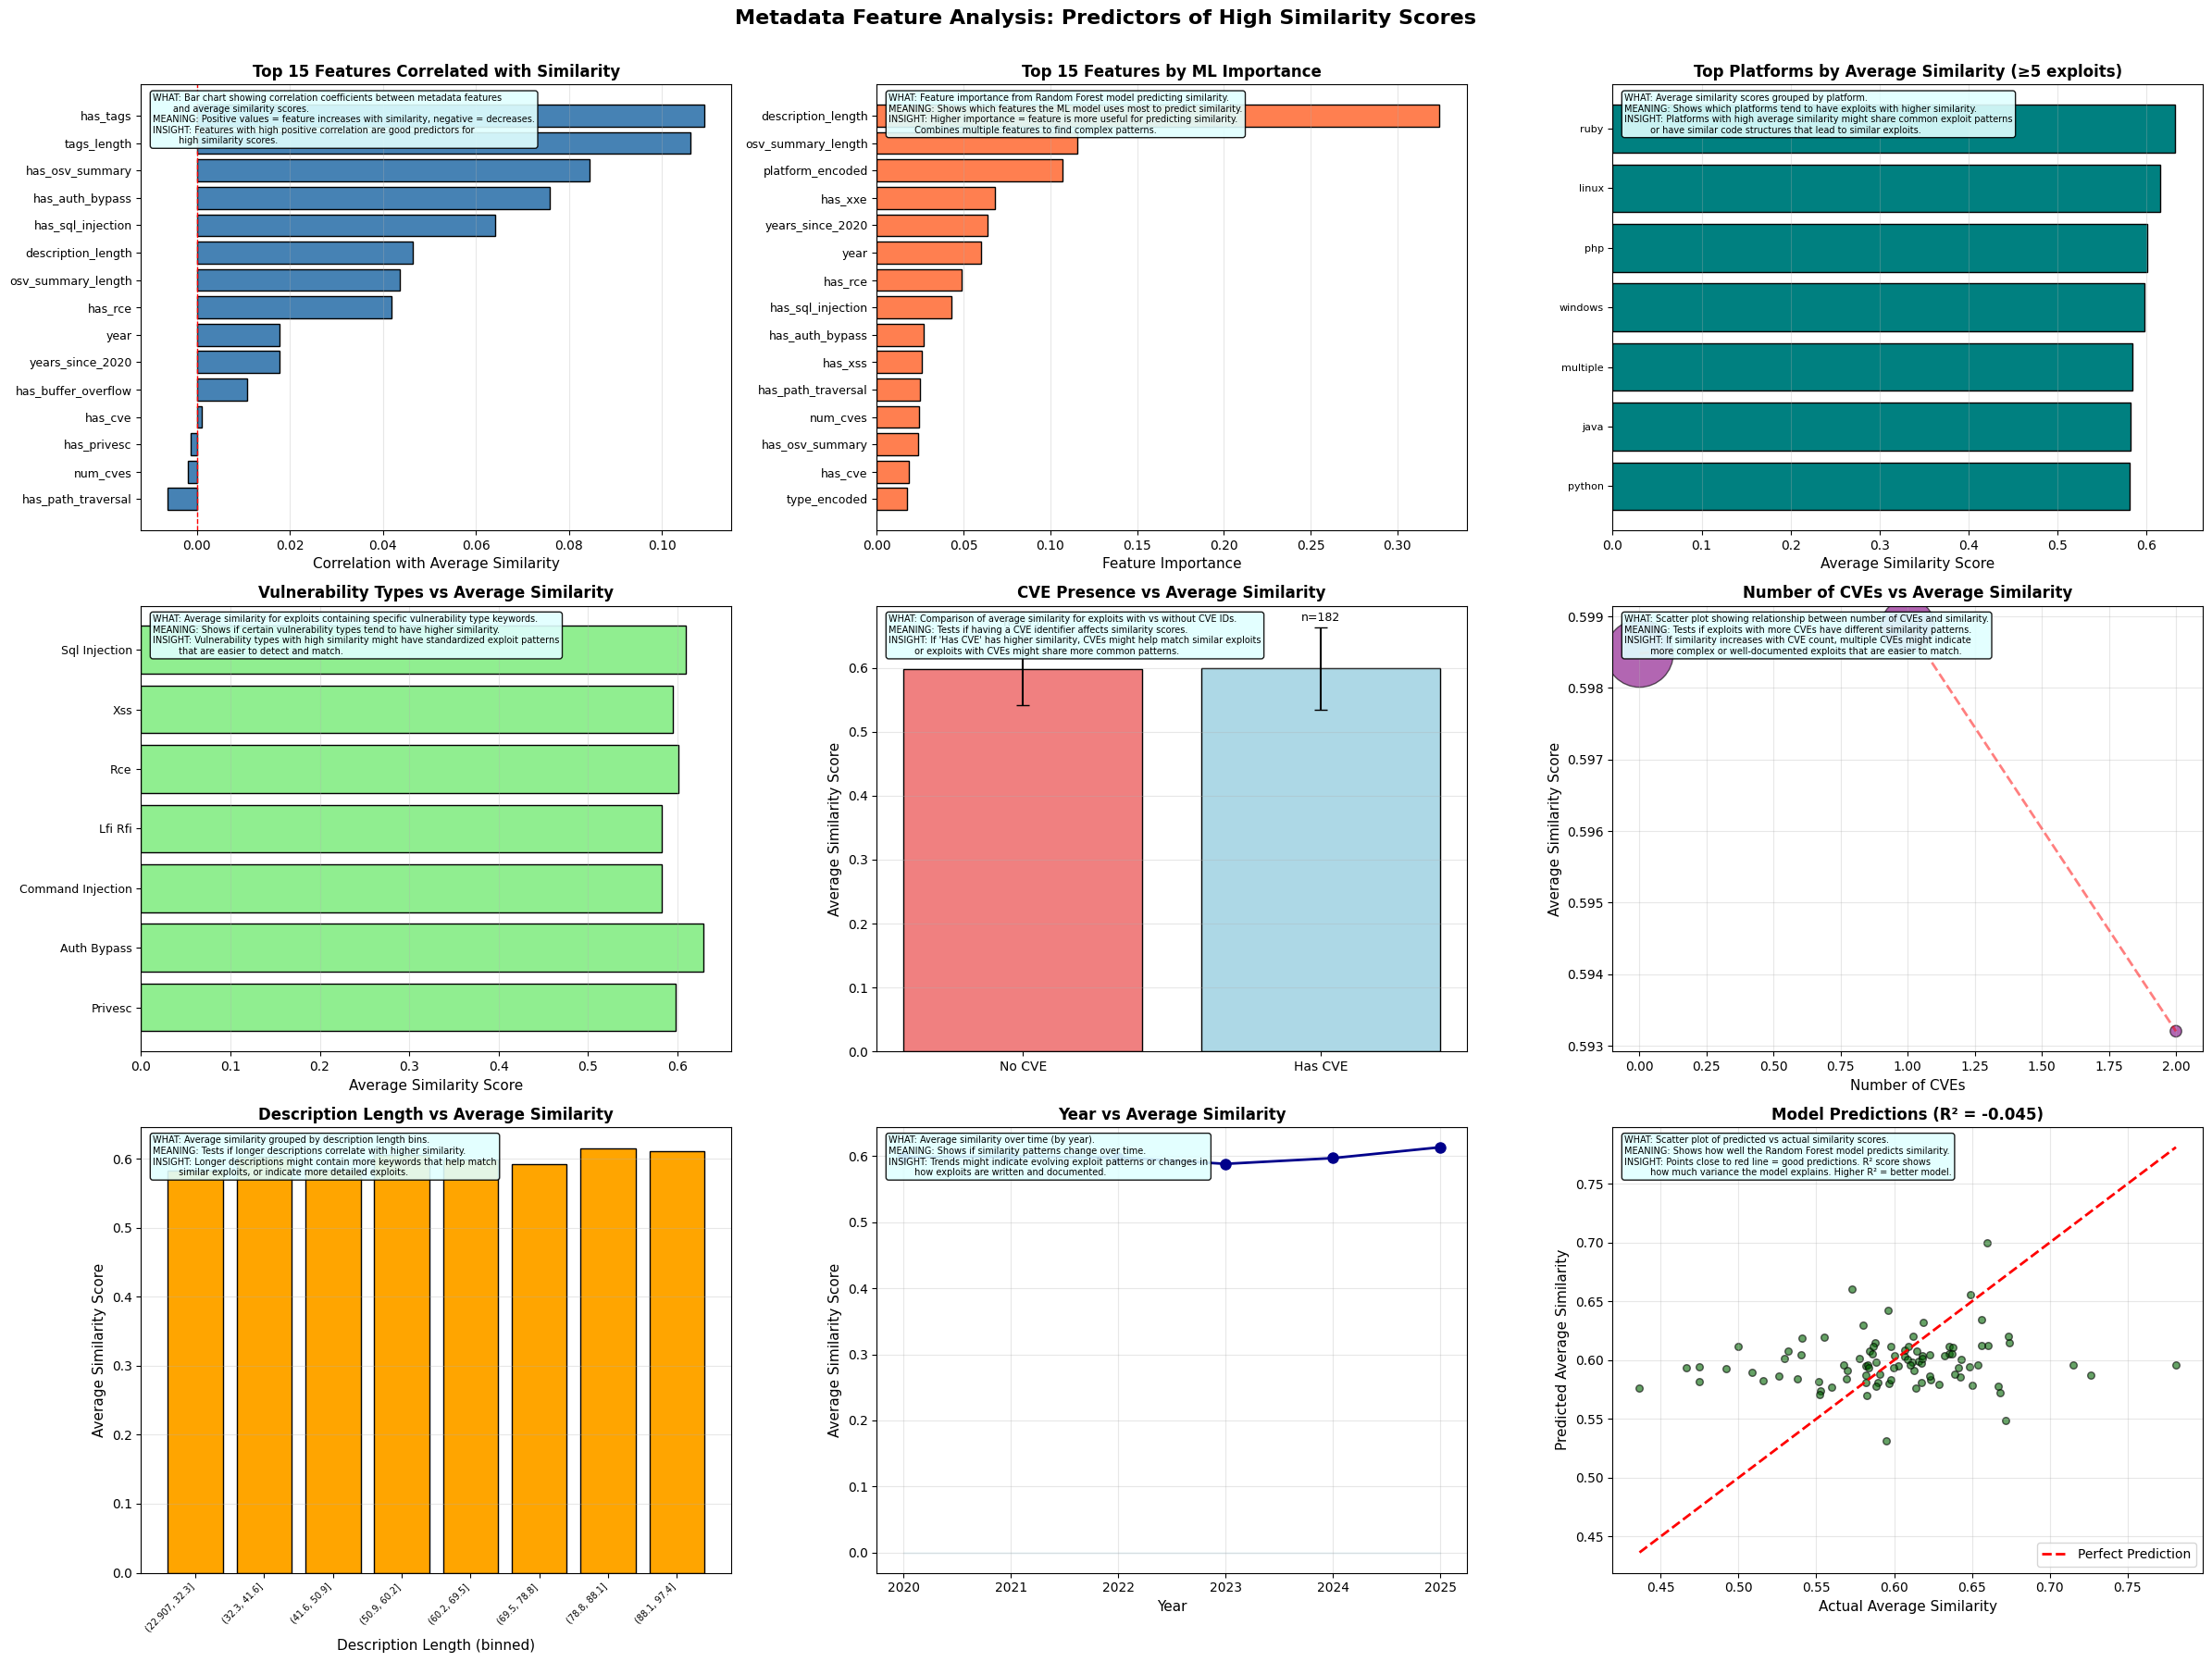


SUMMARY: BEST PREDICTORS FOR HIGH SIMILARITY

Top 5 Features by Correlation:
  1. has_tags: 0.1091
  2. tags_length: 0.1060
  3. has_osv_summary: 0.0845
  4. has_auth_bypass: 0.0759
  5. has_sql_injection: 0.0641

Top 5 Features by ML Importance:
  1. description_length: 0.3239
  2. osv_summary_length: 0.1153
  3. platform_encoded: 0.1072
  4. has_xxe: 0.0680
  5. years_since_2020: 0.0638

✓ Visualizations saved to metadata_feature_analysis.png
✓ Feature correlations saved to feature_correlations.csv
✓ ML feature importance saved to feature_importance_ml.csv


In [33]:
# Analyze metadata features as predictors for high similarity scores
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

try:
    with open('semantic_similarity_results.json', 'r') as f:
        similarity_data = json.load(f)
    
    # Load exploit dataframes
    found_kev_df = pd.read_csv('exploits_found_in_kev.csv')
    not_found_kev_df = pd.read_csv('exploits_not_found_in_kev.csv')
    
    print("="*60)
    print("METADATA FEATURE ANALYSIS FOR SIMILARITY PREDICTION")
    print("="*60)
    
    # Build similarity matrix to get average similarity for each non-KEV exploit
    top_similarities = similarity_data.get('top_similarities', [])
    
    # Map non-KEV exploits and calculate their average similarity scores
    non_kev_similarity_scores = {}
    
    for kev_item in top_similarities:
        for match in kev_item.get('top_similar_exploits', []):
            non_kev_id = match.get('non_kev_id', 0)
            similarity = match.get('similarity_score', 0)
            
            if non_kev_id > 0:
                if non_kev_id not in non_kev_similarity_scores:
                    non_kev_similarity_scores[non_kev_id] = []
                non_kev_similarity_scores[non_kev_id].append(similarity)
    
    # Calculate average similarity for each non-KEV exploit
    non_kev_avg_similarity = {
        nid: np.mean(scores) for nid, scores in non_kev_similarity_scores.items()
    }
    
    print(f"\nFound similarity scores for {len(non_kev_avg_similarity)} non-KEV exploits")
    
    # Extract metadata features from non-KEV exploits
    print("\nExtracting metadata features...")
    
    def extract_features(row):
        """Extract various metadata features from an exploit row"""
        features = {}
        
        # Basic features
        features['platform'] = str(row.get('platform', 'N/A')) if pd.notna(row.get('platform')) else 'N/A'
        features['type'] = str(row.get('type', 'N/A')) if pd.notna(row.get('type')) else 'N/A'
        features['port'] = str(row.get('port', 'N/A')) if pd.notna(row.get('port')) else 'N/A'
        
        # Description features
        desc = str(row.get('description', '')) if pd.notna(row.get('description')) else ''
        features['description_length'] = len(desc)
        features['has_cve_in_desc'] = 1 if re.search(r'CVE-\d{4}-\d+', desc, re.IGNORECASE) else 0
        
        # Vulnerability type keywords in description
        vuln_keywords = {
            'sql_injection': ['sql injection', 'sqli', 'sql-injection'],
            'xss': ['xss', 'cross-site scripting', 'cross site scripting'],
            'rce': ['remote code execution', 'rce', 'code execution'],
            'lfi_rfi': ['local file inclusion', 'lfi', 'remote file inclusion', 'rfi'],
            'command_injection': ['command injection', 'os command', 'shell injection'],
            'auth_bypass': ['auth bypass', 'authentication bypass', 'login bypass'],
            'privesc': ['privilege escalation', 'privesc', 'privilege'],
            'buffer_overflow': ['buffer overflow', 'stack overflow', 'heap overflow'],
            'xxe': ['xxe', 'xml external entity'],
            'ssrf': ['ssrf', 'server-side request forgery'],
            'deserialization': ['deserialization', 'unserialize'],
            'path_traversal': ['path traversal', 'directory traversal']
        }
        
        desc_lower = desc.lower()
        for key, keywords in vuln_keywords.items():
            features[f'has_{key}'] = 1 if any(kw in desc_lower for kw in keywords) else 0
        
        # Tags features
        tags = str(row.get('tags', '')) if pd.notna(row.get('tags')) else ''
        features['has_tags'] = 1 if tags and tags != 'N/A' and tags.strip() else 0
        features['tags_length'] = len(tags)
        
        # CVE features
        cves = []
        if 'extracted_cves' in row and pd.notna(row.get('extracted_cves')):
            cves_list = row.get('extracted_cves')
            if isinstance(cves_list, list):
                cves = cves_list
            elif isinstance(cves_list, str):
                cves = re.findall(r'CVE-\d{4}-\d+', cves_list, re.IGNORECASE)
        
        if 'codes' in row and pd.notna(row.get('codes')):
            codes_str = str(row.get('codes'))
            cves.extend(re.findall(r'CVE-\d{4}-\d+', codes_str, re.IGNORECASE))
        
        features['num_cves'] = len(set(cves))  # Unique CVEs
        features['has_cve'] = 1 if len(cves) > 0 else 0
        
        # OSV features
        features['has_osv_summary'] = 1 if pd.notna(row.get('osv_summary')) and str(row.get('osv_summary')) != 'N/A' else 0
        osv_summary = str(row.get('osv_summary', '')) if pd.notna(row.get('osv_summary')) else ''
        features['osv_summary_length'] = len(osv_summary)
        
        # Date features (if available)
        if 'date_published' in row and pd.notna(row.get('date_published')):
            try:
                date_str = str(row.get('date_published'))
                if len(date_str) >= 4:
                    year = int(date_str[:4])
                    features['year'] = year
                    features['years_since_2020'] = max(0, year - 2020)
                else:
                    features['year'] = 2020
                    features['years_since_2020'] = 0
            except:
                features['year'] = 2020
                features['years_since_2020'] = 0
        else:
            features['year'] = 2020
            features['years_since_2020'] = 0
        
        return features
    
    # Extract features for all non-KEV exploits with similarity scores
    feature_data = []
    target_scores = []
    
    for non_kev_id, avg_sim in non_kev_avg_similarity.items():
        row = not_found_kev_df[not_found_kev_df['id'] == non_kev_id]
        if len(row) > 0:
            features = extract_features(row.iloc[0])
            features['exploit_id'] = non_kev_id
            feature_data.append(features)
            target_scores.append(avg_sim)
    
    features_df = pd.DataFrame(feature_data)
    features_df['avg_similarity'] = target_scores
    
    print(f"\nExtracted {len(features_df.columns)} features for {len(features_df)} exploits")
    print(f"Features: {list(features_df.columns)}")
    
    # Statistical analysis: correlation with similarity
    print("\n" + "="*60)
    print("FEATURE CORRELATION ANALYSIS")
    print("="*60)
    
    # Select numeric features for correlation
    numeric_features = features_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'exploit_id' in numeric_features:
        numeric_features.remove('exploit_id')
    if 'avg_similarity' in numeric_features:
        numeric_features.remove('avg_similarity')
    
    correlations = features_df[numeric_features + ['avg_similarity']].corr()['avg_similarity'].sort_values(ascending=False)
    correlations = correlations.drop('avg_similarity')
    
    print("\nTop 15 Features Correlated with Average Similarity:")
    print("-" * 60)
    for feature, corr in correlations.head(15).items():
        print(f"  {feature:30s}: {corr:7.4f}")
    
    print("\nBottom 5 Features (Negative Correlation):")
    print("-" * 60)
    for feature, corr in correlations.tail(5).items():
        print(f"  {feature:30s}: {corr:7.4f}")
    
    # Categorical feature analysis
    print("\n" + "="*60)
    print("CATEGORICAL FEATURE ANALYSIS")
    print("="*60)
    
    categorical_features = ['platform', 'type', 'port']
    for cat_feature in categorical_features:
        if cat_feature in features_df.columns:
            print(f"\n{cat_feature.upper()} Analysis:")
            grouped = features_df.groupby(cat_feature)['avg_similarity'].agg(['mean', 'count', 'std'])
            grouped = grouped.sort_values('mean', ascending=False)
            print(grouped.head(10).to_string())
    
    # Machine Learning: Feature Importance
    print("\n" + "="*60)
    print("MACHINE LEARNING: FEATURE IMPORTANCE")
    print("="*60)
    
    # Prepare data for ML
    ml_df = features_df.copy()
    
    # Encode categorical features
    label_encoders = {}
    for col in ['platform', 'type', 'port']:
        if col in ml_df.columns:
            le = LabelEncoder()
            ml_df[col + '_encoded'] = le.fit_transform(ml_df[col].astype(str))
            label_encoders[col] = le
    
    # Select features for ML (numeric + encoded categorical)
    ml_features = numeric_features.copy()
    ml_features.extend([col + '_encoded' for col in ['platform', 'type', 'port'] if col in ml_df.columns])
    ml_features = [f for f in ml_features if f in ml_df.columns]
    
    X = ml_df[ml_features].fillna(0)
    y = ml_df['avg_similarity']
    
    # Train Random Forest
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\nRandom Forest Model Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': ml_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 20 Most Important Features for Predicting Similarity:")
    print("-" * 60)
    for idx, row in feature_importance.head(20).iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:7.4f}")
    
    # Create visualizations
    fig = plt.figure(figsize=(24, 18))
    
    # 1. Top feature correlations
    ax1 = plt.subplot(3, 3, 1)
    top_corr = correlations.head(15)
    ax1.barh(range(len(top_corr)), top_corr.values, color='steelblue', edgecolor='black')
    ax1.set_yticks(range(len(top_corr)))
    ax1.set_yticklabels(top_corr.index, fontsize=9)
    ax1.set_xlabel('Correlation with Average Similarity', fontsize=11)
    ax1.set_title('Top 15 Features Correlated with Similarity', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)
    explanation1 = ("WHAT: Bar chart showing correlation coefficients between metadata features\n"
                   "       and average similarity scores.\n"
                   "MEANING: Positive values = feature increases with similarity, negative = decreases.\n"
                   "INSIGHT: Features with high positive correlation are good predictors for\n"
                   "         high similarity scores.")
    ax1.text(0.02, 0.98, explanation1, transform=ax1.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 2. Feature importance from Random Forest
    ax2 = plt.subplot(3, 3, 2)
    top_importance = feature_importance.head(15)
    ax2.barh(range(len(top_importance)), top_importance['importance'].values, color='coral', edgecolor='black')
    ax2.set_yticks(range(len(top_importance)))
    ax2.set_yticklabels(top_importance['feature'].values, fontsize=9)
    ax2.set_xlabel('Feature Importance', fontsize=11)
    ax2.set_title('Top 15 Features by ML Importance', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    explanation2 = ("WHAT: Feature importance from Random Forest model predicting similarity.\n"
                   "MEANING: Shows which features the ML model uses most to predict similarity.\n"
                   "INSIGHT: Higher importance = feature is more useful for predicting similarity.\n"
                   "         Combines multiple features to find complex patterns.")
    ax2.text(0.02, 0.98, explanation2, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 3. Platform vs Average Similarity
    ax3 = plt.subplot(3, 3, 3)
    if 'platform' in features_df.columns:
        platform_stats = features_df.groupby('platform')['avg_similarity'].agg(['mean', 'count'])
        platform_stats = platform_stats[platform_stats['count'] >= 5].sort_values('mean', ascending=False).head(15)
        ax3.barh(range(len(platform_stats)), platform_stats['mean'].values, color='teal', edgecolor='black')
        ax3.set_yticks(range(len(platform_stats)))
        ax3.set_yticklabels(platform_stats.index, fontsize=8)
        ax3.set_xlabel('Average Similarity Score', fontsize=11)
        ax3.set_title('Top Platforms by Average Similarity (≥5 exploits)', fontsize=12, fontweight='bold')
        ax3.invert_yaxis()
        ax3.grid(True, alpha=0.3, axis='x')
    explanation3 = ("WHAT: Average similarity scores grouped by platform.\n"
                   "MEANING: Shows which platforms tend to have exploits with higher similarity.\n"
                   "INSIGHT: Platforms with high average similarity might share common exploit patterns\n"
                   "         or have similar code structures that lead to similar exploits.")
    ax3.text(0.02, 0.98, explanation3, transform=ax3.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 4. Vulnerability type presence vs similarity
    ax4 = plt.subplot(3, 3, 4)
    vuln_type_cols = [col for col in features_df.columns if col.startswith('has_') and col in ['has_sql_injection', 'has_rce', 'has_xss', 'has_lfi_rfi', 'has_command_injection', 'has_auth_bypass', 'has_privesc']]
    if vuln_type_cols:
        vuln_means = []
        vuln_names = []
        for col in vuln_type_cols:
            if col in features_df.columns:
                mean_sim = features_df[features_df[col] == 1]['avg_similarity'].mean()
                vuln_means.append(mean_sim)
                vuln_names.append(col.replace('has_', '').replace('_', ' ').title())
        
        if vuln_means:
            ax4.barh(range(len(vuln_names)), vuln_means, color='lightgreen', edgecolor='black')
            ax4.set_yticks(range(len(vuln_names)))
            ax4.set_yticklabels(vuln_names, fontsize=9)
            ax4.set_xlabel('Average Similarity Score', fontsize=11)
            ax4.set_title('Vulnerability Types vs Average Similarity', fontsize=12, fontweight='bold')
            ax4.invert_yaxis()
            ax4.grid(True, alpha=0.3, axis='x')
    explanation4 = ("WHAT: Average similarity for exploits containing specific vulnerability type keywords.\n"
                   "MEANING: Shows if certain vulnerability types tend to have higher similarity.\n"
                   "INSIGHT: Vulnerability types with high similarity might have standardized exploit patterns\n"
                   "         that are easier to detect and match.")
    ax4.text(0.02, 0.98, explanation4, transform=ax4.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 5. CVE presence vs similarity
    ax5 = plt.subplot(3, 3, 5)
    if 'has_cve' in features_df.columns:
        cve_groups = features_df.groupby('has_cve')['avg_similarity']
        cve_stats = cve_groups.agg(['mean', 'std', 'count'])
        ax5.bar(['No CVE', 'Has CVE'], cve_stats['mean'].values, 
               yerr=cve_stats['std'].values, color=['lightcoral', 'lightblue'], 
               edgecolor='black', capsize=5)
        ax5.set_ylabel('Average Similarity Score', fontsize=11)
        ax5.set_title('CVE Presence vs Average Similarity', fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        for i, (mean, count) in enumerate(zip(cve_stats['mean'].values, cve_stats['count'].values)):
            ax5.text(i, mean + cve_stats['std'].values[i] + 0.01, f'n={int(count)}', 
                    ha='center', fontsize=9)
    explanation5 = ("WHAT: Comparison of average similarity for exploits with vs without CVE IDs.\n"
                   "MEANING: Tests if having a CVE identifier affects similarity scores.\n"
                   "INSIGHT: If 'Has CVE' has higher similarity, CVEs might help match similar exploits\n"
                   "         or exploits with CVEs might share more common patterns.")
    ax5.text(0.02, 0.98, explanation5, transform=ax5.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 6. Number of CVEs vs similarity
    ax6 = plt.subplot(3, 3, 6)
    if 'num_cves' in features_df.columns:
        cve_count_groups = features_df.groupby('num_cves')['avg_similarity'].agg(['mean', 'count'])
        cve_count_groups = cve_count_groups[cve_count_groups['count'] >= 3]  # At least 3 exploits
        ax6.scatter(cve_count_groups.index, cve_count_groups['mean'].values, 
                   s=cve_count_groups['count'].values * 10, alpha=0.6, color='purple', edgecolor='black')
        ax6.plot(cve_count_groups.index, cve_count_groups['mean'].values, 
                color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax6.set_xlabel('Number of CVEs', fontsize=11)
        ax6.set_ylabel('Average Similarity Score', fontsize=11)
        ax6.set_title('Number of CVEs vs Average Similarity', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3)
    explanation6 = ("WHAT: Scatter plot showing relationship between number of CVEs and similarity.\n"
                   "MEANING: Tests if exploits with more CVEs have different similarity patterns.\n"
                   "INSIGHT: If similarity increases with CVE count, multiple CVEs might indicate\n"
                   "         more complex or well-documented exploits that are easier to match.")
    ax6.text(0.02, 0.98, explanation6, transform=ax6.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 7. Description length vs similarity
    ax7 = plt.subplot(3, 3, 7)
    if 'description_length' in features_df.columns:
        # Bin description lengths
        features_df['desc_length_bin'] = pd.cut(features_df['description_length'], bins=10)
        desc_bin_stats = features_df.groupby('desc_length_bin')['avg_similarity'].agg(['mean', 'count'])
        desc_bin_stats = desc_bin_stats[desc_bin_stats['count'] >= 5]
        bin_labels = [str(interval) for interval in desc_bin_stats.index]
        ax7.bar(range(len(bin_labels)), desc_bin_stats['mean'].values, color='orange', edgecolor='black')
        ax7.set_xticks(range(len(bin_labels)))
        ax7.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=7)
        ax7.set_ylabel('Average Similarity Score', fontsize=11)
        ax7.set_xlabel('Description Length (binned)', fontsize=11)
        ax7.set_title('Description Length vs Average Similarity', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3, axis='y')
    explanation7 = ("WHAT: Average similarity grouped by description length bins.\n"
                   "MEANING: Tests if longer descriptions correlate with higher similarity.\n"
                   "INSIGHT: Longer descriptions might contain more keywords that help match\n"
                   "         similar exploits, or indicate more detailed exploits.")
    ax7.text(0.02, 0.98, explanation7, transform=ax7.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 8. Year vs similarity
    ax8 = plt.subplot(3, 3, 8)
    if 'year' in features_df.columns:
        year_stats = features_df.groupby('year')['avg_similarity'].agg(['mean', 'count'])
        year_stats = year_stats[year_stats['count'] >= 3]
        ax8.plot(year_stats.index, year_stats['mean'].values, marker='o', 
                color='darkblue', linewidth=2, markersize=8)
        ax8.fill_between(year_stats.index, 
                        year_stats['mean'].values - year_stats['std'].values if 'std' in year_stats.columns else 0,
                        year_stats['mean'].values + year_stats['std'].values if 'std' in year_stats.columns else 0,
                        alpha=0.3, color='lightblue')
        ax8.set_xlabel('Year', fontsize=11)
        ax8.set_ylabel('Average Similarity Score', fontsize=11)
        ax8.set_title('Year vs Average Similarity', fontsize=12, fontweight='bold')
        ax8.grid(True, alpha=0.3)
    explanation8 = ("WHAT: Average similarity over time (by year).\n"
                   "MEANING: Shows if similarity patterns change over time.\n"
                   "INSIGHT: Trends might indicate evolving exploit patterns or changes in\n"
                   "         how exploits are written and documented.")
    ax8.text(0.02, 0.98, explanation8, transform=ax8.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 9. Model predictions vs actual
    ax9 = plt.subplot(3, 3, 9)
    ax9.scatter(y_test, y_pred, alpha=0.6, color='darkgreen', edgecolor='black', s=30)
    ax9.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', linewidth=2, label='Perfect Prediction')
    ax9.set_xlabel('Actual Average Similarity', fontsize=11)
    ax9.set_ylabel('Predicted Average Similarity', fontsize=11)
    ax9.set_title(f'Model Predictions (R² = {r2:.3f})', fontsize=12, fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    explanation9 = ("WHAT: Scatter plot of predicted vs actual similarity scores.\n"
                   "MEANING: Shows how well the Random Forest model predicts similarity.\n"
                   "INSIGHT: Points close to red line = good predictions. R² score shows\n"
                   "         how much variance the model explains. Higher R² = better model.")
    ax9.text(0.02, 0.98, explanation9, transform=ax9.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    plt.suptitle('Metadata Feature Analysis: Predictors of High Similarity Scores', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig('metadata_feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save results
    correlations_df = pd.DataFrame({
        'feature': correlations.index,
        'correlation': correlations.values
    })
    correlations_df.to_csv('feature_correlations.csv', index=False)
    
    feature_importance.to_csv('feature_importance_ml.csv', index=False)
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY: BEST PREDICTORS FOR HIGH SIMILARITY")
    print(f"{'='*60}")
    print("\nTop 5 Features by Correlation:")
    for i, (feature, corr) in enumerate(correlations.head(5).items(), 1):
        print(f"  {i}. {feature}: {corr:.4f}")
    
    print("\nTop 5 Features by ML Importance:")
    for i, row in enumerate(feature_importance.head(5).itertuples(), 1):
        print(f"  {i}. {row.feature}: {row.importance:.4f}")
    
    print(f"\n✓ Visualizations saved to metadata_feature_analysis.png")
    print(f"✓ Feature correlations saved to feature_correlations.csv")
    print(f"✓ ML feature importance saved to feature_importance_ml.csv")
    
except FileNotFoundError as e:
    print(f"⚠️  File not found: {e}")
    print("   Please ensure semantic_similarity_results.json and CSV files exist")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()


DEEP DIVE: VULNERABILITY TYPES & PLATFORM AS PREDICTORS

Analyzing 459 exploits with similarity scores
Total vulnerability type occurrences: 489

VULNERABILITY TYPE ANALYSIS

Vulnerability Types by Average Similarity:
                       mean_sim  std_sim  total_occurrences  min_sim  max_sim  median_sim  unique_exploits
vulnerability_type                                                                                        
Authentication Bypass    0.6290   0.0764                 10   0.4940   0.7800      0.6340               10
SQL Injection            0.6094   0.0624                 51   0.4281   0.8115      0.5995               51
CSRF                     0.6088   0.0570                 10   0.5386   0.7267      0.6061               10
Buffer Overflow          0.6055   0.0043                  4   0.6021   0.6116      0.6040                4
RCE                      0.6016   0.0544                182   0.3441   0.8031      0.6020              182
Privilege Escalation     0.5980  

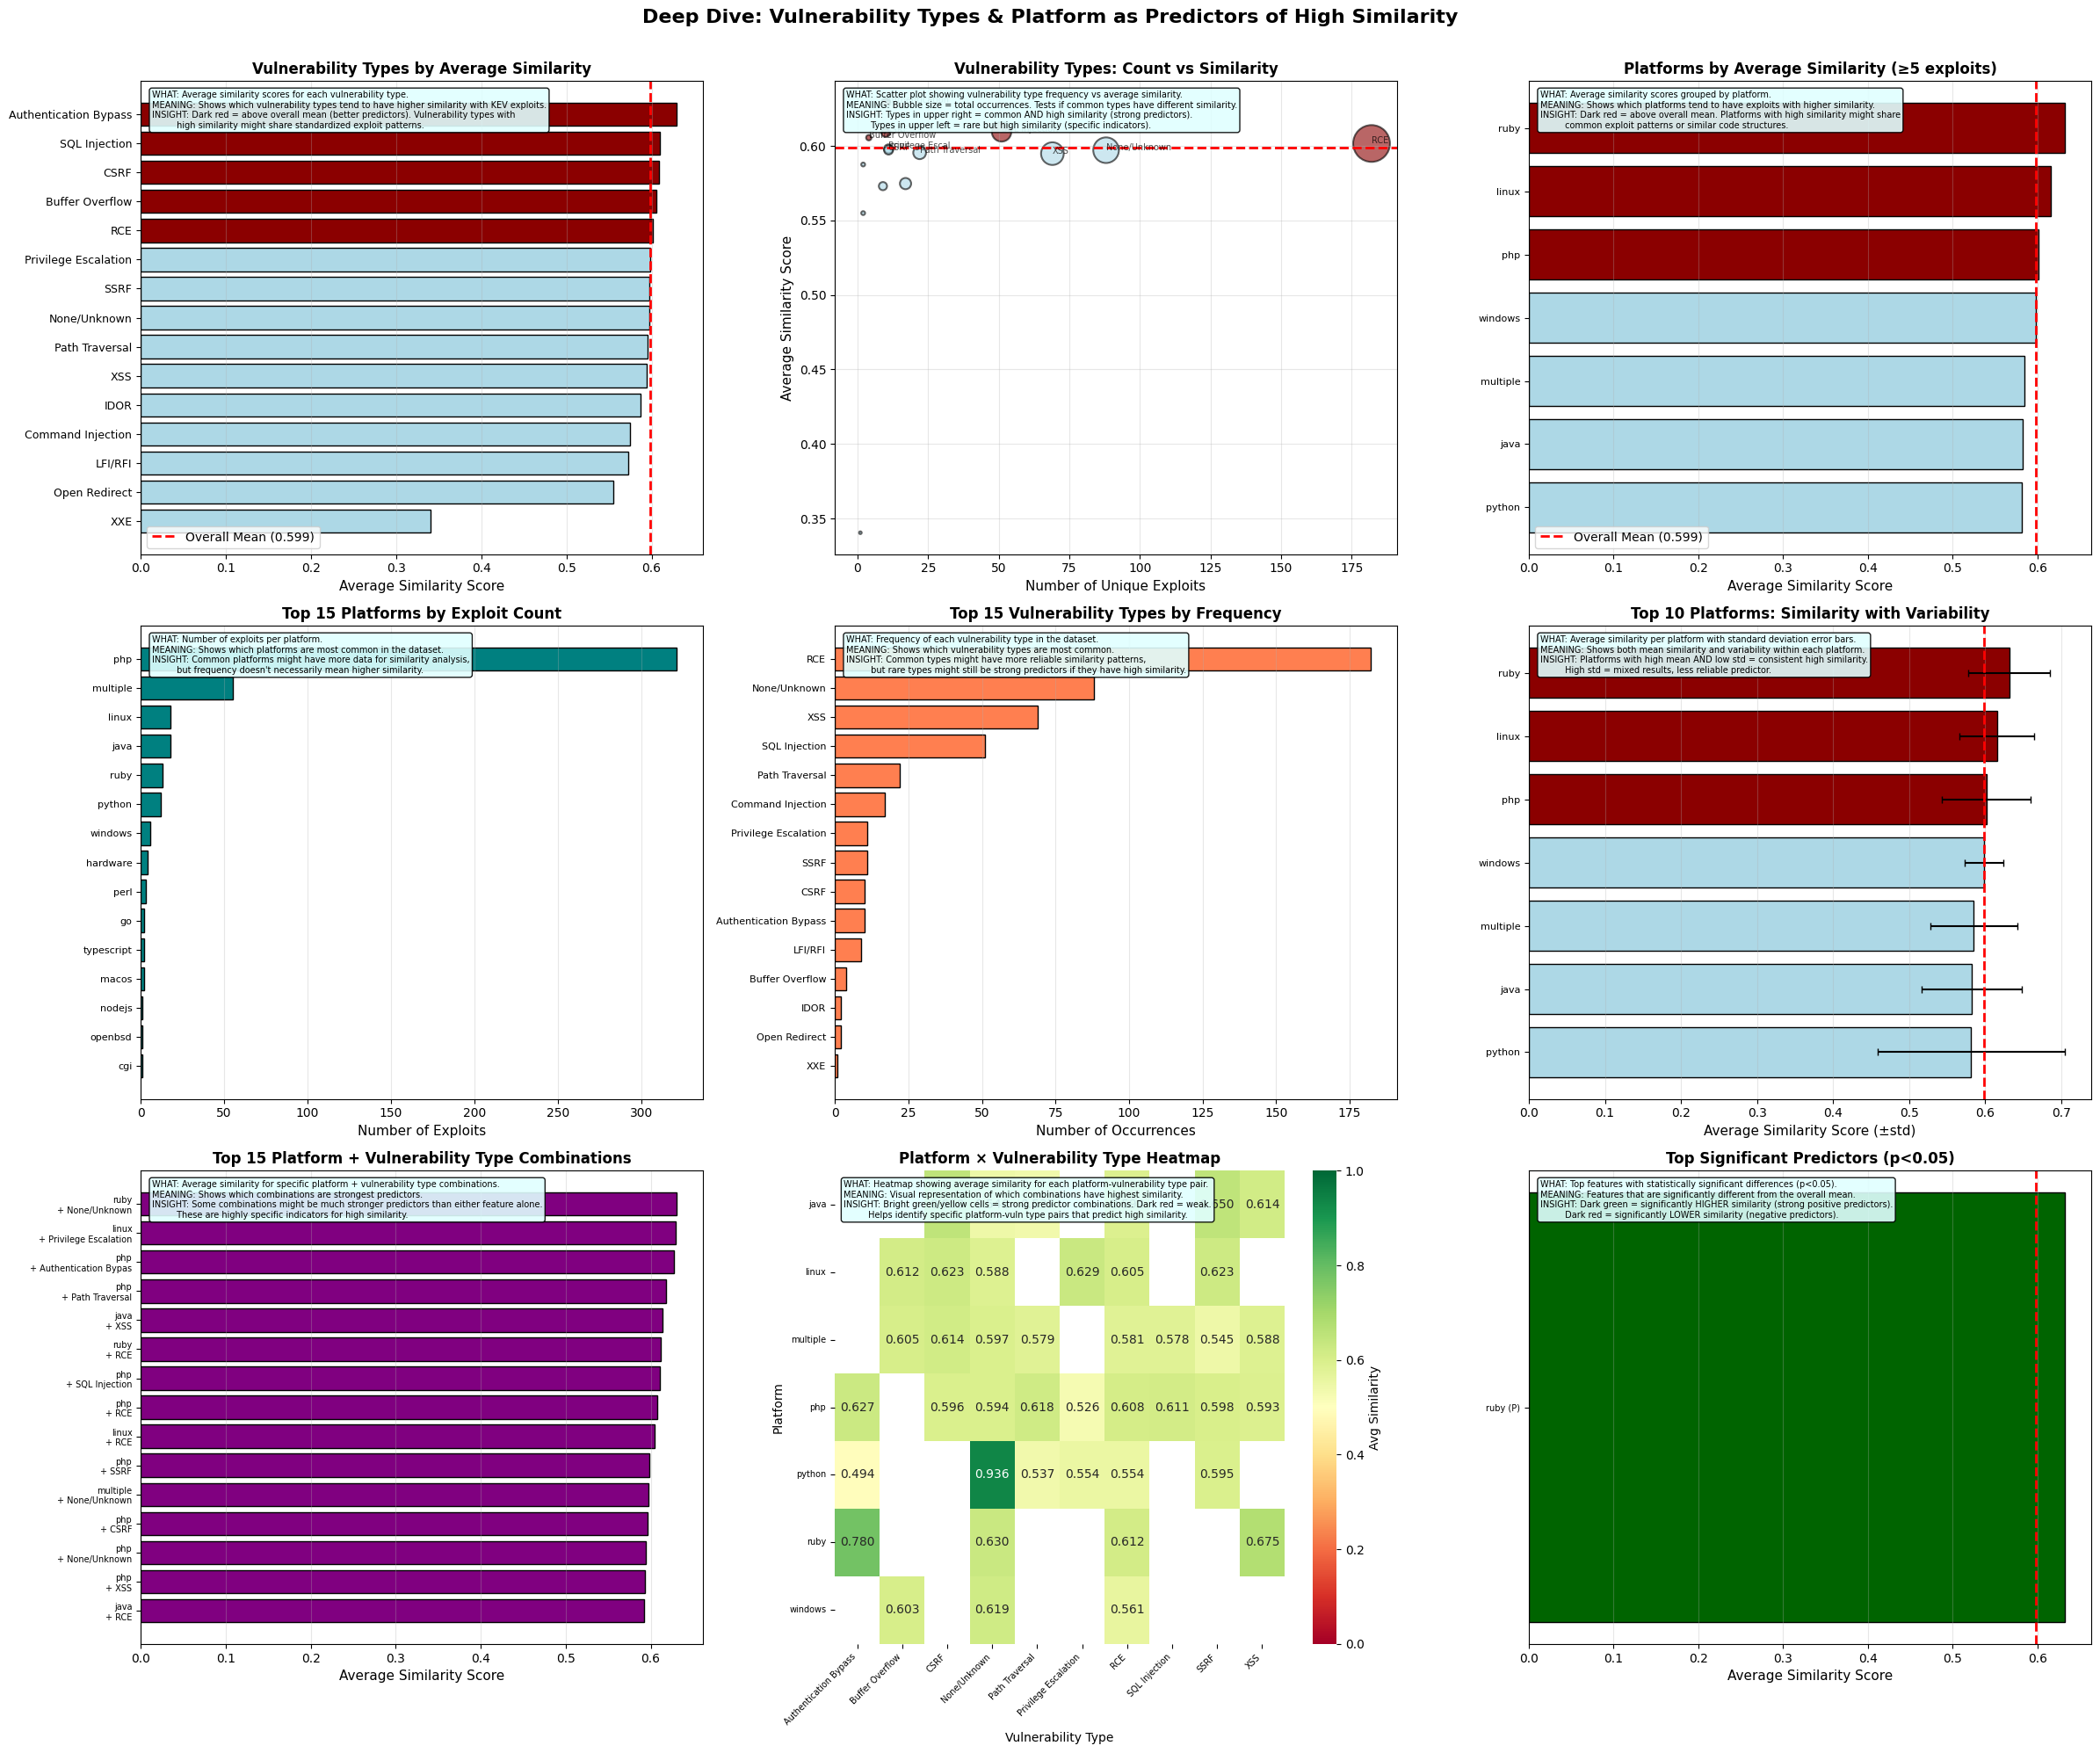


✓ Visualizations saved to vulnerability_type_platform_analysis.png
✓ Vulnerability type statistics saved to vulnerability_type_statistics.csv
✓ Platform statistics saved to platform_statistics.csv
✓ Platform + Vulnerability type combinations saved to platform_vulntype_combinations.csv
✓ Significant predictors saved to significant_predictors.csv

SUMMARY: BEST PREDICTORS

Top 5 Vulnerability Types by Average Similarity:
  1. Authentication Bypass: 0.6290 (n=10.0)
  2. SQL Injection: 0.6094 (n=51.0)
  3. CSRF: 0.6088 (n=10.0)
  4. Buffer Overflow: 0.6055 (n=4.0)
  5. RCE: 0.6016 (n=182.0)

Top 5 Platforms by Average Similarity:
  1. ruby: 0.6318 (n=13.0)
  2. linux: 0.6154 (n=18.0)
  3. php: 0.6014 (n=321.0)
  4. windows: 0.5980 (n=6.0)
  5. multiple: 0.5847 (n=55.0)

Top 5 Platform + Vulnerability Type Combinations:
  1. ruby + None/Unknown: 0.6301 (n=4.0)
  2. linux + Privilege Escalation: 0.6290 (n=7.0)
  3. php + Authentication Bypass: 0.6270 (n=8.0)
  4. php + Path Traversal: 0.617

In [34]:
# Deep dive analysis: Vulnerability Types and Platform as predictors
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from scipy import stats

try:
    with open('semantic_similarity_results.json', 'r') as f:
        similarity_data = json.load(f)
    
    # Load exploit dataframes
    not_found_kev_df = pd.read_csv('exploits_not_found_in_kev.csv')
    
    print("="*60)
    print("DEEP DIVE: VULNERABILITY TYPES & PLATFORM AS PREDICTORS")
    print("="*60)
    
    # Build similarity scores for non-KEV exploits
    top_similarities = similarity_data.get('top_similarities', [])
    
    non_kev_similarity_scores = {}
    for kev_item in top_similarities:
        for match in kev_item.get('top_similar_exploits', []):
            non_kev_id = match.get('non_kev_id', 0)
            similarity = match.get('similarity_score', 0)
            
            if non_kev_id > 0:
                if non_kev_id not in non_kev_similarity_scores:
                    non_kev_similarity_scores[non_kev_id] = []
                non_kev_similarity_scores[non_kev_id].append(similarity)
    
    non_kev_avg_similarity = {
        nid: np.mean(scores) for nid, scores in non_kev_similarity_scores.items()
    }
    
    # Extract vulnerability types and platform for each exploit
    def extract_vuln_types_and_platform(row):
        """Extract vulnerability types and platform from exploit row"""
        result = {
            'exploit_id': row.get('id', 0),
            'platform': str(row.get('platform', 'N/A')) if pd.notna(row.get('platform')) else 'N/A',
            'vulnerability_types': [],
            'avg_similarity': non_kev_avg_similarity.get(row.get('id', 0), 0)
        }
        
        # Extract vulnerability types from description and tags
        desc = str(row.get('description', '')) if pd.notna(row.get('description')) else ''
        tags = str(row.get('tags', '')) if pd.notna(row.get('tags')) else ''
        combined_text = (desc + ' ' + tags).lower()
        
        vuln_patterns = {
            'SQL Injection': ['sql injection', 'sqli', 'sql-injection', 'sql injection vulnerability'],
            'XSS': ['xss', 'cross-site scripting', 'cross site scripting', 'cross-site-scripting'],
            'RCE': ['remote code execution', 'rce', 'code execution', 'arbitrary code execution'],
            'LFI/RFI': ['local file inclusion', 'lfi', 'remote file inclusion', 'rfi', 'file inclusion'],
            'Command Injection': ['command injection', 'os command injection', 'shell injection', 'command execution'],
            'Authentication Bypass': ['auth bypass', 'authentication bypass', 'login bypass', 'auth vulnerability'],
            'Privilege Escalation': ['privilege escalation', 'privesc', 'privilege', 'escalation'],
            'Buffer Overflow': ['buffer overflow', 'stack overflow', 'heap overflow', 'buffer'],
            'XXE': ['xxe', 'xml external entity', 'xml injection', 'external entity'],
            'SSRF': ['ssrf', 'server-side request forgery', 'server side request', 'request forgery'],
            'Deserialization': ['deserialization', 'unserialize', 'pickle', 'deserialize'],
            'Path Traversal': ['path traversal', 'directory traversal', '../', 'directory'],
            'IDOR': ['idor', 'insecure direct object reference', 'direct object'],
            'CSRF': ['csrf', 'cross-site request forgery', 'cross site request'],
            'Open Redirect': ['open redirect', 'redirect vulnerability', 'unsafe redirect']
        }
        
        for vuln_type, keywords in vuln_patterns.items():
            if any(keyword in combined_text for keyword in keywords):
                result['vulnerability_types'].append(vuln_type)
        
        return result
    
    # Extract data for all non-KEV exploits
    analysis_data = []
    for non_kev_id in non_kev_avg_similarity.keys():
        row = not_found_kev_df[not_found_kev_df['id'] == non_kev_id]
        if len(row) > 0:
            data = extract_vuln_types_and_platform(row.iloc[0])
            analysis_data.append(data)
    
    analysis_df = pd.DataFrame(analysis_data)
    
    # Expand vulnerability types (one row per type)
    expanded_data = []
    for _, row in analysis_df.iterrows():
        if len(row['vulnerability_types']) > 0:
            for vuln_type in row['vulnerability_types']:
                expanded_data.append({
                    'exploit_id': row['exploit_id'],
                    'platform': row['platform'],
                    'vulnerability_type': vuln_type,
                    'avg_similarity': row['avg_similarity']
                })
        else:
            expanded_data.append({
                'exploit_id': row['exploit_id'],
                'platform': row['platform'],
                'vulnerability_type': 'None/Unknown',
                'avg_similarity': row['avg_similarity']
            })
    
    expanded_df = pd.DataFrame(expanded_data)
    
    print(f"\nAnalyzing {len(analysis_df)} exploits with similarity scores")
    print(f"Total vulnerability type occurrences: {len(expanded_df)}")
    
    # VULNERABILITY TYPE ANALYSIS
    print("\n" + "="*60)
    print("VULNERABILITY TYPE ANALYSIS")
    print("="*60)
    
    vuln_type_stats = expanded_df.groupby('vulnerability_type').agg({
        'avg_similarity': ['mean', 'std', 'count', 'min', 'max', 'median'],
        'exploit_id': 'nunique'
    }).round(4)
    vuln_type_stats.columns = ['mean_sim', 'std_sim', 'total_occurrences', 'min_sim', 'max_sim', 'median_sim', 'unique_exploits']
    vuln_type_stats = vuln_type_stats.sort_values('mean_sim', ascending=False)
    
    print("\nVulnerability Types by Average Similarity:")
    print(vuln_type_stats.to_string())
    
    # Statistical tests: compare each vulnerability type to overall mean
    overall_mean = analysis_df['avg_similarity'].mean()
    print(f"\nOverall average similarity: {overall_mean:.4f}")
    print("\nVulnerability Types significantly different from overall mean:")
    print("-" * 60)
    
    significant_vulns = []
    for vuln_type in vuln_type_stats.index:
        if vuln_type != 'None/Unknown':
            vuln_sims = expanded_df[expanded_df['vulnerability_type'] == vuln_type]['avg_similarity'].values
            all_other_sims = expanded_df[expanded_df['vulnerability_type'] != vuln_type]['avg_similarity'].values
            
            if len(vuln_sims) >= 5 and len(all_other_sims) >= 5:
                t_stat, p_value = stats.ttest_ind(vuln_sims, all_other_sims)
                if p_value < 0.05:
                    significant_vulns.append({
                        'type': vuln_type,
                        'mean': vuln_type_stats.loc[vuln_type, 'mean_sim'],
                        'count': vuln_type_stats.loc[vuln_type, 'unique_exploits'],
                        'p_value': p_value,
                        'higher': vuln_type_stats.loc[vuln_type, 'mean_sim'] > overall_mean
                    })
    
    significant_vulns.sort(key=lambda x: x['mean'], reverse=True)
    for vuln in significant_vulns[:10]:
        direction = "HIGHER" if vuln['higher'] else "LOWER"
        print(f"  {vuln['type']:25s}: {vuln['mean']:.4f} (n={vuln['count']:3d}, p={vuln['p_value']:.4f}) - {direction}")
    
    # PLATFORM ANALYSIS
    print("\n" + "="*60)
    print("PLATFORM ANALYSIS")
    print("="*60)
    
    platform_stats = analysis_df.groupby('platform').agg({
        'avg_similarity': ['mean', 'std', 'count', 'min', 'max', 'median']
    }).round(4)
    platform_stats.columns = ['mean_sim', 'std_sim', 'count', 'min_sim', 'max_sim', 'median_sim']
    platform_stats = platform_stats[platform_stats['count'] >= 5].sort_values('mean_sim', ascending=False)
    
    print("\nPlatforms by Average Similarity (≥5 exploits):")
    print(platform_stats.to_string())
    
    # Statistical tests for platforms
    print("\nPlatforms significantly different from overall mean:")
    print("-" * 60)
    
    significant_platforms = []
    for platform in platform_stats.index:
        platform_sims = analysis_df[analysis_df['platform'] == platform]['avg_similarity'].values
        all_other_sims = analysis_df[analysis_df['platform'] != platform]['avg_similarity'].values
        
        if len(platform_sims) >= 5 and len(all_other_sims) >= 5:
            t_stat, p_value = stats.ttest_ind(platform_sims, all_other_sims)
            if p_value < 0.05:
                significant_platforms.append({
                    'platform': platform,
                    'mean': platform_stats.loc[platform, 'mean_sim'],
                    'count': platform_stats.loc[platform, 'count'],
                    'p_value': p_value,
                    'higher': platform_stats.loc[platform, 'mean_sim'] > overall_mean
                })
    
    significant_platforms.sort(key=lambda x: x['mean'], reverse=True)
    for plat in significant_platforms[:10]:
        direction = "HIGHER" if plat['higher'] else "LOWER"
        print(f"  {plat['platform']:30s}: {plat['mean']:.4f} (n={plat['count']:3d}, p={plat['p_value']:.4f}) - {direction}")
    
    # COMBINATION ANALYSIS: Platform + Vulnerability Type
    print("\n" + "="*60)
    print("PLATFORM + VULNERABILITY TYPE COMBINATIONS")
    print("="*60)
    
    combo_stats = expanded_df.groupby(['platform', 'vulnerability_type']).agg({
        'avg_similarity': ['mean', 'count']
    })
    combo_stats.columns = ['mean_sim', 'count']
    combo_stats = combo_stats[combo_stats['count'] >= 3].sort_values('mean_sim', ascending=False)
    
    print("\nTop 15 Platform + Vulnerability Type Combinations (≥3 exploits):")
    print(combo_stats.head(15).to_string())
    
    # Create visualizations
    fig = plt.figure(figsize=(24, 20))
    
    # 1. Vulnerability Types by Average Similarity
    ax1 = plt.subplot(3, 3, 1)
    top_vulns = vuln_type_stats.head(15)
    colors_vuln = ['darkred' if x > overall_mean else 'lightblue' for x in top_vulns['mean_sim']]
    ax1.barh(range(len(top_vulns)), top_vulns['mean_sim'].values, color=colors_vuln, edgecolor='black')
    ax1.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2, label=f'Overall Mean ({overall_mean:.3f})')
    ax1.set_yticks(range(len(top_vulns)))
    ax1.set_yticklabels(top_vulns.index, fontsize=9)
    ax1.set_xlabel('Average Similarity Score', fontsize=11)
    ax1.set_title('Vulnerability Types by Average Similarity', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    explanation1 = ("WHAT: Average similarity scores for each vulnerability type.\n"
                   "MEANING: Shows which vulnerability types tend to have higher similarity with KEV exploits.\n"
                   "INSIGHT: Dark red = above overall mean (better predictors). Vulnerability types with\n"
                   "         high similarity might share standardized exploit patterns.")
    ax1.text(0.02, 0.98, explanation1, transform=ax1.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 2. Vulnerability Types by Count and Similarity
    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(top_vulns['unique_exploits'], top_vulns['mean_sim'].values, 
               s=top_vulns['total_occurrences'].values * 5, alpha=0.6, 
               c=colors_vuln, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=overall_mean, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Number of Unique Exploits', fontsize=11)
    ax2.set_ylabel('Average Similarity Score', fontsize=11)
    ax2.set_title('Vulnerability Types: Count vs Similarity', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    for idx, row in top_vulns.head(10).iterrows():
        ax2.annotate(idx[:15], (row['unique_exploits'], row['mean_sim']), 
                    fontsize=7, alpha=0.7)
    explanation2 = ("WHAT: Scatter plot showing vulnerability type frequency vs average similarity.\n"
                   "MEANING: Bubble size = total occurrences. Tests if common types have different similarity.\n"
                   "INSIGHT: Types in upper right = common AND high similarity (strong predictors).\n"
                   "         Types in upper left = rare but high similarity (specific indicators).")
    ax2.text(0.02, 0.98, explanation2, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 3. Platforms by Average Similarity
    ax3 = plt.subplot(3, 3, 3)
    top_platforms = platform_stats.head(15)
    colors_plat = ['darkred' if x > overall_mean else 'lightblue' for x in top_platforms['mean_sim']]
    ax3.barh(range(len(top_platforms)), top_platforms['mean_sim'].values, 
            color=colors_plat, edgecolor='black')
    ax3.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2, 
               label=f'Overall Mean ({overall_mean:.3f})')
    ax3.set_yticks(range(len(top_platforms)))
    ax3.set_yticklabels(top_platforms.index, fontsize=8)
    ax3.set_xlabel('Average Similarity Score', fontsize=11)
    ax3.set_title('Platforms by Average Similarity (≥5 exploits)', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    explanation3 = ("WHAT: Average similarity scores grouped by platform.\n"
                   "MEANING: Shows which platforms tend to have exploits with higher similarity.\n"
                   "INSIGHT: Dark red = above overall mean. Platforms with high similarity might share\n"
                   "         common exploit patterns or similar code structures.")
    ax3.text(0.02, 0.98, explanation3, transform=ax3.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 4. Platform Distribution
    ax4 = plt.subplot(3, 3, 4)
    platform_counts = analysis_df['platform'].value_counts().head(15)
    ax4.barh(range(len(platform_counts)), platform_counts.values, color='teal', edgecolor='black')
    ax4.set_yticks(range(len(platform_counts)))
    ax4.set_yticklabels(platform_counts.index, fontsize=8)
    ax4.set_xlabel('Number of Exploits', fontsize=11)
    ax4.set_title('Top 15 Platforms by Exploit Count', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3, axis='x')
    explanation4 = ("WHAT: Number of exploits per platform.\n"
                   "MEANING: Shows which platforms are most common in the dataset.\n"
                   "INSIGHT: Common platforms might have more data for similarity analysis,\n"
                   "         but frequency doesn't necessarily mean higher similarity.")
    ax4.text(0.02, 0.98, explanation4, transform=ax4.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 5. Vulnerability Type Distribution
    ax5 = plt.subplot(3, 3, 5)
    vuln_counts = expanded_df['vulnerability_type'].value_counts().head(15)
    ax5.barh(range(len(vuln_counts)), vuln_counts.values, color='coral', edgecolor='black')
    ax5.set_yticks(range(len(vuln_counts)))
    ax5.set_yticklabels(vuln_counts.index, fontsize=8)
    ax5.set_xlabel('Number of Occurrences', fontsize=11)
    ax5.set_title('Top 15 Vulnerability Types by Frequency', fontsize=12, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')
    explanation5 = ("WHAT: Frequency of each vulnerability type in the dataset.\n"
                   "MEANING: Shows which vulnerability types are most common.\n"
                   "INSIGHT: Common types might have more reliable similarity patterns,\n"
                   "         but rare types might still be strong predictors if they have high similarity.")
    ax5.text(0.02, 0.98, explanation5, transform=ax5.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 6. Platform vs Similarity (with error bars)
    ax6 = plt.subplot(3, 3, 6)
    top_10_platforms = platform_stats.head(10)
    ax6.barh(range(len(top_10_platforms)), top_10_platforms['mean_sim'].values,
            xerr=top_10_platforms['std_sim'].values, color=colors_plat[:10], 
            edgecolor='black', capsize=3)
    ax6.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2)
    ax6.set_yticks(range(len(top_10_platforms)))
    ax6.set_yticklabels(top_10_platforms.index, fontsize=8)
    ax6.set_xlabel('Average Similarity Score (±std)', fontsize=11)
    ax6.set_title('Top 10 Platforms: Similarity with Variability', fontsize=12, fontweight='bold')
    ax6.invert_yaxis()
    ax6.grid(True, alpha=0.3, axis='x')
    explanation6 = ("WHAT: Average similarity per platform with standard deviation error bars.\n"
                   "MEANING: Shows both mean similarity and variability within each platform.\n"
                   "INSIGHT: Platforms with high mean AND low std = consistent high similarity.\n"
                   "         High std = mixed results, less reliable predictor.")
    ax6.text(0.02, 0.98, explanation6, transform=ax6.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 7. Top Platform + Vulnerability Type Combinations
    ax7 = plt.subplot(3, 3, 7)
    top_combos = combo_stats.head(15)
    combo_labels = [f"{plat[:15]}\n+ {vuln[:20]}" for plat, vuln in top_combos.index]
    ax7.barh(range(len(top_combos)), top_combos['mean_sim'].values, 
            color='purple', edgecolor='black')
    ax7.set_yticks(range(len(top_combos)))
    ax7.set_yticklabels(combo_labels, fontsize=7)
    ax7.set_xlabel('Average Similarity Score', fontsize=11)
    ax7.set_title('Top 15 Platform + Vulnerability Type Combinations', fontsize=12, fontweight='bold')
    ax7.invert_yaxis()
    ax7.grid(True, alpha=0.3, axis='x')
    explanation7 = ("WHAT: Average similarity for specific platform + vulnerability type combinations.\n"
                   "MEANING: Shows which combinations are strongest predictors.\n"
                   "INSIGHT: Some combinations might be much stronger predictors than either feature alone.\n"
                   "         These are highly specific indicators for high similarity.")
    ax7.text(0.02, 0.98, explanation7, transform=ax7.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 8. Heatmap: Platform vs Vulnerability Type
    ax8 = plt.subplot(3, 3, 8)
    # Create pivot table for heatmap
    heatmap_data = expanded_df.pivot_table(
        values='avg_similarity', 
        index='platform', 
        columns='vulnerability_type', 
        aggfunc='mean'
    )
    # Filter to top platforms and vulnerability types
    top_platforms_list = platform_stats.head(10).index.tolist()
    top_vulns_list = vuln_type_stats.head(10).index.tolist()
    heatmap_data_filtered = heatmap_data.loc[
        heatmap_data.index.isin(top_platforms_list),
        heatmap_data.columns.isin(top_vulns_list)
    ]
    
    if not heatmap_data_filtered.empty:
        sns.heatmap(heatmap_data_filtered, annot=True, fmt='.3f', cmap='RdYlGn', 
                   vmin=0, vmax=1, ax=ax8, cbar_kws={'label': 'Avg Similarity'})
        ax8.set_title('Platform × Vulnerability Type Heatmap', fontsize=12, fontweight='bold')
        ax8.set_xlabel('Vulnerability Type', fontsize=10)
        ax8.set_ylabel('Platform', fontsize=10)
        plt.setp(ax8.get_xticklabels(), rotation=45, ha='right', fontsize=7)
        plt.setp(ax8.get_yticklabels(), rotation=0, fontsize=7)
    else:
        ax8.text(0.5, 0.5, 'Insufficient data for heatmap', ha='center', va='center', fontsize=12)
        ax8.set_title('Platform × Vulnerability Type Heatmap (No Data)', fontsize=12, fontweight='bold')
    explanation8 = ("WHAT: Heatmap showing average similarity for each platform-vulnerability type pair.\n"
                   "MEANING: Visual representation of which combinations have highest similarity.\n"
                   "INSIGHT: Bright green/yellow cells = strong predictor combinations. Dark red = weak.\n"
                   "         Helps identify specific platform-vuln type pairs that predict high similarity.")
    ax8.text(0.02, 0.98, explanation8, transform=ax8.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    # 9. Statistical Significance Summary
    ax9 = plt.subplot(3, 3, 9)
    # Combine significant results
    sig_data = []
    for vuln in significant_vulns[:10]:
        sig_data.append({
            'feature': vuln['type'][:25],
            'mean_sim': vuln['mean'],
            'p_value': vuln['p_value'],
            'type': 'Vulnerability Type'
        })
    for plat in significant_platforms[:10]:
        sig_data.append({
            'feature': plat['platform'][:25],
            'mean_sim': plat['mean'],
            'p_value': plat['p_value'],
            'type': 'Platform'
        })
    
    if sig_data:
        sig_df = pd.DataFrame(sig_data)
        sig_df = sig_df.sort_values('mean_sim', ascending=False).head(15)
        
        colors_sig = ['darkgreen' if x > overall_mean else 'darkred' for x in sig_df['mean_sim']]
        ax9.barh(range(len(sig_df)), sig_df['mean_sim'].values, color=colors_sig, edgecolor='black')
        ax9.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2)
        ax9.set_yticks(range(len(sig_df)))
        ax9.set_yticklabels([f"{row['feature']} ({row['type'][:1]})" for _, row in sig_df.iterrows()], 
                           fontsize=7)
        ax9.set_xlabel('Average Similarity Score', fontsize=11)
        ax9.set_title('Top Significant Predictors (p<0.05)', fontsize=12, fontweight='bold')
        ax9.invert_yaxis()
        ax9.grid(True, alpha=0.3, axis='x')
    else:
        ax9.text(0.5, 0.5, 'No significant predictors found', ha='center', va='center', fontsize=12)
        ax9.set_title('Significant Predictors (No Data)', fontsize=12, fontweight='bold')
    explanation9 = ("WHAT: Top features with statistically significant differences (p<0.05).\n"
                   "MEANING: Features that are significantly different from the overall mean.\n"
                   "INSIGHT: Dark green = significantly HIGHER similarity (strong positive predictors).\n"
                   "         Dark red = significantly LOWER similarity (negative predictors).")
    ax9.text(0.02, 0.98, explanation9, transform=ax9.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))
    
    plt.suptitle('Deep Dive: Vulnerability Types & Platform as Predictors of High Similarity', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig('vulnerability_type_platform_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save results
    vuln_type_stats.to_csv('vulnerability_type_statistics.csv')
    platform_stats.to_csv('platform_statistics.csv')
    combo_stats.to_csv('platform_vulntype_combinations.csv')
    
    if sig_data:
        sig_df_full = pd.DataFrame(sig_data)
        sig_df_full.to_csv('significant_predictors.csv', index=False)
    
    print(f"\n✓ Visualizations saved to vulnerability_type_platform_analysis.png")
    print(f"✓ Vulnerability type statistics saved to vulnerability_type_statistics.csv")
    print(f"✓ Platform statistics saved to platform_statistics.csv")
    print(f"✓ Platform + Vulnerability type combinations saved to platform_vulntype_combinations.csv")
    if sig_data:
        print(f"✓ Significant predictors saved to significant_predictors.csv")
    
    # Final summary
    print(f"\n{'='*60}")
    print("SUMMARY: BEST PREDICTORS")
    print(f"{'='*60}")
    print("\nTop 5 Vulnerability Types by Average Similarity:")
    for i, (vuln_type, row) in enumerate(vuln_type_stats.head(5).iterrows(), 1):
        print(f"  {i}. {vuln_type}: {row['mean_sim']:.4f} (n={row['unique_exploits']})")
    
    print("\nTop 5 Platforms by Average Similarity:")
    for i, (platform, row) in enumerate(platform_stats.head(5).iterrows(), 1):
        print(f"  {i}. {platform}: {row['mean_sim']:.4f} (n={row['count']})")
    
    print("\nTop 5 Platform + Vulnerability Type Combinations:")
    for i, ((platform, vuln_type), row) in enumerate(combo_stats.head(5).iterrows(), 1):
        print(f"  {i}. {platform} + {vuln_type}: {row['mean_sim']:.4f} (n={row['count']})")
    
except FileNotFoundError as e:
    print(f"⚠️  File not found: {e}")
    print("   Please ensure semantic_similarity_results.json and CSV files exist")
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()


## Step 5: Analysis of Both Groups


In [25]:
def analyze_groups(found_kev_df, not_found_kev_df):
    """Perform interesting analyses on both groups"""
    
    print("=== ANALYSIS: Found in KEV ===\n")
    if found_kev_df is not None and len(found_kev_df) > 0:
        print(f"Total count: {len(found_kev_df)}")
        
        # Analyze by year
        date_col = None
        for col in ['date_published', 'date_added', 'date', 'published_date']:
            if col in found_kev_df.columns:
                date_col = col
                break
        
        if date_col:
            found_kev_df['year'] = pd.to_datetime(found_kev_df[date_col], errors='coerce').dt.year
            print("\nBy year:")
            print(found_kev_df['year'].value_counts().sort_index())
        
        # Analyze by platform/type
        if 'platform' in found_kev_df.columns:
            print("\nTop 10 platforms:")
            print(found_kev_df['platform'].value_counts().head(10))
        
        # Analyze CVEs
        cve_col = None
        for col in ['cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'cve_normalized']:
            if col in found_kev_df.columns:
                cve_col = col
                break
        
        if cve_col:
            print(f"\nUnique CVEs: {found_kev_df[cve_col].nunique()}")
    
    print("\n=== ANALYSIS: Not found in KEV ===\n")
    if not_found_kev_df is not None and len(not_found_kev_df) > 0:
        print(f"Total count: {len(not_found_kev_df)}")
        
        # Analyze by year
        date_col = None
        for col in ['date_published', 'date_added', 'date', 'published_date']:
            if col in not_found_kev_df.columns:
                date_col = col
                break
        
        if date_col:
            not_found_kev_df['year'] = pd.to_datetime(not_found_kev_df[date_col], errors='coerce').dt.year
            print("\nBy year:")
            print(not_found_kev_df['year'].value_counts().sort_index())
        
        # Analyze by platform/type
        if 'platform' in not_found_kev_df.columns:
            print("\nTop 10 platforms:")
            print(not_found_kev_df['platform'].value_counts().head(10))
        
        # Analyze CVEs
        cve_col = None
        for col in ['cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'cve_normalized']:
            if col in not_found_kev_df.columns:
                cve_col = col
                break
        
        if cve_col:
            print(f"\nUnique CVEs: {not_found_kev_df[cve_col].nunique()}")
    
    # Compare both groups
    print("\n=== COMPARISON ===\n")
    if found_kev_df is not None and not_found_kev_df is not None:
        total = len(found_kev_df) + len(not_found_kev_df)
        if total > 0:
            print(f"Percentage in KEV: {len(found_kev_df)/total*100:.2f}%")
            print(f"Percentage not in KEV: {len(not_found_kev_df)/total*100:.2f}%")
            print(f"\nRatio: {len(found_kev_df)}:{len(not_found_kev_df)}")

analyze_groups(found_kev, not_found_kev)


=== ANALYSIS: Found in KEV ===

Total count: 121

By year:
year
2020    30
2021    33
2022    12
2023    14
2024     4
2025    28
Name: count, dtype: int64

Top 10 platforms:
platform
multiple    46
php         24
java        18
linux       16
python       5
windows      4
android      2
aspx         2
nodejs       1
openbsd      1
Name: count, dtype: int64

=== ANALYSIS: Not found in KEV ===

Total count: 1979

By year:
year
2020    619
2021    590
2022    175
2023    321
2024    167
2025    107
Name: count, dtype: int64

Top 10 platforms:
platform
php           1671
multiple       117
java            36
linux           31
python          30
windows         26
hardware        25
ruby            17
go               8
typescript       4
Name: count, dtype: int64

=== COMPARISON ===

Percentage in KEV: 5.76%
Percentage not in KEV: 94.24%

Ratio: 121:1979


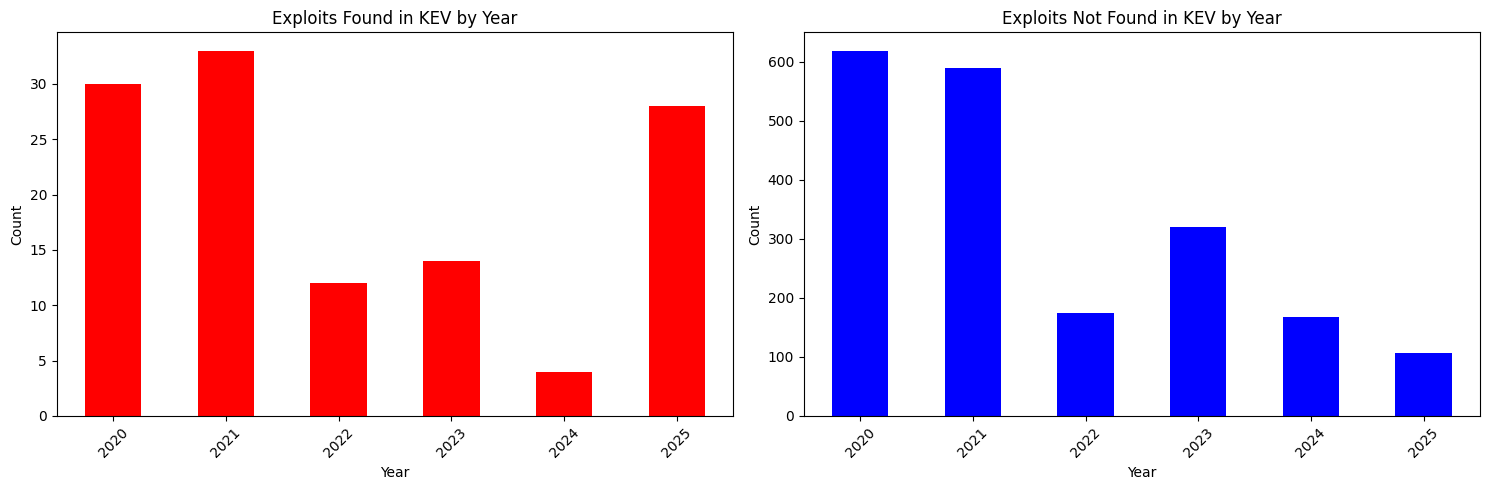

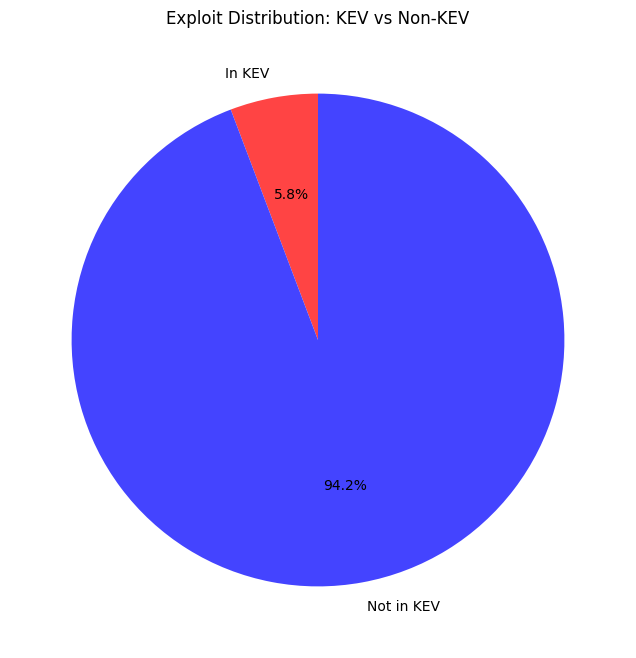

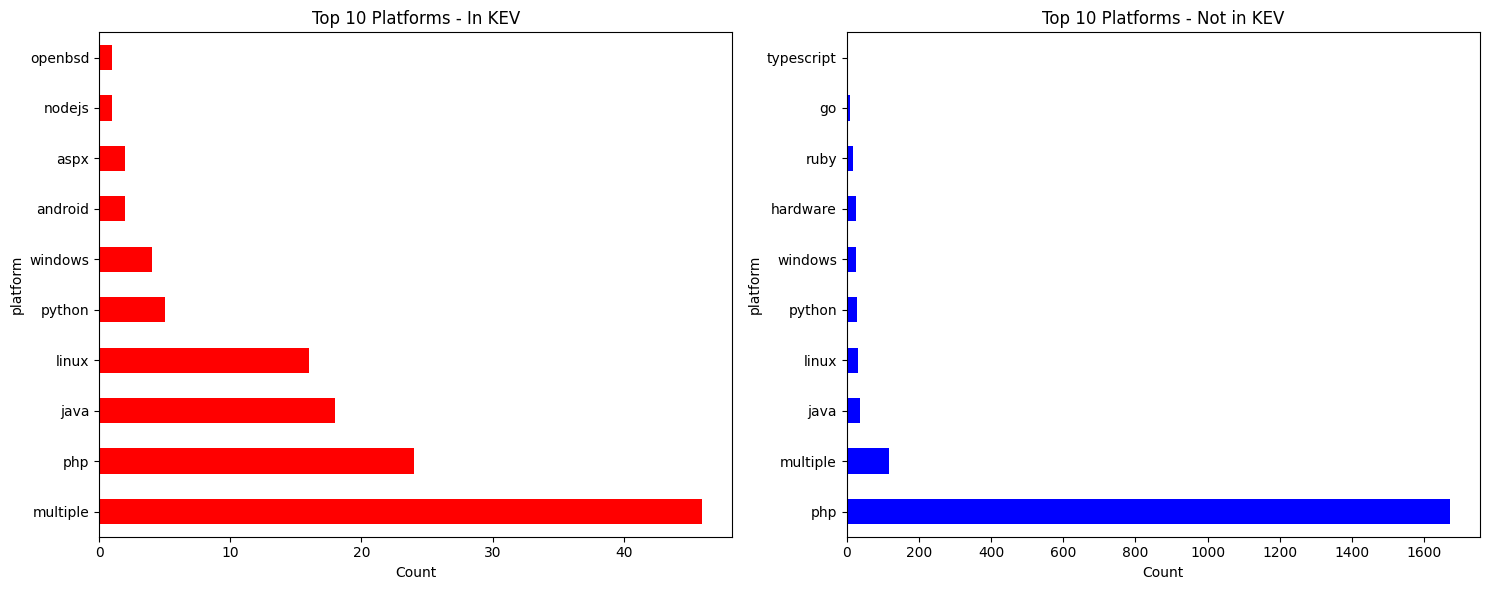

Visualizations saved:
- exploit_comparison.png
- kev_distribution.png
- platform_comparison.png


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations of both groups
if found_kev is not None and not_found_kev is not None and len(found_kev) > 0 and len(not_found_kev) > 0:
    
    # 1. Comparison of exploit count per year
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    if 'year' in found_kev.columns:
        found_kev['year'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='red')
        axes[0].set_title('Exploits Found in KEV by Year')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)
    
    if 'year' in not_found_kev.columns:
        not_found_kev['year'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='blue')
        axes[1].set_title('Exploits Not Found in KEV by Year')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('exploit_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Pie chart of distribution
    fig, ax = plt.subplots(figsize=(8, 8))
    sizes = [len(found_kev), len(not_found_kev)]
    labels = ['In KEV', 'Not in KEV']
    colors = ['#ff4444', '#4444ff']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Exploit Distribution: KEV vs Non-KEV')
    plt.savefig('kev_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Platform comparison (if available)
    if 'platform' in found_kev.columns and 'platform' in not_found_kev.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        found_kev['platform'].value_counts().head(10).plot(kind='barh', ax=axes[0], color='red')
        axes[0].set_title('Top 10 Platforms - In KEV')
        axes[0].set_xlabel('Count')
        
        not_found_kev['platform'].value_counts().head(10).plot(kind='barh', ax=axes[1], color='blue')
        axes[1].set_title('Top 10 Platforms - Not in KEV')
        axes[1].set_xlabel('Count')
        
        plt.tight_layout()
        plt.savefig('platform_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print("Visualizations saved:")
    print("- exploit_comparison.png")
    print("- kev_distribution.png")
    if 'platform' in found_kev.columns:
        print("- platform_comparison.png")
else:
    print("Not enough data for visualizations")


## Step 7: Advanced Analyses

Here we can perform interesting analyses on both groups, such as:
- Severity comparison
- Trend analysis
- Package/ecosystem analysis
- Timing analysis (time between CVE and exploit)


In [20]:
# Advanced analyses on both groups
def advanced_analysis(found_kev_df, not_found_kev_df):
    """Perform advanced analyses"""
    
    print("=== ADVANCED ANALYSES ===\n")
    
    # 1. Severity analysis (if available in OSV data)
    if found_kev_df is not None and 'severity' in found_kev_df.columns:
        print("Severity distribution - In KEV:")
        print(found_kev_df['severity'].value_counts())
        print("\nSeverity distribution - Not in KEV:")
        if not_found_kev_df is not None:
            print(not_found_kev_df['severity'].value_counts())
    
    # 2. Timing analysis - time between CVE publication and exploit
    # (If we have both dates)
    
    # 3. Ecosystem/Package analysis
    if found_kev_df is not None:
        # Check for package/ecosystem columns
        package_cols = [col for col in found_kev_df.columns if 'package' in col.lower() or 'ecosystem' in col.lower()]
        if package_cols:
            print(f"\nPackage/Ecosystem columns found: {package_cols}")
            for col in package_cols:
                print(f"\nTop packages in KEV group ({col}):")
                print(found_kev_df[col].value_counts().head(10))
    
    # 4. Export for further analysis
    print("\n=== EXPORT FOR FURTHER ANALYSIS ===")
    print("Both datasets are saved as CSV files")
    print("You can now use these for:")
    print("- Machine learning models")
    print("- Pattern detection")
    print("- Risk scoring")
    print("- Predictive analysis")

advanced_analysis(found_kev, not_found_kev)


=== ADVANCED ANALYSES ===


=== EXPORT FOR FURTHER ANALYSIS ===
Both datasets are saved as CSV files
You can now use these for:
- Machine learning models
- Pattern detection
- Risk scoring
- Predictive analysis
